# User Credit Data Project - Data Analysis

## Introduction

Here, I was given a set of user credit data from Indonesian credit card users from a particular credit card company/ credit lender.

This is the description of all the features in the data:

- x :	     represents the credit user's ID
- number_of_cards: 	 represents the number of credit cards owned by the user
- outstanding: represents the total outstanding amount of credit card usage of that user
- credit_limit: the	credit limit amount that can be used
- bill:	last month customer bill amount
- total_cash_usage:	last month total cash usage of customer
- total_retail_usage:	last month total retail usage of customer
- remaining_bill:	remaining bill that has not been paid in the last month
- branch_code:	 the branch code of the customer (branch location where the customer's data was obtained)
- payment_ratio:	payment per bill ratio in the last month
- overlimit_percentage:	overlimit percentage
- payment_ratio_3month:	payment per bill ratio in the last 3 month
- payment_ratio_6month:	payment per bill ratio in the last 6 month
- delinquency_score:	delinquency score
- years_since_card_issuing:	total year since first card issued
- total_usage:	total usage
- remaining_bill_per_number_of_cards:	ratio remaining bill per number of cards
- remaining_bill_per_limit:	ratio remaining bill per credit limit
- total_usage_per_limit	ratio: total usage per limit
- total_3mo_usage_per_limit:	the ratio of total 3 months usage per limit
- total_6mo_usage_per_limit:    the ratio of total 6 months usage per limit
- utilization_3month: 	Credit card utilization for past 3 months
- utilization_6month: 	Credit card utilization for past 6 months
- default_flag:  	Credit default flag (1: default; 0: non_default) 

Default refers to a user not being able to pay their debts on time. For this particular 


The aim of this project is to identify the characteristics of a customer/user who will eventually default on their loans. Thus, I aim to answer the following question:

Can we build a good classifier to classify our userbase into Default/Non-Default customers.

In [1]:
import sqlalchemy as sa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
# SQL Alchemy Engine
engine = sa.create_engine('sqlite:///sql_simulation.db')

Read data into Pandas dataframes.

In [5]:
user_base_part1_df = pd.read_csv('data/user_base_part1.csv')
user_label_branch_df = pd.read_csv('data/user_label_branch.csv')
user_transactions_df = pd.read_csv('data/user_transactions.csv')

In [18]:
# Insert data from pd.DataFrame to SQL Alchemy Engine
user_base_part1_df.to_sql(name='user_base_part1', con=engine)
user_label_branch_df.to_sql(name='user_label_branch', con=engine)
user_transactions_df.to_sql(name='user_transactions', con=engine)

In [20]:
user_base_part1_df.head()

,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,remaining_bill_per_limit,total_usage_per_limit,total_3mo_usage_per_limit,total_6mo_usage_per_limit,utilization_3month,utilization_6month
0,1,102.19,0.0,74.78,100.00,0.0,15.416667,94.0,13161.5,0.003760,0.000013,0.011719,0.017810,0.013228,0.021949
1,2,0.00,0.0,0.00,0.00,NaN,0.750000,1012.0,0.0,0.000000,0.000101,0.000000,0.000000,0.004232,0.000300
2,3,100.00,0.0,100.00,100.91,NaN,10.750000,0.0,0.0,0.000000,0.000000,0.040518,0.047703,0.249389,0.267853
3,4,100.00,0.0,25.01,22.64,0.0,19.750000,2536660.0,145333.5,0.027683,0.120793,0.055971,0.016851,0.101912,0.346635
4,5,95.99,0.0,97.49,99.84,NaN,1.666667,2666558.0,2975932.5,0.595186,0.266656,0.323027,0.131162,0.707865,0.336571


In [21]:
user_label_branch_df.head()

,x,number_of_cards,branch_code,default_flag
0,1-a,2,I,0
1,2-a,2,A,0
2,3-a,3,A,0
3,4-a,4,G,0
4,5-a,2,A,0


In [22]:
user_transactions_df.head()

,X,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill
0,1,36158,7000000.0,23437.0,0.0,94.0,26323.0
1,2,268691,10000000.0,254564.0,0.0,1012.0,0.0
2,3,6769149,28000000.0,4159779.0,0.0,0.0,0.0
3,4,3496732,21000000.0,111231.0,0.0,2536660.0,581334.0
4,5,9402085,10000000.0,6099283.0,0.0,2666558.0,5951865.0


## Data Analysis with SQL

In [23]:
# This function will take convert pandas dataframe to sql and then execute given queries, but returning the data as pandas dataframe as well
def convert_result(engine, s):
        """Execute SQL Statement and return result in pd.DataFrame.

        Args:
            s (string): the SQL statement

        Returns:
            df (pd.DataFrame) : the result of SQL queries
        """
        statement = engine.execute(s)
        df = pd.DataFrame(statement.fetchall())
        df.columns = statement.keys()
        return df

### Combining the Data

We can see that the dataframes are all separated into user_base, user_label, and user_transactions. Every data point has the same index, X in the data. It would definitely be helpful to combine all these into one table.

In [25]:
s = '''
 SELECT * 
 FROM user_base_part1 AS ub
 JOIN user_transactions AS ut ON ut.X = ub.X
 JOIN user_label_branch AS ul ON ub.X = REPLACE(ul.X, '-a', '')
 
'''
combined_df = convert_result(engine,s) #combine all datasets into one and put into dataframe combined_df
combined_df.head() #View the combined dataframe

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,x,number_of_cards,branch_code,default_flag
0,0,1,102.19,0.0,74.78,100.00,0.0,15.416667,94.0,13161.5,...,7000000.0,23437.0,0.0,94.0,26323.0,0,1-a,2,I,0
1,1,2,0.00,0.0,0.00,0.00,NaN,0.750000,1012.0,0.0,...,10000000.0,254564.0,0.0,1012.0,0.0,1,2-a,2,A,0
2,2,3,100.00,0.0,100.00,100.91,NaN,10.750000,0.0,0.0,...,28000000.0,4159779.0,0.0,0.0,0.0,2,3-a,3,A,0
3,3,4,100.00,0.0,25.01,22.64,0.0,19.750000,2536660.0,145333.5,...,21000000.0,111231.0,0.0,2536660.0,581334.0,3,4-a,4,G,0
4,4,5,95.99,0.0,97.49,99.84,NaN,1.666667,2666558.0,2975932.5,...,10000000.0,6099283.0,0.0,2666558.0,5951865.0,4,5-a,2,A,0


### Summary Statistics by **Default_flag** and **Branch_Code**

In [27]:
s = '''
    SELECT ul.default_flag,
        COUNT(DISTINCT ub.X) as count
    FROM user_base_part1 AS ub
    JOIN user_transactions AS ut ON ut.X = ub.X
    JOIN user_label_branch AS ul ON ub.X = REPLACE(ul.X, '-a', '')
    GROUP BY default_flag
'''
convert_result(engine,s)

,default_flag,count
0,0,14229
1,1,1416


In [29]:
s = '''
SELECT ul.branch_code,
    COUNT (DISTINCT ub.X) as count
FROM user_base_part1 AS ub
JOIN user_transactions AS ut ON ut.X = ub.X
JOIN user_label_branch AS ul ON ub.X = REPLACE(ul.X, '-a', '')
GROUP BY branch_code

'''
convert_result(engine,s)

,branch_code,count
0,None,195
1,A,8693
2,B,1348
3,C,332
4,D,205
5,E,647
6,F,1694
7,G,566
8,H,367
9,I,990


There are some values with upper-case and lower-case elements. Moreover, some empty elements in branch_code are also detected (195 empty branch_code elements)

### Imputing most common branch code into the null values

In [31]:
#This query tries to group null branch_code values into 'a', the mode of the branch code
s= '''
SELECT  
  CASE
   WHEN (ul.branch_code) IS NULL THEN 'a'
    ELSE LOWER(ul.branch_code)
  END as branch_code,
    COUNT (DISTINCT ub.X) as count
    
FROM user_base_part1 AS ub
JOIN user_transactions AS ut ON ut.X = ub.X
JOIN user_label_branch AS ul ON ub.X = REPLACE(ul.X, '-a', '')
GROUP BY branch_code

'''
combined_df = convert_result(engine,s) #This is saved into combined_df, for Assignment #2
combined_df

,branch_code,count
0,a,195
1,a,8693
2,b,1348
3,c,332
4,d,205
5,e,647
6,f,1694
7,g,566
8,h,367
9,i,990


### Displaying top 5 customers with the highest credit usage in 6 months

Creating new variable, total_usage_6mo, which is obtained by multiplying total_6mo_usage_per_limit and credit_limit. And displaying top 5 users with the highest total_usage_6mo

In [32]:
s = '''
WITH data AS 
(SELECT 
   ub.X,
   ub.total_6mo_usage_per_limit * ut.credit_limit as total_usage_6mo,
   CASE
   WHEN (ul.branch_code) IS NULL THEN 'a'
    ELSE LOWER(ul.branch_code)
  END as branch_code,
   ROW_NUMBER() OVER (PARTITION BY ul.branch_code ORDER BY ub.total_6mo_usage_per_limit * ut.credit_limit DESC) AS rank
   FROM user_base_part1 as ub
   JOIN user_transactions AS ut ON ut.X = ub.X
   JOIN user_label_branch AS ul ON ub.X = REPLACE(ul.X, '-a', '')
   GROUP BY 1,2
)

SELECT branch_code,
rank,
X,
total_usage_6mo
FROM data
WHERE rank <=5

   
'''
convert_result(engine,s)

,branch_code,rank,X,total_usage_6mo
0,a,1,14812,6.617400e+07
1,a,2,15585,6.617400e+07
2,a,3,7441,3.860000e+07
3,a,4,15531,3.860000e+07
4,a,5,8568,3.800300e+07
...,...,...,...,...
73,f,2,75,3.987000e+05
74,f,3,29,2.178680e+05
75,i,1,217,2.853169e+06
76,j,1,218,0.000000e+00


### Displaying Cumulative Default Rates per Decile 

Each Decile will display the following information and be sorted by their outstanding values:
    
- Number of users
- Number of default users
- The default rate for each decile 
- Cumulative default rate
- Min, max, avg “outstanding”

In [36]:
s = '''
SELECT decile,
    COUNT(DISTINCT X) as number_of_users,
    COUNT(DISTINCT CASE WHEN default_flag = 1 THEN X ELSE NULL END) as number_of_default_users,
    COUNT(DISTINCT CASE WHEN default_flag = 1 THEN X ELSE NULL END) / CAST(COUNT(DISTINCT X) AS FLOAT) as default_rate,
    SUM(COUNT(DISTINCT CASE WHEN default_flag = 1 THEN X ELSE NULL END) /CAST(COUNT(DISTINCT X) AS FLOAT)) OVER (ORDER BY decile) AS cumulative_default_rate,
    MIN(outstanding) as min_outstanding,
    MAX(outstanding) as max_outstanding,
    AVG(outstanding) as avg_outstanding
FROM (
    SELECT ub.X,
        ul.default_flag,
        ut.outstanding,
        NTILE(10) OVER (ORDER BY ut.outstanding) AS decile
    FROM user_base_part1 AS ub
    JOIN user_transactions AS ut ON ut.X = ub.X
    JOIN user_label_branch AS ul ON ub.X = REPLACE(ul.X, '-a', '')
)
GROUP BY 1
ORDER BY 1
'''
convert_result(engine,s)

,decile,number_of_users,number_of_default_users,default_rate,cumulative_default_rate,min_outstanding,max_outstanding,avg_outstanding
0,1,1565,344,0.219808,0.219808,0,334128,1.321829e+05
1,2,1565,53,0.033866,0.253674,334750,1334327,7.923163e+05
2,3,1565,48,0.030671,0.284345,1334725,2587708,1.985958e+06
3,4,1565,97,0.061981,0.346326,2587715,3463385,3.058284e+06
4,5,1565,101,0.064537,0.410863,3463542,4721563,4.042975e+06
5,6,1564,138,0.088235,0.499098,4722525,6028571,5.346846e+06
6,7,1564,113,0.072251,0.571349,6029687,8494395,7.188113e+06
7,8,1564,132,0.084399,0.655748,8496119,14730155,1.099222e+07
8,9,1564,153,0.097826,0.753574,14730155,27377448,2.000410e+07
9,10,1564,237,0.151535,0.905108,27377448,798058574,6.254995e+07


In [37]:
# Select dataframe to work with
s = '''
 SELECT * 
 FROM user_base_part1 AS ub
 JOIN user_transactions AS ut ON ut.X = ub.X
 JOIN user_label_branch AS ul ON ub.X = REPLACE(ul.X, '-a', '')
 
'''
combined_df = convert_result(engine,s) #combine all datasets into one and put into dataframe combined_df
combined_df.head() #View the combined dataframe

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,x,number_of_cards,branch_code,default_flag
0,0,1,102.19,0.0,74.78,100.00,0.0,15.416667,94.0,13161.5,...,7000000.0,23437.0,0.0,94.0,26323.0,0,1-a,2,I,0
1,1,2,0.00,0.0,0.00,0.00,NaN,0.750000,1012.0,0.0,...,10000000.0,254564.0,0.0,1012.0,0.0,1,2-a,2,A,0
2,2,3,100.00,0.0,100.00,100.91,NaN,10.750000,0.0,0.0,...,28000000.0,4159779.0,0.0,0.0,0.0,2,3-a,3,A,0
3,3,4,100.00,0.0,25.01,22.64,0.0,19.750000,2536660.0,145333.5,...,21000000.0,111231.0,0.0,2536660.0,581334.0,3,4-a,4,G,0
4,4,5,95.99,0.0,97.49,99.84,NaN,1.666667,2666558.0,2975932.5,...,10000000.0,6099283.0,0.0,2666558.0,5951865.0,4,5-a,2,A,0


For the rest of the project, I will be working with the combined_df dataframe.

## Data Cleaning

### Missing Values and Anomalies

In [42]:
#Function to check the NA values
def check_NA(df):
    df_data_null = df.isnull().sum().reset_index(name='count') #get the count of the null values
    df_data_null['percentage'] = df_data_null['count']/df.shape[0]*100 #count percentage of the null values
    print('Total number of null values: ', df_data_null['count'].sum())
    return df_data_null

In [43]:
#Check for NA
df_data_null = check_NA(combined_df)
df_data_null

Total number of null values:  354


,index,count,percentage
0,index,0,0.000000
1,X,0,0.000000
2,payment_ratio,0,0.000000
3,overlimit_percentage,26,0.166187
4,payment_ratio_3month,0,0.000000
5,payment_ratio_6month,0,0.000000
6,delinquency_score,88,0.562480
7,years_since_card_issuing,0,0.000000
8,total_usage,0,0.000000
9,remaining_bill_per_number_of_cards,0,0.000000


#### branch_code

In [45]:
combined_df['branch_code'] = combined_df.branch_code.fillna('A')
combined_df['branch_code'] = [d.upper() for d in combined_df['branch_code']]
combined_df.head()

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,x,number_of_cards,branch_code,default_flag
0,0,1,102.19,0.0,74.78,100.00,0.0,15.416667,94.0,13161.5,...,7000000.0,23437.0,0.0,94.0,26323.0,0,1-a,2,I,0
1,1,2,0.00,0.0,0.00,0.00,NaN,0.750000,1012.0,0.0,...,10000000.0,254564.0,0.0,1012.0,0.0,1,2-a,2,A,0
2,2,3,100.00,0.0,100.00,100.91,NaN,10.750000,0.0,0.0,...,28000000.0,4159779.0,0.0,0.0,0.0,2,3-a,3,A,0
3,3,4,100.00,0.0,25.01,22.64,0.0,19.750000,2536660.0,145333.5,...,21000000.0,111231.0,0.0,2536660.0,581334.0,3,4-a,4,G,0
4,4,5,95.99,0.0,97.49,99.84,NaN,1.666667,2666558.0,2975932.5,...,10000000.0,6099283.0,0.0,2666558.0,5951865.0,4,5-a,2,A,0


In [46]:
# Repeat Check for NA after updating the null branch codes
df_data_null = check_NA(combined_df)
df_data_null


Total number of null values:  159


,index,count,percentage
0,index,0,0.000000
1,X,0,0.000000
2,payment_ratio,0,0.000000
3,overlimit_percentage,26,0.166187
4,payment_ratio_3month,0,0.000000
5,payment_ratio_6month,0,0.000000
6,delinquency_score,88,0.562480
7,years_since_card_issuing,0,0.000000
8,total_usage,0,0.000000
9,remaining_bill_per_number_of_cards,0,0.000000


#### overlimit_percentage

In [47]:
combined_df['test'] = ((combined_df['outstanding']/combined_df['credit_limit']) - 1) * 100.0

In [48]:
combined_df[['test','overlimit_percentage']].head(100)

,test,overlimit_percentage
0,-99.483457,0.0
1,-97.313090,0.0
2,-75.824468,0.0
3,-83.348895,0.0
4,-5.979150,0.0
...,...,...
95,-57.043400,0.0
96,-9.642122,0.0
97,-78.179720,0.0
98,-93.181389,0.0


However, this cross-examination proves that this assumption seems to be untrue, as some overlimit_percentage values do not conform those with test. Therefore, I resort to the next option, which is to drop these null values

In [51]:
combined_df = combined_df.drop('test', axis=1) #drop the test column previously made and save to dataset
combined_df.head() #verify that this operation succeede

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,x,number_of_cards,branch_code,default_flag
0,0,1,102.19,0.0,74.78,100.00,0.0,15.416667,94.0,13161.5,...,7000000.0,23437.0,0.0,94.0,26323.0,0,1-a,2,I,0
1,1,2,0.00,0.0,0.00,0.00,NaN,0.750000,1012.0,0.0,...,10000000.0,254564.0,0.0,1012.0,0.0,1,2-a,2,A,0
2,2,3,100.00,0.0,100.00,100.91,NaN,10.750000,0.0,0.0,...,28000000.0,4159779.0,0.0,0.0,0.0,2,3-a,3,A,0
3,3,4,100.00,0.0,25.01,22.64,0.0,19.750000,2536660.0,145333.5,...,21000000.0,111231.0,0.0,2536660.0,581334.0,3,4-a,4,G,0
4,4,5,95.99,0.0,97.49,99.84,NaN,1.666667,2666558.0,2975932.5,...,10000000.0,6099283.0,0.0,2666558.0,5951865.0,4,5-a,2,A,0


In [53]:
# Dropping Rows with Null values in the Overlimit Percentage Column
combined_df = combined_df.dropna(axis=0, subset=['overlimit_percentage'])
#Check for NA
df_data_null = check_NA(combined_df)
df_data_null[df_data_null["count"] != 0]

Total number of null values:  133


,index,count,percentage
6,delinquency_score,88,0.563416
21,total_cash_usage,45,0.288111


#### delinquency_score

In [54]:
# Finding out the delinquency score numbers per delinquency score from 0 - 5.
combined_df.delinquency_score.value_counts()

0.0    15394
3.0       34
5.0       31
1.0       29
2.0       24
4.0       19
Name: delinquency_score, dtype: int64

In [55]:
combined_df.groupby('default_flag')['delinquency_score'].value_counts(dropna=False)

default_flag  delinquency_score
0             0.0                  14114
              NaN                     88
              1.0                     22
              2.0                      3
              3.0                      2
1             0.0                   1280
              3.0                     32
              5.0                     31
              2.0                     21
              4.0                     19
              1.0                      7
Name: delinquency_score, dtype: int64

It can be observed that most null values in the delinquency score are part of the non-defaulters. Since, they are more likely to be good credit users and also have delinquency_score of 0, there is strong rationale to fill in the delinquency_score column values with the mode delinquency score in non-defaulters, thus filling in with 0.

In [56]:
combined_df['delinquency_score']=combined_df['delinquency_score'].fillna(0)
combined_df.groupby('default_flag')['delinquency_score'].value_counts(dropna=False)

default_flag  delinquency_score
0             0.0                  14202
              1.0                     22
              2.0                      3
              3.0                      2
1             0.0                   1280
              3.0                     32
              5.0                     31
              2.0                     21
              4.0                     19
              1.0                      7
Name: delinquency_score, dtype: int64

The NA scores have been filled in with 0

In [58]:
#Check for NA
df_data_null = combined_df.isnull().sum().reset_index(name = 'count')
df_data_null['percentage'] = df_data_null['count']/combined_df.shape[0]*100 #percentage of the data
print(df_data_null['count'].sum())
df_data_null[df_data_null["count"] != 0]

45


,index,count,percentage
21,total_cash_usage,45,0.288111


#### total_cash_usage

It can be observed that total_usage = total_cash_usage + total_retail_usage. Thus, total_cash_usage = total_usage - total_retail_usage.

In [59]:
combined_df.describe() #Describe data set before making any changes to total_cash_usage

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,X,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,number_of_cards,default_flag
count,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,1.561900e+04,1.561900e+04,...,15619.000000,1.561900e+04,1.561900e+04,1.561900e+04,1.557400e+04,1.561900e+04,1.561900e+04,15619.000000,15619.000000,15619.000000
mean,7809.024585,7810.024585,64.537466,3.330655,50.534123,81.613877,0.026250,6.630585,2.102439e+06,2.970378e+06,...,7810.024585,1.160864e+07,2.083293e+07,8.075177e+06,7.450805e+04,2.028032e+06,8.144358e+06,7809.024585,2.506306,0.088994
std,4509.003849,4509.003849,790.973905,9.215148,1321.914940,1461.949634,0.309829,4.669326,8.079554e+06,6.267460e+06,...,4509.003849,2.406312e+07,2.955319e+07,1.757742e+07,6.178510e+05,7.915520e+06,1.922352e+07,4509.003849,1.012919,0.284744
min,0.000000,1.000000,-18138.000000,0.000000,-57792.340000,-77056.000000,0.000000,0.750000,-1.566720e+07,0.000000e+00,...,1.000000,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,-1.566720e+07,0.000000e+00,0.000000,1.000000,0.000000
25%,3904.500000,3905.500000,0.000000,0.000000,20.200000,21.575000,0.000000,2.920000,0.000000e+00,0.000000e+00,...,3905.500000,1.993263e+06,5.000000e+06,8.164535e+05,0.000000e+00,0.000000e+00,0.000000e+00,3904.500000,2.000000,0.000000
50%,7809.000000,7810.000000,27.000000,0.000000,50.000000,65.600000,0.000000,5.666667,2.457890e+05,1.202923e+06,...,7810.000000,4.725195e+06,9.000000e+06,3.141366e+06,0.000000e+00,2.000000e+05,2.747165e+06,7809.000000,2.000000,0.000000
75%,11713.500000,11714.500000,100.000000,1.010000,91.335000,100.000000,0.000000,9.330000,1.512235e+06,3.089174e+06,...,11714.500000,1.067507e+07,2.200000e+07,7.409427e+06,0.000000e+00,1.399350e+06,7.143198e+06,11713.500000,3.000000,0.000000
max,15642.000000,15643.000000,68983.000000,190.000000,75575.000000,54899.000000,5.000000,34.416667,3.140000e+08,1.480000e+08,...,15643.000000,7.980586e+08,1.000000e+09,6.280000e+08,2.884057e+07,2.850000e+08,4.440000e+08,15642.000000,16.000000,1.000000


In [60]:
 #Here, a column to test the hypothesis is made, this column is named `test_cash_usage`
combined_df['test_cash_usage'] = combined_df['total_usage'] - combined_df['total_retail_usage']
df_not_nan = combined_df[~combined_df.total_cash_usage.isnull()]
df_not_nan[df_not_nan.test_cash_usage != df_not_nan.total_cash_usage]
#Check test cash usage vs total cash usage values for the columns with different values

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,bill,total_cash_usage,total_retail_usage,remaining_bill,index,x,number_of_cards,branch_code,default_flag,test_cash_usage
3519,3519,3520,100.0,0.00,100.00,99.80,0.0,5.75,1599823.0,0.0,...,916296.0,900000.0,700000.0,0.0,3519,3520-a,2,A,0,899823.0
4469,4469,4470,100.0,12.60,100.00,100.00,0.0,3.17,22505130.0,0.0,...,7659334.0,4500000.0,18000000.0,0.0,4469,4470-a,4,A,0,4505130.0
6497,6497,6498,200.0,0.00,106.00,99.70,0.0,3.25,1100135.0,1069844.0,...,1574907.0,400000.0,700000.0,2139688.0,6497,6498-a,2,I,0,400135.0
6688,6688,6689,110.0,0.00,105.00,100.00,0.0,8.50,11000000.0,0.0,...,11000000.0,900000.0,10078950.0,0.0,6688,6689-a,2,A,0,921050.0
6882,6882,6883,0.0,0.00,11.20,66.70,0.0,16.00,12000000.0,8975005.0,...,48000000.0,500000.0,11517024.0,53850027.0,6882,6883-a,6,E,0,482976.0
9095,9095,9096,61.2,0.00,75.00,30.10,0.0,8.75,314000000.0,59904320.0,...,382000000.0,28840572.0,285000000.0,240000000.0,9095,9096-a,4,B,0,29000000.0
11151,11151,11152,100.0,4.58,34.30,0.00,0.0,1.67,12000000.0,7799046.0,...,16107997.0,10000000.0,1970519.0,15598091.0,11151,11152-a,2,A,0,10029481.0
11947,11947,11948,0.0,16.80,45.60,47.60,0.0,6.83,15532304.0,8832734.0,...,19000000.0,3500000.0,12000000.0,35330935.0,11947,11948-a,4,A,0,3532304.0
12303,12303,12304,61.2,20.00,75.00,76.20,0.0,5.50,314000000.0,63237084.0,...,419000000.0,28733412.0,285000000.0,443000000.0,12303,12304-a,7,A,0,29000000.0
12723,12723,12724,0.0,5.60,9.57,6.76,0.0,4.50,11000000.0,18146675.0,...,65200287.0,6000000.0,5020000.0,72586700.0,12723,12724-a,4,A,0,5980000.0


In [61]:
combined_df.describe() #describe both total cash usage and test cash usage

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,number_of_cards,default_flag,test_cash_usage
count,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,1.561900e+04,1.561900e+04,...,1.561900e+04,1.561900e+04,1.561900e+04,1.557400e+04,1.561900e+04,1.561900e+04,15619.000000,15619.000000,15619.000000,1.561900e+04
mean,7809.024585,7810.024585,64.537466,3.330655,50.534123,81.613877,0.026250,6.630585,2.102439e+06,2.970378e+06,...,1.160864e+07,2.083293e+07,8.075177e+06,7.450805e+04,2.028032e+06,8.144358e+06,7809.024585,2.506306,0.088994,7.440715e+04
std,4509.003849,4509.003849,790.973905,9.215148,1321.914940,1461.949634,0.309829,4.669326,8.079554e+06,6.267460e+06,...,2.406312e+07,2.955319e+07,1.757742e+07,6.178510e+05,7.915520e+06,1.922352e+07,4509.003849,1.012919,0.284744,6.183562e+05
min,0.000000,1.000000,-18138.000000,0.000000,-57792.340000,-77056.000000,0.000000,0.750000,-1.566720e+07,0.000000e+00,...,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,-1.566720e+07,0.000000e+00,0.000000,1.000000,0.000000,0.000000e+00
25%,3904.500000,3905.500000,0.000000,0.000000,20.200000,21.575000,0.000000,2.920000,0.000000e+00,0.000000e+00,...,1.993263e+06,5.000000e+06,8.164535e+05,0.000000e+00,0.000000e+00,0.000000e+00,3904.500000,2.000000,0.000000,0.000000e+00
50%,7809.000000,7810.000000,27.000000,0.000000,50.000000,65.600000,0.000000,5.666667,2.457890e+05,1.202923e+06,...,4.725195e+06,9.000000e+06,3.141366e+06,0.000000e+00,2.000000e+05,2.747165e+06,7809.000000,2.000000,0.000000,0.000000e+00
75%,11713.500000,11714.500000,100.000000,1.010000,91.335000,100.000000,0.000000,9.330000,1.512235e+06,3.089174e+06,...,1.067507e+07,2.200000e+07,7.409427e+06,0.000000e+00,1.399350e+06,7.143198e+06,11713.500000,3.000000,0.000000,0.000000e+00
max,15642.000000,15643.000000,68983.000000,190.000000,75575.000000,54899.000000,5.000000,34.416667,3.140000e+08,1.480000e+08,...,7.980586e+08,1.000000e+09,6.280000e+08,2.884057e+07,2.850000e+08,4.440000e+08,15642.000000,16.000000,1.000000,2.900000e+07


In [62]:
combined_df.dtypes #check dtypes just to make sure

index                                   int64
X                                       int64
payment_ratio                         float64
overlimit_percentage                  float64
payment_ratio_3month                  float64
payment_ratio_6month                  float64
delinquency_score                     float64
years_since_card_issuing              float64
total_usage                           float64
remaining_bill_per_number_of_cards    float64
remaining_bill_per_limit              float64
total_usage_per_limit                 float64
total_3mo_usage_per_limit             float64
total_6mo_usage_per_limit             float64
utilization_3month                    float64
utilization_6month                    float64
index                                   int64
X                                       int64
outstanding                             int64
credit_limit                          float64
bill                                  float64
total_cash_usage                  

For some 10 rows, it is found that the total_cash_usage is not the same as the made up test_cash_usage. Upon closer examination, there is very miniscule difference between them, perhaps due to some calculation or rounding errors. Since the rest of the 15000 or so data agrees with this calculation, the NA total_cash_usage values will be filled in with total usage - total_retail_usage values.

In [63]:
combined_df['total_cash_usage'] = combined_df['test_cash_usage']
combined_df = combined_df.drop('test_cash_usage',axis=1)
combined_df.head()

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,x,number_of_cards,branch_code,default_flag
0,0,1,102.19,0.0,74.78,100.00,0.0,15.416667,94.0,13161.5,...,7000000.0,23437.0,0.0,94.0,26323.0,0,1-a,2,I,0
1,1,2,0.00,0.0,0.00,0.00,0.0,0.750000,1012.0,0.0,...,10000000.0,254564.0,0.0,1012.0,0.0,1,2-a,2,A,0
2,2,3,100.00,0.0,100.00,100.91,0.0,10.750000,0.0,0.0,...,28000000.0,4159779.0,0.0,0.0,0.0,2,3-a,3,A,0
3,3,4,100.00,0.0,25.01,22.64,0.0,19.750000,2536660.0,145333.5,...,21000000.0,111231.0,0.0,2536660.0,581334.0,3,4-a,4,G,0
4,4,5,95.99,0.0,97.49,99.84,0.0,1.666667,2666558.0,2975932.5,...,10000000.0,6099283.0,0.0,2666558.0,5951865.0,4,5-a,2,A,0


In [64]:
combined_df.describe()

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,X,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,number_of_cards,default_flag
count,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,1.561900e+04,1.561900e+04,...,15619.000000,1.561900e+04,1.561900e+04,1.561900e+04,1.561900e+04,1.561900e+04,1.561900e+04,15619.000000,15619.000000,15619.000000
mean,7809.024585,7810.024585,64.537466,3.330655,50.534123,81.613877,0.026250,6.630585,2.102439e+06,2.970378e+06,...,7810.024585,1.160864e+07,2.083293e+07,8.075177e+06,7.440715e+04,2.028032e+06,8.144358e+06,7809.024585,2.506306,0.088994
std,4509.003849,4509.003849,790.973905,9.215148,1321.914940,1461.949634,0.309829,4.669326,8.079554e+06,6.267460e+06,...,4509.003849,2.406312e+07,2.955319e+07,1.757742e+07,6.183562e+05,7.915520e+06,1.922352e+07,4509.003849,1.012919,0.284744
min,0.000000,1.000000,-18138.000000,0.000000,-57792.340000,-77056.000000,0.000000,0.750000,-1.566720e+07,0.000000e+00,...,1.000000,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,-1.566720e+07,0.000000e+00,0.000000,1.000000,0.000000
25%,3904.500000,3905.500000,0.000000,0.000000,20.200000,21.575000,0.000000,2.920000,0.000000e+00,0.000000e+00,...,3905.500000,1.993263e+06,5.000000e+06,8.164535e+05,0.000000e+00,0.000000e+00,0.000000e+00,3904.500000,2.000000,0.000000
50%,7809.000000,7810.000000,27.000000,0.000000,50.000000,65.600000,0.000000,5.666667,2.457890e+05,1.202923e+06,...,7810.000000,4.725195e+06,9.000000e+06,3.141366e+06,0.000000e+00,2.000000e+05,2.747165e+06,7809.000000,2.000000,0.000000
75%,11713.500000,11714.500000,100.000000,1.010000,91.335000,100.000000,0.000000,9.330000,1.512235e+06,3.089174e+06,...,11714.500000,1.067507e+07,2.200000e+07,7.409427e+06,0.000000e+00,1.399350e+06,7.143198e+06,11713.500000,3.000000,0.000000
max,15642.000000,15643.000000,68983.000000,190.000000,75575.000000,54899.000000,5.000000,34.416667,3.140000e+08,1.480000e+08,...,15643.000000,7.980586e+08,1.000000e+09,6.280000e+08,2.900000e+07,2.850000e+08,4.440000e+08,15642.000000,16.000000,1.000000


### Negative Values

It is observed that some values are negative, particularly in payment_ratio (including payment ration for 3 and 6 months), total_usage, and total_cash_usage. Considering the definition that was given regarding payment ratio as payment per bill ratio in the last month, its definitely impossible to have negative payment ratios. Moreover, since it is known that total_usage = total_cash + total_retail and that these represent the total usage of the customer's credit card. It is definily hard to accept negative usage of credit cards. Therefore, these values will be dropped.

In [65]:
combined_df.describe() #Observe the minimum values, some are negative

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,X,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,number_of_cards,default_flag
count,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,15619.000000,1.561900e+04,1.561900e+04,...,15619.000000,1.561900e+04,1.561900e+04,1.561900e+04,1.561900e+04,1.561900e+04,1.561900e+04,15619.000000,15619.000000,15619.000000
mean,7809.024585,7810.024585,64.537466,3.330655,50.534123,81.613877,0.026250,6.630585,2.102439e+06,2.970378e+06,...,7810.024585,1.160864e+07,2.083293e+07,8.075177e+06,7.440715e+04,2.028032e+06,8.144358e+06,7809.024585,2.506306,0.088994
std,4509.003849,4509.003849,790.973905,9.215148,1321.914940,1461.949634,0.309829,4.669326,8.079554e+06,6.267460e+06,...,4509.003849,2.406312e+07,2.955319e+07,1.757742e+07,6.183562e+05,7.915520e+06,1.922352e+07,4509.003849,1.012919,0.284744
min,0.000000,1.000000,-18138.000000,0.000000,-57792.340000,-77056.000000,0.000000,0.750000,-1.566720e+07,0.000000e+00,...,1.000000,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,-1.566720e+07,0.000000e+00,0.000000,1.000000,0.000000
25%,3904.500000,3905.500000,0.000000,0.000000,20.200000,21.575000,0.000000,2.920000,0.000000e+00,0.000000e+00,...,3905.500000,1.993263e+06,5.000000e+06,8.164535e+05,0.000000e+00,0.000000e+00,0.000000e+00,3904.500000,2.000000,0.000000
50%,7809.000000,7810.000000,27.000000,0.000000,50.000000,65.600000,0.000000,5.666667,2.457890e+05,1.202923e+06,...,7810.000000,4.725195e+06,9.000000e+06,3.141366e+06,0.000000e+00,2.000000e+05,2.747165e+06,7809.000000,2.000000,0.000000
75%,11713.500000,11714.500000,100.000000,1.010000,91.335000,100.000000,0.000000,9.330000,1.512235e+06,3.089174e+06,...,11714.500000,1.067507e+07,2.200000e+07,7.409427e+06,0.000000e+00,1.399350e+06,7.143198e+06,11713.500000,3.000000,0.000000
max,15642.000000,15643.000000,68983.000000,190.000000,75575.000000,54899.000000,5.000000,34.416667,3.140000e+08,1.480000e+08,...,15643.000000,7.980586e+08,1.000000e+09,6.280000e+08,2.900000e+07,2.850000e+08,4.440000e+08,15642.000000,16.000000,1.000000


In [68]:
print('number of negative values in payment_ratio: ',len(combined_df[combined_df['payment_ratio'] < 0]))
print('number of negative values in payment_ratio_3month: ',len(combined_df[combined_df['payment_ratio_3month'] < 0]))
print('number of negative values in payment_ratio_6month: ',len(combined_df[combined_df['payment_ratio_6month'] < 0]))
print('number of negative values in total_usage: ',len(combined_df[combined_df['total_usage'] < 0]))
print('number of negative values in total_retail_usage: ',len(combined_df[combined_df['total_retail_usage'] < 0]))
print('number of negative values in total_retail_usage: ',len(combined_df[combined_df['total_retail_usage'] < 0]))
print('number of negative values in total_3mo_usage_per_limit: ' ,len(combined_df[combined_df['total_3mo_usage_per_limit'] < 0]))
print('number of negative values in total_6mo_usage_per_limit: ' ,len(combined_df[combined_df['total_6mo_usage_per_limit'] < 0]))


#Total Number of Negative Values
len(combined_df[combined_df['payment_ratio'] < 0]) + len(combined_df[combined_df['payment_ratio_3month'] < 0]) + len(combined_df[combined_df['payment_ratio_6month'] < 0]) + len(combined_df[combined_df['total_usage'] < 0]) +len(combined_df[combined_df['total_retail_usage'] < 0]) + len(combined_df[combined_df['total_6mo_usage_per_limit'] < 0]) + len(combined_df[combined_df['total_3mo_usage_per_limit'] < 0])

number of negative values in payment_ratio:  30
number of negative values in payment_ratio_3month:  87
number of negative values in payment_ratio_6month:  75
number of negative values in total_usage:  42
number of negative values in total_retail_usage:  43
number of negative values in total_retail_usage:  43
number of negative values in total_3mo_usage_per_limit:  11
number of negative values in total_6mo_usage_per_limit:  17


305

There are roughly 305 rows with negative values in all of those columns. It must first be examined from which group, defaulters or non-defaulters these 305 values come from. If they mostly come from the defaulters dataset, it would prove to be harmful because 200 rows roughly correspond to almost 15% of the defaulters group data

In [69]:
combined_df_defaulters = combined_df[combined_df['default_flag'] == 1]
combined_df_defaulters.describe()

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,X,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,number_of_cards,default_flag
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1.390000e+03,1.390000e+03,...,1390.000000,1.390000e+03,1.390000e+03,1.390000e+03,1.390000e+03,1.390000e+03,1.390000e+03,1390.000000,1390.000000,1390.0
mean,7731.020144,7732.020144,15.990705,7.474345,20.510748,40.134058,0.270504,6.639426,8.478945e+05,5.403125e+06,...,7732.020144,1.844798e+07,2.364388e+07,1.408063e+07,1.064396e+05,7.414549e+05,1.604288e+07,7731.020144,2.577698,1.0
std,4564.289766,4564.289766,141.571893,15.141358,308.058720,2567.302911,0.988155,5.043606,5.791983e+06,1.080336e+07,...,4564.289766,4.252825e+07,4.759604e+07,3.129835e+07,7.306872e+05,5.730018e+06,3.437229e+07,4564.289766,1.120240,0.0
min,13.000000,14.000000,-2019.000000,0.000000,-11068.000000,-77056.000000,0.000000,0.750000,-1.200000e+07,0.000000e+00,...,14.000000,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,-1.200000e+07,0.000000e+00,13.000000,1.000000,1.0
25%,3705.000000,3706.000000,0.000000,0.000000,9.010000,10.800000,0.000000,2.580000,0.000000e+00,4.431483e+04,...,3706.000000,5.157092e+05,5.000000e+06,3.573968e+05,0.000000e+00,0.000000e+00,9.479675e+04,3705.000000,2.000000,1.0
50%,7820.000000,7821.000000,0.000000,0.000000,20.150000,30.100000,0.000000,5.420000,0.000000e+00,2.018758e+06,...,7821.000000,5.486492e+06,1.000000e+07,4.668224e+06,0.000000e+00,0.000000e+00,4.837118e+06,7820.000000,2.000000,1.0
75%,11692.250000,11693.250000,12.122500,11.200000,47.315000,70.077500,0.000000,10.100000,4.787300e+04,5.916378e+06,...,11693.250000,1.756998e+07,2.700000e+07,1.272705e+07,0.000000e+00,2.000000e+04,1.543564e+07,11692.250000,3.000000,1.0
max,15642.000000,15643.000000,4198.850000,189.000000,1534.000000,54899.000000,5.000000,32.833333,1.520000e+08,1.480000e+08,...,15643.000000,7.980586e+08,1.000000e+09,6.280000e+08,1.500000e+07,1.520000e+08,4.440000e+08,15642.000000,16.000000,1.0


In [70]:
print('defaulters number of negative values in payment_ratio',len(combined_df_defaulters[combined_df_defaulters['payment_ratio'] < 0]))
print('defaulters number of negative values in payment_ratio_3month',len(combined_df_defaulters[combined_df_defaulters['payment_ratio_3month'] < 0]))
print('defaulters number of negative values in payment_ratio_6month',len(combined_df_defaulters[combined_df_defaulters['payment_ratio_6month'] < 0]))
print('defaulters number of negative values in total_usage',len(combined_df_defaulters[combined_df_defaulters['total_usage'] < 0]))
print('defaulters number of negative values in total_retail_usage',len(combined_df_defaulters[combined_df_defaulters['total_retail_usage'] < 0]))
print('defaulters number of negative values in total_3month_usage',len(combined_df_defaulters[combined_df_defaulters['total_3mo_usage_per_limit'] < 0]))
print('defaulters number of negative values in total_6month_usage',len(combined_df_defaulters[combined_df_defaulters['total_6mo_usage_per_limit'] < 0]))
# 46 total values

defaulters number of negative values in payment_ratio 4
defaulters number of negative values in payment_ratio_3month 13
defaulters number of negative values in payment_ratio_6month 11
defaulters number of negative values in total_usage 7
defaulters number of negative values in total_retail_usage 7
defaulters number of negative values in total_3month_usage 4
defaulters number of negative values in total_6month_usage 0


There are 46 rows with negative values in the defaulters group. Since this corresponds to less than 5% of the defaulters group rows. It is safe to drop all these negative data.

In [71]:
#Drop the Negative Values
negative_cols = ['payment_ratio', 'payment_ratio_3month', 'payment_ratio_6month', 'total_usage', 'total_retail_usage', 'total_3mo_usage_per_limit', 'total_6mo_usage_per_limit']
combined_df_filtered = combined_df.copy()
for column in negative_cols:
    combined_df_filtered = combined_df_filtered[combined_df_filtered[column] >=0]

In [74]:
#Check whether all values are now positive for defaulters and non defaulters
temp_df = combined_df_filtered.copy()
for c in negative_cols:
    temp_df[c + '_positive_ratio'] = [(d >=0) for d in temp_df[c]]
    print(temp_df.groupby('default_flag')[c+ '_positive_ratio'].value_counts())
    print('='*90)

default_flag  payment_ratio_positive_ratio
0             True                            14026
1             True                             1357
Name: payment_ratio_positive_ratio, dtype: int64
default_flag  payment_ratio_3month_positive_ratio
0             True                                   14026
1             True                                    1357
Name: payment_ratio_3month_positive_ratio, dtype: int64
default_flag  payment_ratio_6month_positive_ratio
0             True                                   14026
1             True                                    1357
Name: payment_ratio_6month_positive_ratio, dtype: int64
default_flag  total_usage_positive_ratio
0             True                          14026
1             True                           1357
Name: total_usage_positive_ratio, dtype: int64
default_flag  total_retail_usage_positive_ratio
0             True                                 14026
1             True                                  1357
Name: 

There are no more negative values.

### Payment_ratio related variables

In [75]:
combined_df_filtered.describe()

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,X,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,number_of_cards,default_flag
count,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,1.538300e+04,1.538300e+04,...,15383.000000,1.538300e+04,1.538300e+04,1.538300e+04,1.538300e+04,1.538300e+04,1.538300e+04,15383.000000,15383.000000,15383.000000
mean,7806.472145,7807.472145,67.524638,3.326370,80.577545,100.535550,0.025873,6.627082,2.109289e+06,2.968680e+06,...,7807.472145,1.161373e+07,2.083004e+07,8.077919e+06,7.433428e+04,2.034954e+06,8.132641e+06,7806.472145,2.506143,0.088214
std,4510.302150,4510.302150,779.345048,9.149832,798.312292,988.669395,0.309947,4.670300,8.106937e+06,6.158413e+06,...,4510.302150,2.403501e+07,2.953005e+07,1.750352e+07,6.207031e+05,7.941572e+06,1.890345e+07,4510.302150,1.006195,0.283615
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000e+00,0.000000e+00,...,1.000000,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000
25%,3904.500000,3905.500000,0.000000,0.000000,20.800000,22.300000,0.000000,2.920000,0.000000e+00,0.000000e+00,...,3905.500000,2.033490e+06,5.000000e+06,8.331320e+05,0.000000e+00,0.000000e+00,0.000000e+00,3904.500000,2.000000,0.000000
50%,7803.000000,7804.000000,27.200000,0.000000,50.100000,66.040000,0.000000,5.666667,2.500000e+05,1.215126e+06,...,7804.000000,4.745436e+06,9.000000e+06,3.160704e+06,0.000000e+00,2.047240e+05,2.764663e+06,7803.000000,2.000000,0.000000
75%,11713.500000,11714.500000,100.000000,1.060000,92.050000,100.000000,0.000000,9.330000,1.522000e+06,3.101587e+06,...,11714.500000,1.069365e+07,2.200000e+07,7.454386e+06,0.000000e+00,1.414508e+06,7.179955e+06,11713.500000,3.000000,0.000000
max,15642.000000,15643.000000,68983.000000,190.000000,75575.000000,54899.000000,5.000000,34.416667,3.140000e+08,1.480000e+08,...,15643.000000,7.980586e+08,1.000000e+09,6.280000e+08,2.900000e+07,2.850000e+08,4.440000e+08,15642.000000,16.000000,1.000000


The definition of payment ratio given is payment per bill ratio in the last month. Thus, it can be inferred that payment is pay ratio bill. However, this does not make sense as the median payment_ratio is 27. If payment is pay ratio bill, then 50% of customers paid 27 times their bill in the last month!!!. An explanation for this might be that payment_ratio is actually a percentage. Interpreted this way, it makes more sense that 50% of customers paid 27% of their bills in the last month. Therefore, I divide payment_ratio, payment_ratio_3month, and payment_ratio_6month by 100 to obtain the true ratio.

In [76]:
combined_df_filtered['payment_ratio'] = combined_df_filtered['payment_ratio']/100

In [77]:
combined_df_filtered['payment_ratio_3month'] = combined_df_filtered['payment_ratio_3month']/100
combined_df_filtered['payment_ratio_6month'] = combined_df_filtered['payment_ratio_6month']/100
combined_df_filtered.describe() #observe the fixed payment ratio values

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,X,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,number_of_cards,default_flag
count,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,1.538300e+04,1.538300e+04,...,15383.000000,1.538300e+04,1.538300e+04,1.538300e+04,1.538300e+04,1.538300e+04,1.538300e+04,15383.000000,15383.000000,15383.000000
mean,7806.472145,7807.472145,0.675246,3.326370,0.805775,1.005356,0.025873,6.627082,2.109289e+06,2.968680e+06,...,7807.472145,1.161373e+07,2.083004e+07,8.077919e+06,7.433428e+04,2.034954e+06,8.132641e+06,7806.472145,2.506143,0.088214
std,4510.302150,4510.302150,7.793450,9.149832,7.983123,9.886694,0.309947,4.670300,8.106937e+06,6.158413e+06,...,4510.302150,2.403501e+07,2.953005e+07,1.750352e+07,6.207031e+05,7.941572e+06,1.890345e+07,4510.302150,1.006195,0.283615
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000e+00,0.000000e+00,...,1.000000,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000
25%,3904.500000,3905.500000,0.000000,0.000000,0.208000,0.223000,0.000000,2.920000,0.000000e+00,0.000000e+00,...,3905.500000,2.033490e+06,5.000000e+06,8.331320e+05,0.000000e+00,0.000000e+00,0.000000e+00,3904.500000,2.000000,0.000000
50%,7803.000000,7804.000000,0.272000,0.000000,0.501000,0.660400,0.000000,5.666667,2.500000e+05,1.215126e+06,...,7804.000000,4.745436e+06,9.000000e+06,3.160704e+06,0.000000e+00,2.047240e+05,2.764663e+06,7803.000000,2.000000,0.000000
75%,11713.500000,11714.500000,1.000000,1.060000,0.920500,1.000000,0.000000,9.330000,1.522000e+06,3.101587e+06,...,11714.500000,1.069365e+07,2.200000e+07,7.454386e+06,0.000000e+00,1.414508e+06,7.179955e+06,11713.500000,3.000000,0.000000
max,15642.000000,15643.000000,689.830000,190.000000,755.750000,548.990000,5.000000,34.416667,3.140000e+08,1.480000e+08,...,15643.000000,7.980586e+08,1.000000e+09,6.280000e+08,2.900000e+07,2.850000e+08,4.440000e+08,15642.000000,16.000000,1.000000


This way, the data makes more sense. But there are still some extreme values because the max payment_ratio for instance, is around 700. This would mean that some extreme users paid 700 times their bill within the past month. This is outrageous! This brings us to the next step, which is checking and removing outliers.

### Outliers

In [78]:
# Before checking, obtain the column names first for plotting
column_names = list(combined_df_filtered.columns)
print(column_names)

['index', 'X', 'payment_ratio', 'overlimit_percentage', 'payment_ratio_3month', 'payment_ratio_6month', 'delinquency_score', 'years_since_card_issuing', 'total_usage', 'remaining_bill_per_number_of_cards', 'remaining_bill_per_limit', 'total_usage_per_limit', 'total_3mo_usage_per_limit', 'total_6mo_usage_per_limit', 'utilization_3month', 'utilization_6month', 'index', 'X', 'outstanding', 'credit_limit', 'bill', 'total_cash_usage', 'total_retail_usage', 'remaining_bill', 'index', 'x', 'number_of_cards', 'branch_code', 'default_flag']


In [79]:
# X, index, x, index, default_dlag, and delinquency_score are not needed to check for outliers
#Function to plot for outliers
def check_outlier(df,col):
    f = plt.figure(figsize=(15,10))
    sns.boxplot(x=col,data=df, color = 'g', orient='h', palette='Set2')
    plt.show()

payment_ratio


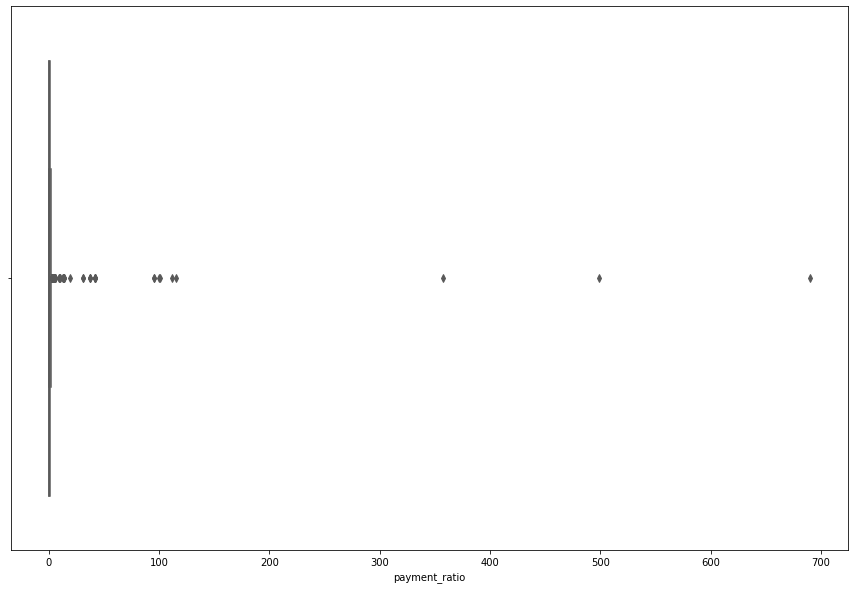

overlimit_percentage


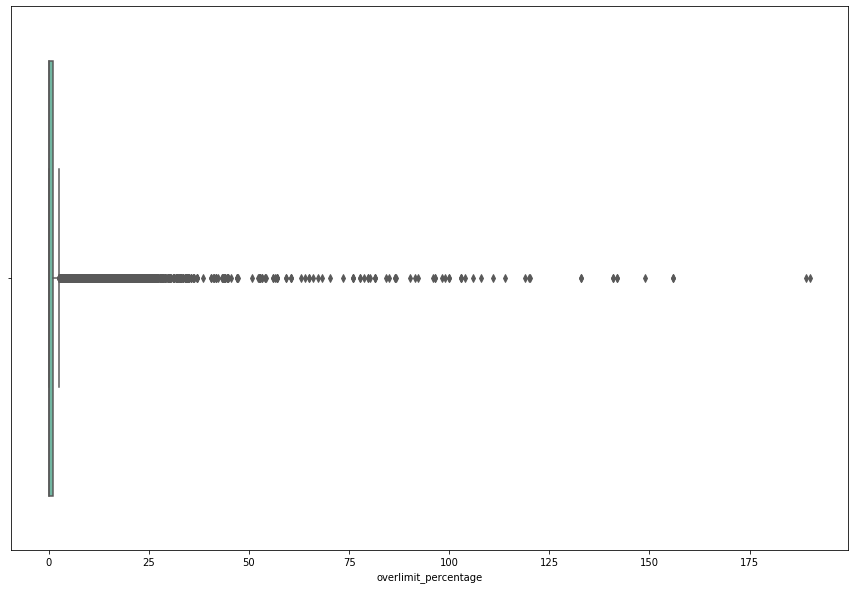

payment_ratio_3month


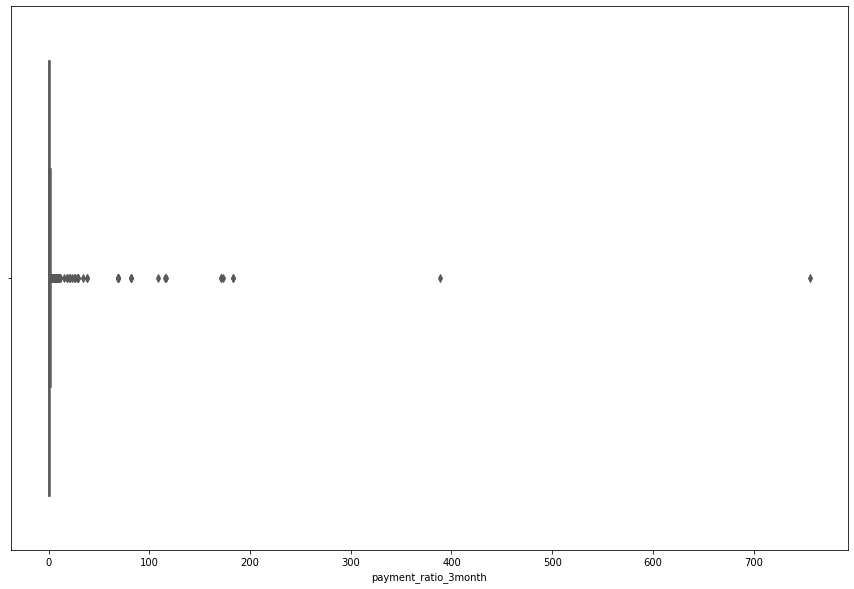

payment_ratio_6month


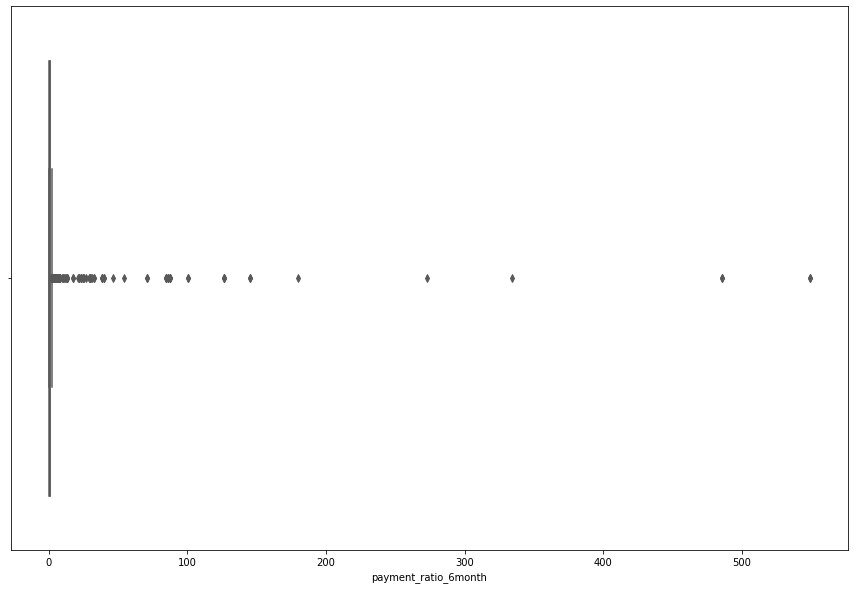

years_since_card_issuing


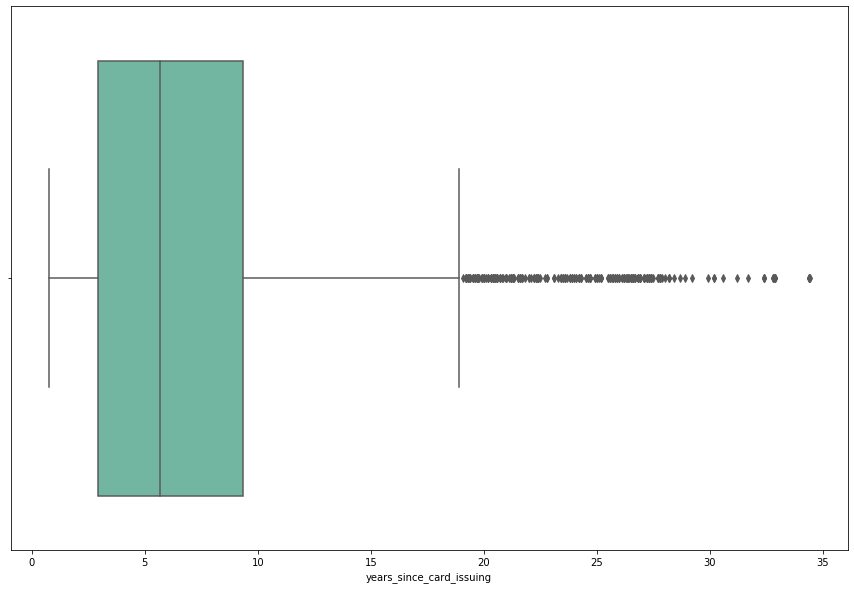

total_usage


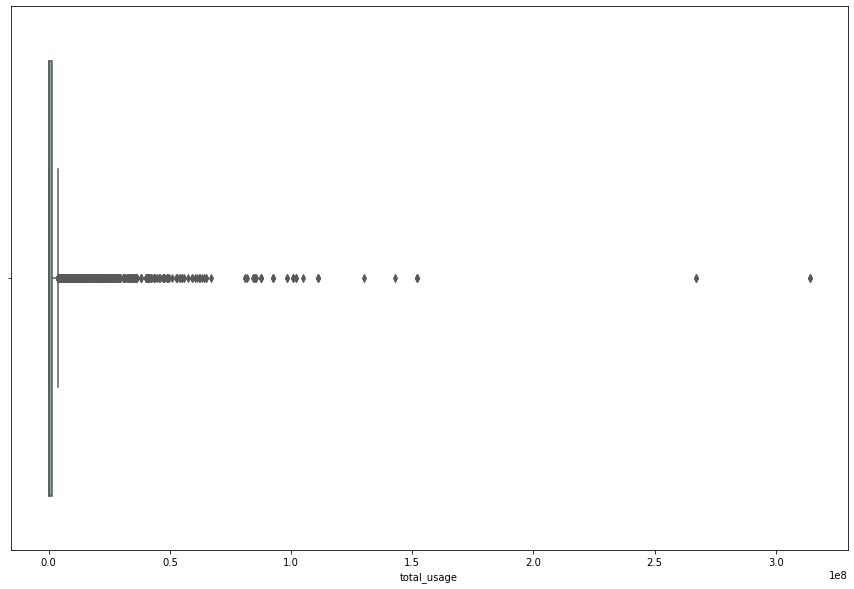

remaining_bill_per_number_of_cards


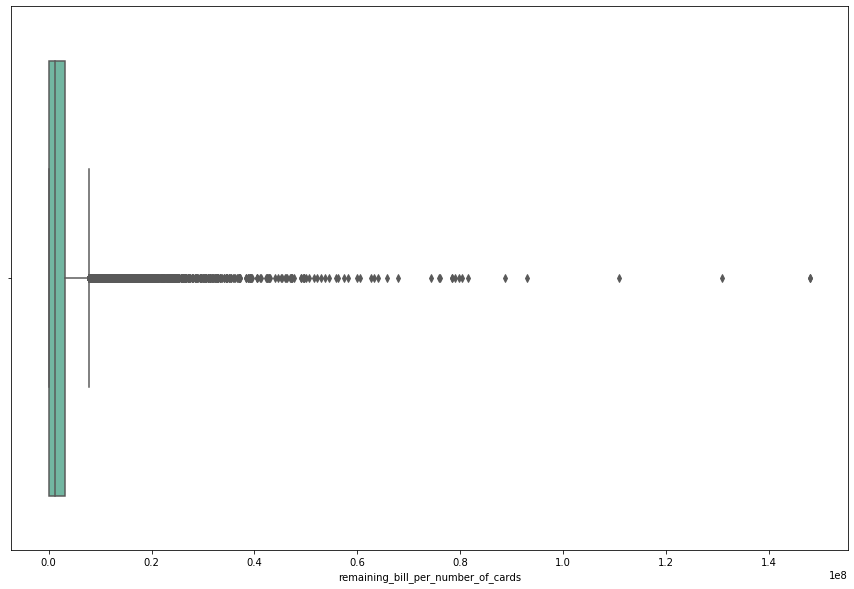

remaining_bill_per_limit


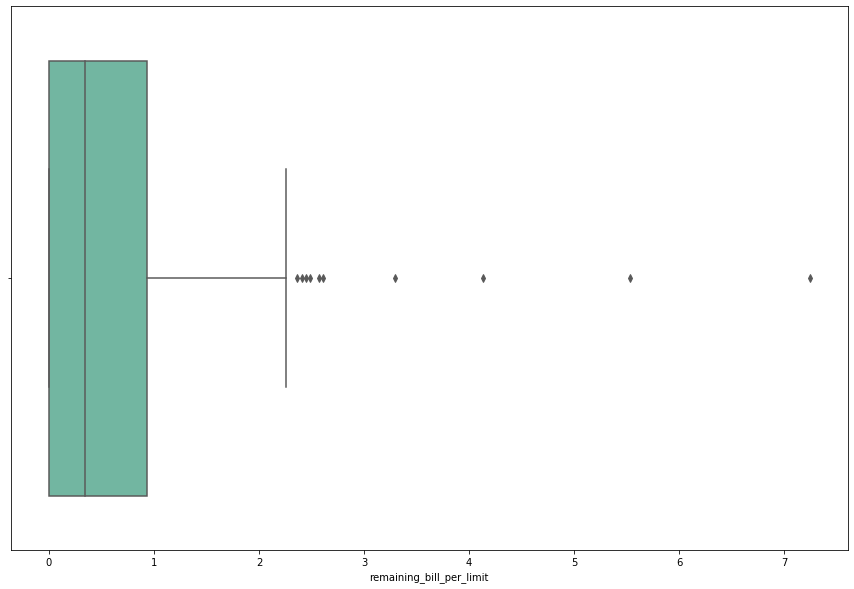

total_usage_per_limit


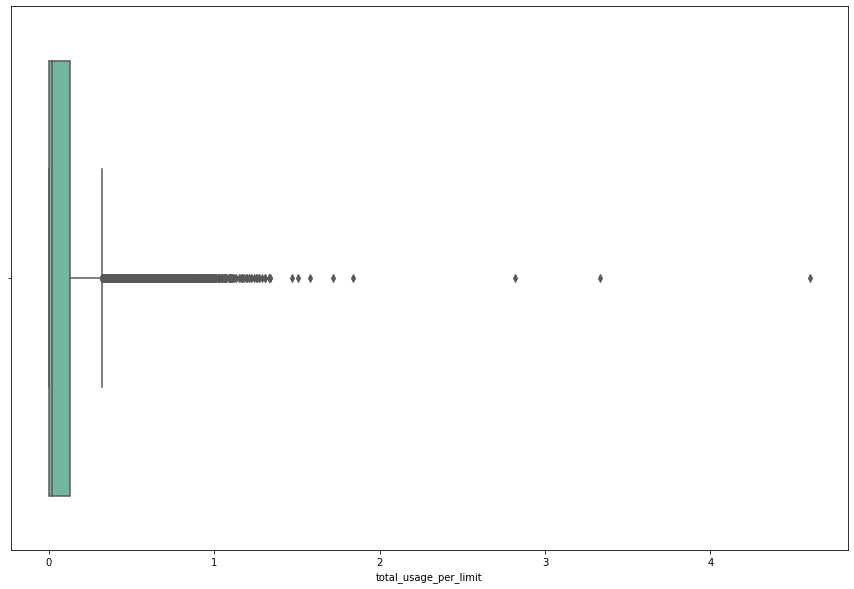

total_3mo_usage_per_limit


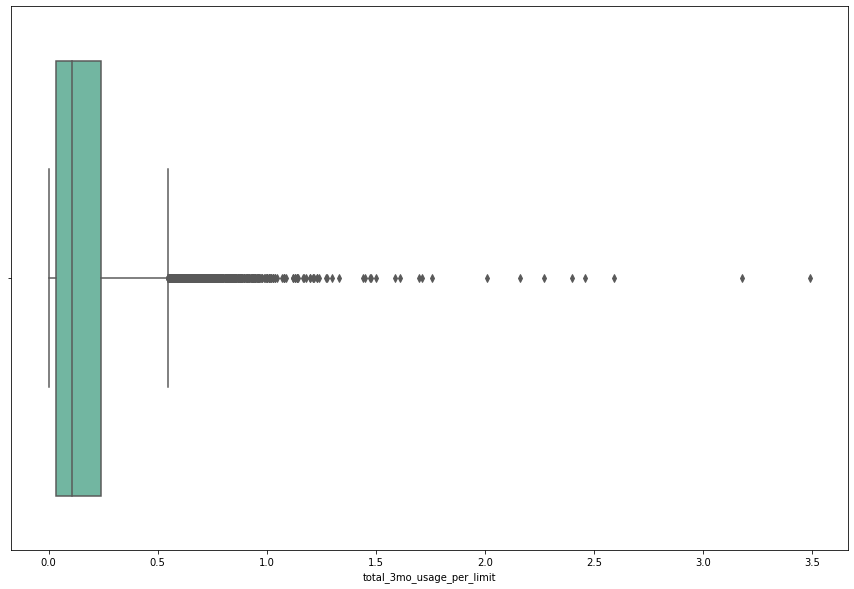

total_6mo_usage_per_limit


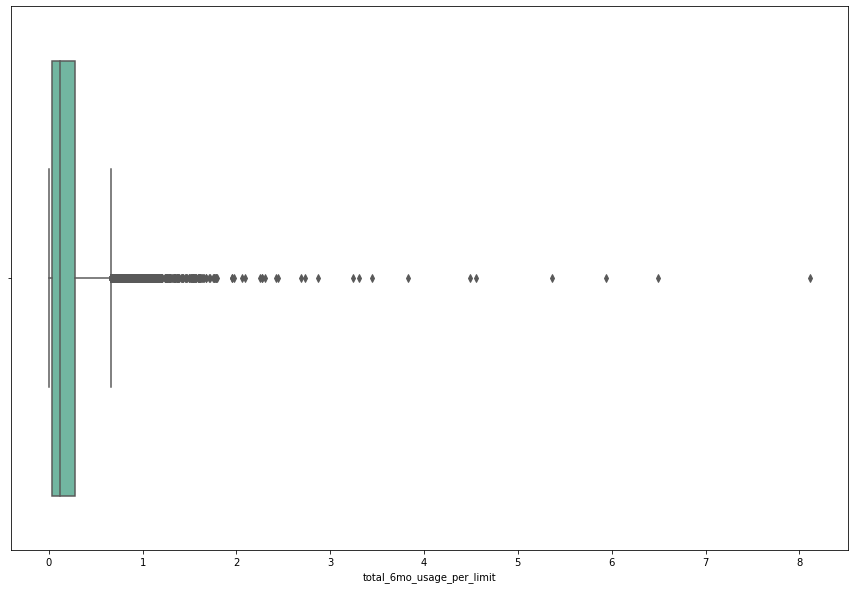

utilization_3month


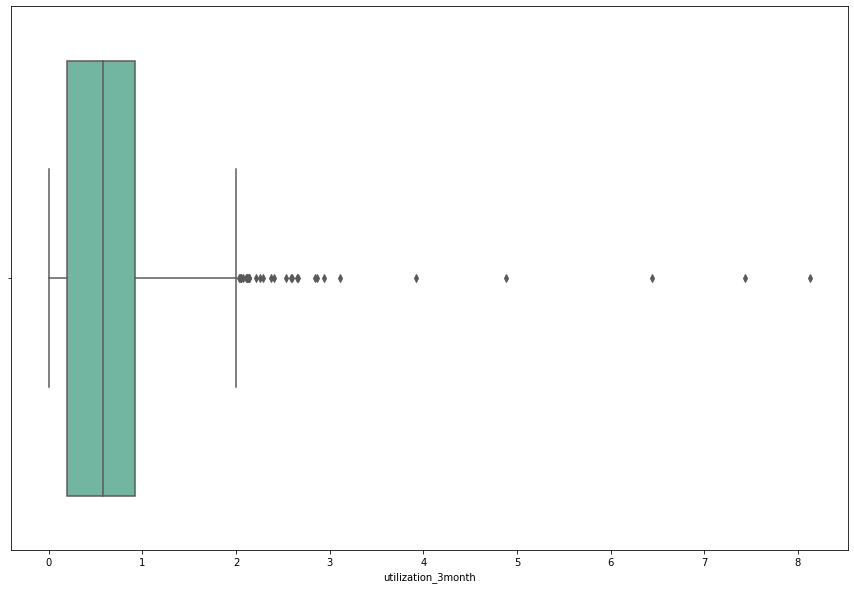

utilization_6month


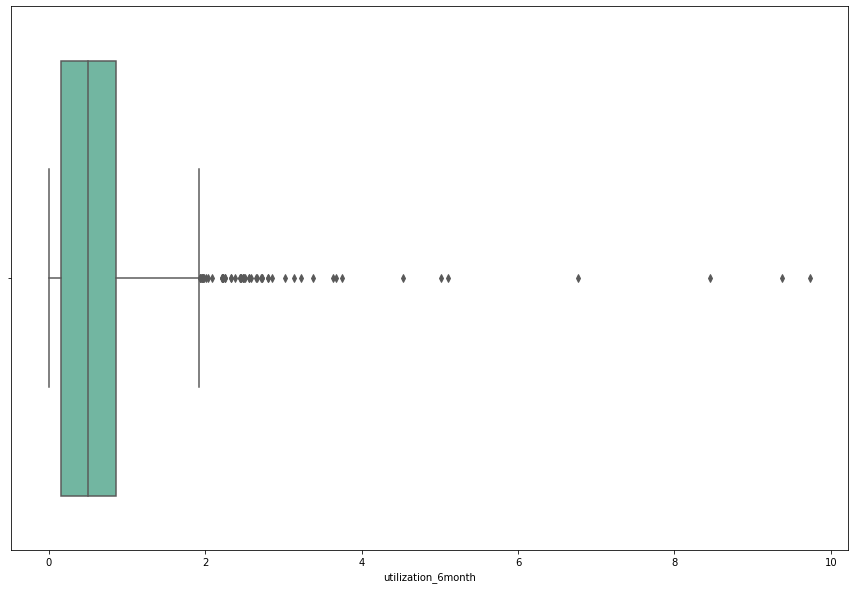

outstanding


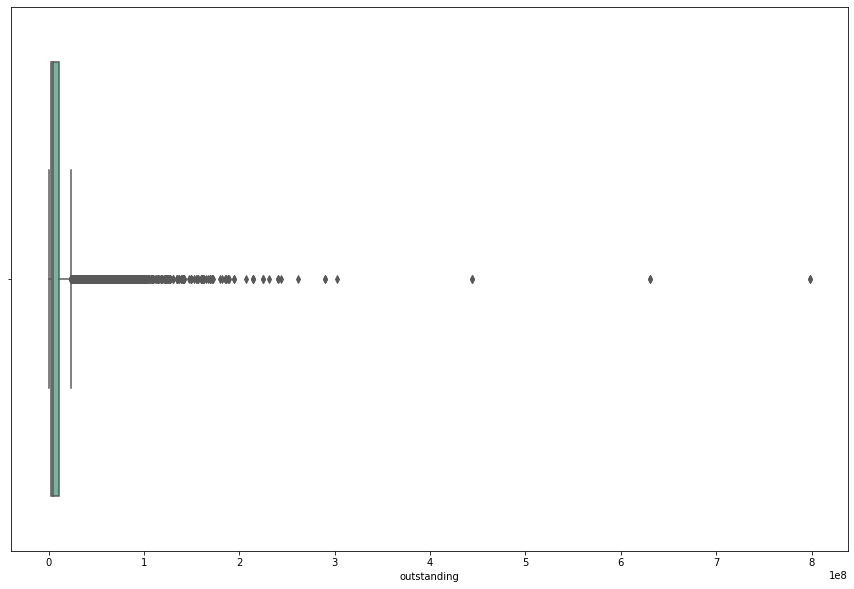

credit_limit


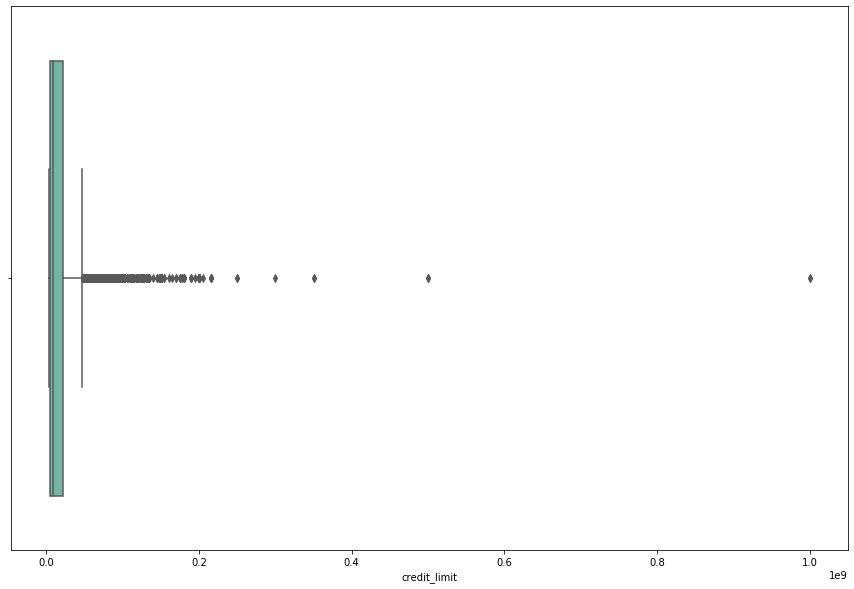

bill


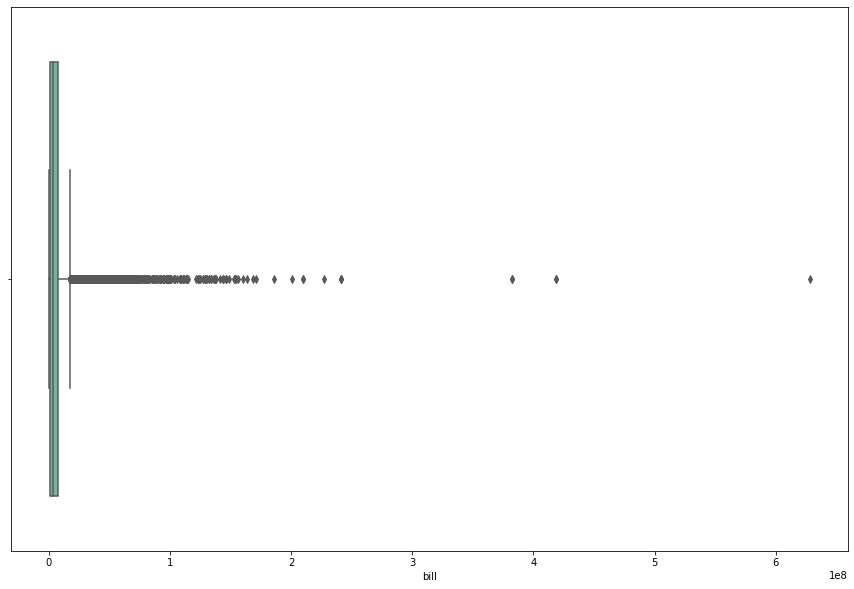

total_cash_usage


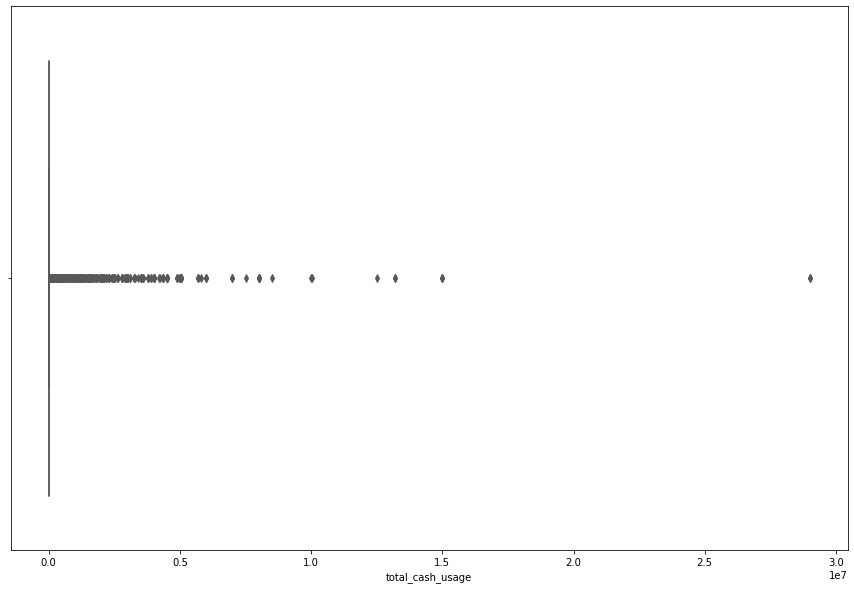

total_retail_usage


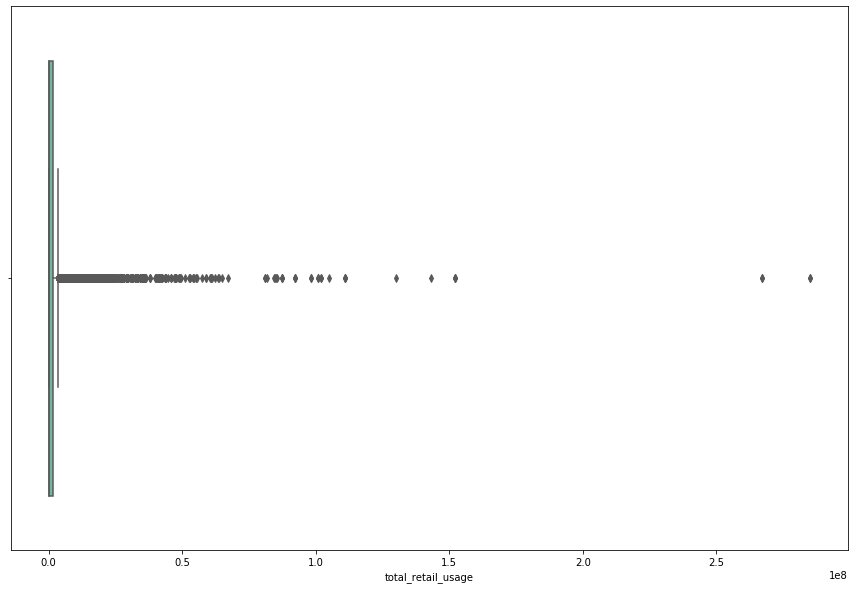

remaining_bill


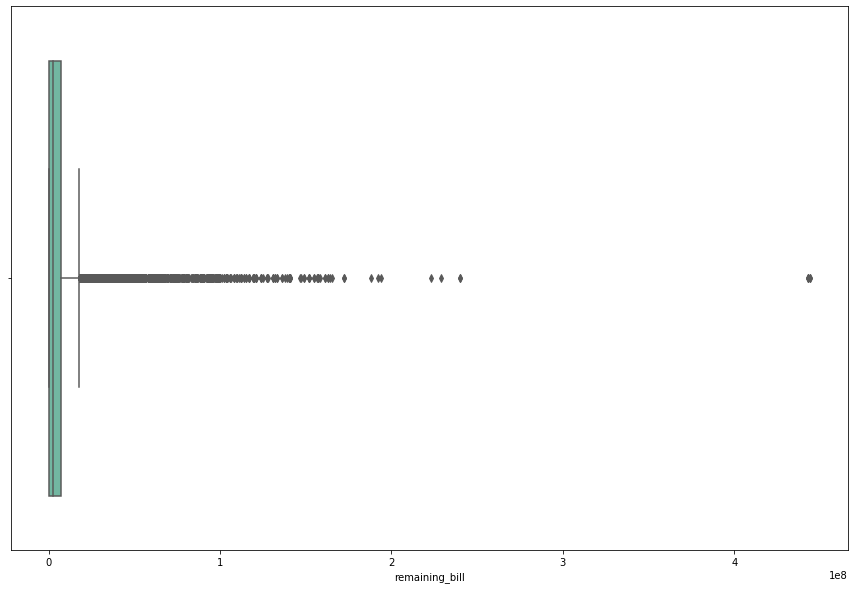

number_of_cards


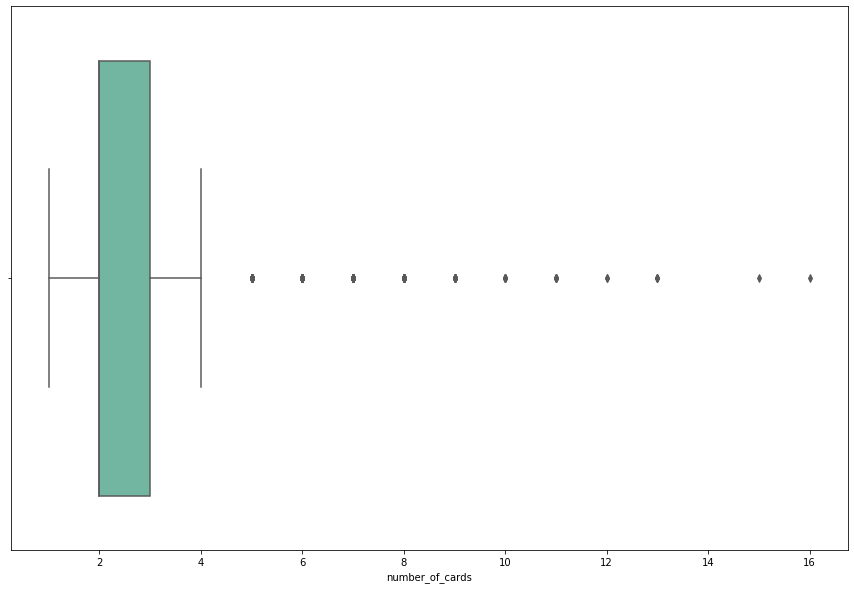

In [80]:
# Plotting Outliers for the columns
for column in column_names:
    if column not in ['index', 'X', 'x','branch_code', 'default_flag', 'delinquency_score']: #exclude these columns (exclude categorical ones)
        print(column)
        check_outlier(combined_df_filtered,column)
        print("="*90)

Taking into consideration the fact that total_usage = total_cash_usage + total_retail_usage. And also the fact that there are various other variables that might be be highly correlated. It might be worthwile at this point to check for highly correlated independent variables before proceeding with removing outliers.

In [83]:
not_columns = ['index', 'X', 'x', 'branch_code', 'default_flag', 'delinquency_score']
analysis_columns = filter(lambda x: x not in not_columns, column_names)
analysis_columns = list(analysis_columns)
print(analysis_columns)

['payment_ratio', 'overlimit_percentage', 'payment_ratio_3month', 'payment_ratio_6month', 'years_since_card_issuing', 'total_usage', 'remaining_bill_per_number_of_cards', 'remaining_bill_per_limit', 'total_usage_per_limit', 'total_3mo_usage_per_limit', 'total_6mo_usage_per_limit', 'utilization_3month', 'utilization_6month', 'outstanding', 'credit_limit', 'bill', 'total_cash_usage', 'total_retail_usage', 'remaining_bill', 'number_of_cards']


In [82]:
combined_df_filtered.describe()

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,...,X,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,index,number_of_cards,default_flag
count,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,1.538300e+04,1.538300e+04,...,15383.000000,1.538300e+04,1.538300e+04,1.538300e+04,1.538300e+04,1.538300e+04,1.538300e+04,15383.000000,15383.000000,15383.000000
mean,7806.472145,7807.472145,0.675246,3.326370,0.805775,1.005356,0.025873,6.627082,2.109289e+06,2.968680e+06,...,7807.472145,1.161373e+07,2.083004e+07,8.077919e+06,7.433428e+04,2.034954e+06,8.132641e+06,7806.472145,2.506143,0.088214
std,4510.302150,4510.302150,7.793450,9.149832,7.983123,9.886694,0.309947,4.670300,8.106937e+06,6.158413e+06,...,4510.302150,2.403501e+07,2.953005e+07,1.750352e+07,6.207031e+05,7.941572e+06,1.890345e+07,4510.302150,1.006195,0.283615
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000e+00,0.000000e+00,...,1.000000,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000
25%,3904.500000,3905.500000,0.000000,0.000000,0.208000,0.223000,0.000000,2.920000,0.000000e+00,0.000000e+00,...,3905.500000,2.033490e+06,5.000000e+06,8.331320e+05,0.000000e+00,0.000000e+00,0.000000e+00,3904.500000,2.000000,0.000000
50%,7803.000000,7804.000000,0.272000,0.000000,0.501000,0.660400,0.000000,5.666667,2.500000e+05,1.215126e+06,...,7804.000000,4.745436e+06,9.000000e+06,3.160704e+06,0.000000e+00,2.047240e+05,2.764663e+06,7803.000000,2.000000,0.000000
75%,11713.500000,11714.500000,1.000000,1.060000,0.920500,1.000000,0.000000,9.330000,1.522000e+06,3.101587e+06,...,11714.500000,1.069365e+07,2.200000e+07,7.454386e+06,0.000000e+00,1.414508e+06,7.179955e+06,11713.500000,3.000000,0.000000
max,15642.000000,15643.000000,689.830000,190.000000,755.750000,548.990000,5.000000,34.416667,3.140000e+08,1.480000e+08,...,15643.000000,7.980586e+08,1.000000e+09,6.280000e+08,2.900000e+07,2.850000e+08,4.440000e+08,15642.000000,16.000000,1.000000


### Highly Correlated Variables

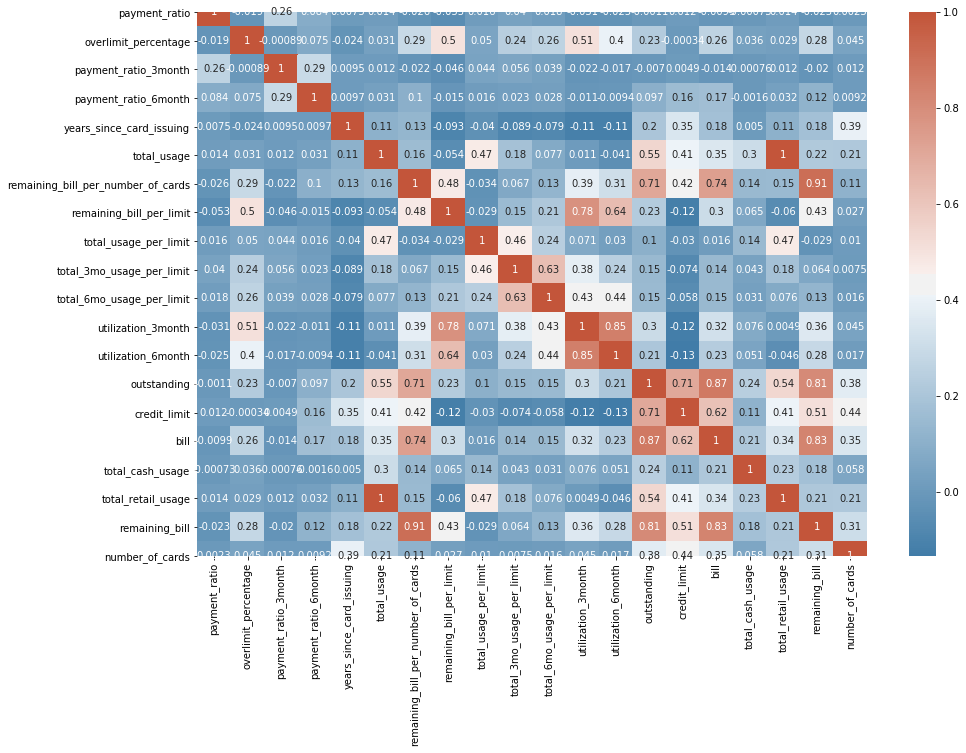

In [84]:
#Plot SNS heatmap of continuous variables 
# use heatmap because its easier
corr = combined_df_filtered[analysis_columns].corr() 

# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(corr, dtype=np.bool))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(600, 200, as_cmap=True)
cmap = sns.diverging_palette(600, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, cmap= cmap)

Strong correlation is observed between:
* total_usage and total_retail_usage
* remaining_bill_per_number_of_cards and remaining_bill
* outstanding and bill, outstanding and remaining_bill, bill and remaining_bill
* utilization_3month and utilization_6month, utilization_3month and remaining_bill_per_limit


Variables to drop:
- total_usage -> because it is total_cash_usage + total_retail_usage
- bill and remaining_bill -> because they are highly correlated with outstanding, and each other
- utilization_3month -> because utilization 6 month captures this information as well

In [85]:
combined_df_dropped = combined_df_filtered.drop(['total_usage', 'bill', 'remaining_bill', 'utilization_3month'],axis=1)

In [86]:
column_names_dropped = combined_df_dropped.columns
analysis_columns2 = filter(lambda x: x not in not_columns, column_names_dropped)
analysis_columns2 = list(analysis_columns2)

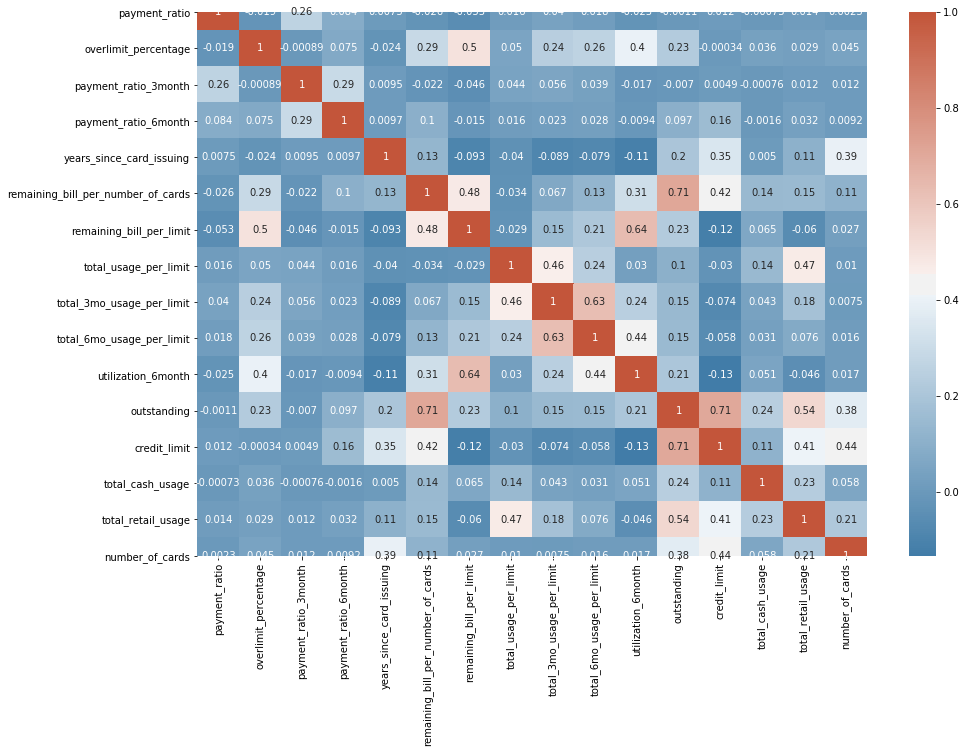

In [87]:
#Plot SNS heatmap of continuous variables -> to verify dropped columns
# use heatmap because its easier
corr = combined_df_dropped[analysis_columns2].corr() 

# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(corr, dtype=np.bool))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(600, 200, as_cmap=True)
cmap = sns.diverging_palette(600, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, cmap= cmap)

### Outlier Removal

Removing Outliers

Before removing outliers, several considerations must be made such as:
- Does it reflect the target population/subject area?
- Did this measurement happen due to something out of the norm?
- Or maybe the outlier is just a natural occurence of the data?
Because, in some cases, outliers could actually capture something that is valuable to our study area. Removing these might actually make the data non-representative of the real-life population.

In [90]:

combined_df_dropped.head(5) #checking the filtered and dropped dataframe

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,remaining_bill_per_number_of_cards,remaining_bill_per_limit,...,X,outstanding,credit_limit,total_cash_usage,total_retail_usage,index,x,number_of_cards,branch_code,default_flag
0,0,1,1.0219,0.0,0.7478,1.0000,0.0,15.416667,13161.5,0.003760,...,1,36158,7000000.0,0.0,94.0,0,1-a,2,I,0
1,1,2,0.0000,0.0,0.0000,0.0000,0.0,0.750000,0.0,0.000000,...,2,268691,10000000.0,0.0,1012.0,1,2-a,2,A,0
2,2,3,1.0000,0.0,1.0000,1.0091,0.0,10.750000,0.0,0.000000,...,3,6769149,28000000.0,0.0,0.0,2,3-a,3,A,0
3,3,4,1.0000,0.0,0.2501,0.2264,0.0,19.750000,145333.5,0.027683,...,4,3496732,21000000.0,0.0,2536660.0,3,4-a,4,G,0
4,4,5,0.9599,0.0,0.9749,0.9984,0.0,1.666667,2975932.5,0.595186,...,5,9402085,10000000.0,0.0,2666558.0,4,5-a,2,A,0


Credit cards are regulated by the Central Bank of Indonesia. They have published an extensive set of rules regarding transactions, credit limits, no. of credit cards per user, age, etc.
Thus, before moving on to actually removing the outliers, here is an extensive explanation about the outliers in this data based on research about credit card limit and usage by BI (Bank of Indonesia):
1. `payment_ratio` (including `3_months and 6 months`) outliers contain many erroneous measurements, and they should be removed. For instance, the jump from 1 at the 75% percentile to almost 700 at max is simply too extreme. It is doubtful that any user would pay almost 700x their credit bills. Outliers here will be removed
2. `overlimit_percentage` also contains erroneous outliers, the jump from 1 at 75% to 190 is too extreme. It is doubted that any kind of bank/lender would let a user go over the limit by more than double. Moreover, there usually is a fee for going over the limit, and BI regulates this fee to not go over a certain amount. Thus, outliers here will definitely be removed.  
3. `years_since_card_issuing` represents the years since a first credit card was issued to this customer. Typically, credit cards last for 5 years. The outliers here seem to be due to some kind of measurement error or perhaps the data for an old user was not updated. Therefore, outliers here will be removed.
4. `remaining_bill_per_number_of_cards` and `number_of_cards`, the average Indonesian person probably wont have more than 3 credit cards at a time. This takes into account that the more credit card one user has, the stricter a bank will issue new credit card for that user. Moreover, BI also regulates that users with an income of <10 million IDR/mont should only have 2 credit cards.
Therefore, outliers here will be removed.
5. `total_retail_usage`, `total_cash_usage`, `credit_limit` and other money related values are most likely measurement errors, as mentioned above, the average user shouldnt have that many credit cards. Transactions here seem to be related to the number of cards. Therefore, outliers here will be removed.
6. `delinquency_score` is an ordinal variable denoting the score of users from 0 to 5. This should be excluded from the outlier variables that will be removed.

In short, based on observations and assumptions about how the data works, outliers in this data are **not beneficial** to the analysis as they **don't reflect the population to be studied**. Moreover, most of them are very likely to be not a natural occurence of the data such as errors.

In [91]:
#variables to be checked outliers from:
analysis_columns2


['payment_ratio',
 'overlimit_percentage',
 'payment_ratio_3month',
 'payment_ratio_6month',
 'years_since_card_issuing',
 'remaining_bill_per_number_of_cards',
 'remaining_bill_per_limit',
 'total_usage_per_limit',
 'total_3mo_usage_per_limit',
 'total_6mo_usage_per_limit',
 'utilization_6month',
 'outstanding',
 'credit_limit',
 'total_cash_usage',
 'total_retail_usage',
 'number_of_cards']

Normality Test for the Data:
    
Here, I run a normality test, to choose which method to remove the outliers:
    1. z-score if the data is normal
    2. Interquartile range if the data is not normal

In [92]:
for item in analysis_columns2:
    print(scipy.stats.shapiro(combined_df_dropped[item]))

(0.019310951232910156, 0.0)
(0.3945842385292053, 0.0)
(0.023109734058380127, 0.0)
(0.027933359146118164, 0.0)
(0.9000763297080994, 0.0)
(0.47169703245162964, 0.0)
(0.8369755148887634, 0.0)
(0.5967735052108765, 0.0)
(0.7664951086044312, 0.0)
(0.6494638919830322, 0.0)
(0.8661025762557983, 0.0)
(0.42054998874664307, 0.0)
(0.5809118747711182, 0.0)
(0.09578144550323486, 0.0)
(0.22304099798202515, 0.0)
(0.583236038684845, 0.0)


/home/mahdiazhari/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Based on the shapiro-wilks test, the data does not come from a normal distribution. It is also known that the data is skewed heavily to the right. Thus, the IQR outlier removal method will be used.

#### Removing Outliers Based on IQR
Outliers will be removed based on the `1.5 * IQR (Inter-Quartile Range) criteria`.
Firstly, the IQR is selected instead of z-score due to IQR's less sensitivity to extreme values. Moreover, IQR is more robust since it does not have any underlying assumptions about the distribution of the data. 
The data is not normally distributed, thus the IQR is preferred. 

In [94]:
combined_df_dropped.head()

,index,X,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,years_since_card_issuing,remaining_bill_per_number_of_cards,remaining_bill_per_limit,...,X,outstanding,credit_limit,total_cash_usage,total_retail_usage,index,x,number_of_cards,branch_code,default_flag
0,0,1,1.0219,0.0,0.7478,1.0000,0.0,15.416667,13161.5,0.003760,...,1,36158,7000000.0,0.0,94.0,0,1-a,2,I,0
1,1,2,0.0000,0.0,0.0000,0.0000,0.0,0.750000,0.0,0.000000,...,2,268691,10000000.0,0.0,1012.0,1,2-a,2,A,0
2,2,3,1.0000,0.0,1.0000,1.0091,0.0,10.750000,0.0,0.000000,...,3,6769149,28000000.0,0.0,0.0,2,3-a,3,A,0
3,3,4,1.0000,0.0,0.2501,0.2264,0.0,19.750000,145333.5,0.027683,...,4,3496732,21000000.0,0.0,2536660.0,3,4-a,4,G,0
4,4,5,0.9599,0.0,0.9749,0.9984,0.0,1.666667,2975932.5,0.595186,...,5,9402085,10000000.0,0.0,2666558.0,4,5-a,2,A,0


In [95]:
not_columns = ['index', 'X', 'x', 'branch_code', 'default_flag', 'delinquency_score']
def remove_outlier_iqr(df, cols, ignore_cols, threshold): #where threshold is the constant that is multiplied with the IQR (1.5 here)
    temp_df = df.copy()
    temp_df = temp_df[cols]
    Q1 = temp_df.quantile(0.25)
    Q3 = temp_df.quantile(0.75)
    IQR = Q3 - Q1
    temp_df_out = temp_df[~((temp_df < (Q1 - threshold * IQR)) |(temp_df > (Q3 + threshold * IQR))).any(axis=1)]
    temp_df_out = temp_df_out.merge(df[ignore_cols], left_index=True, right_index=True)
    return temp_df_out

fixed_df = remove_outlier_iqr(combined_df_dropped, analysis_columns2, not_columns, 1.5)

In [96]:
fixed_df.describe()

,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,years_since_card_issuing,remaining_bill_per_number_of_cards,remaining_bill_per_limit,total_usage_per_limit,total_3mo_usage_per_limit,total_6mo_usage_per_limit,...,total_cash_usage,total_retail_usage,number_of_cards,index,index,index,X,X,default_flag,delinquency_score
count,7461.00000,7461.000000,7461.000000,7461.000000,7461.000000,7.461000e+03,7461.000000,7461.000000,7461.000000,7461.000000,...,7461.0,7.461000e+03,7461.000000,7461.000000,7461.000000,7461.000000,7461.000000,7461.000000,7461.000000,7461.000000
mean,0.49218,0.058229,0.535816,0.593634,5.746863,1.190503e+06,0.322801,0.043900,0.100540,0.126649,...,0.0,3.874023e+05,2.219810,7760.632489,7760.632489,7760.632489,7761.632489,7761.632489,0.073449,0.031631
std,0.47773,0.318635,0.366513,0.404821,3.714630,1.617503e+06,0.364694,0.070115,0.108093,0.142279,...,0.0,6.542545e+05,0.517458,4555.069070,4555.069070,4555.069070,4555.069070,4555.069070,0.260889,0.343951
min,0.00000,0.000000,0.000000,0.000000,0.750000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.00000,0.000000,0.204000,0.200000,2.750000,0.000000e+00,0.000000,0.000000,0.013600,0.012900,...,0.0,0.000000e+00,2.000000,3798.000000,3798.000000,3798.000000,3799.000000,3799.000000,0.000000,0.000000
50%,0.28400,0.000000,0.500000,0.598000,5.170000,4.628710e+05,0.142000,0.004000,0.065300,0.075800,...,0.0,4.550000e+04,2.000000,7723.000000,7723.000000,7723.000000,7724.000000,7724.000000,0.000000,0.000000
75%,1.00000,0.000000,0.862000,1.000000,7.920000,1.846563e+06,0.658297,0.062000,0.154000,0.195000,...,0.0,5.020000e+05,2.000000,11772.000000,11772.000000,11772.000000,11773.000000,11773.000000,0.000000,0.000000
max,2.44000,2.650000,1.954100,2.160000,18.800000,7.743339e+06,1.590000,0.320000,0.544000,0.662247,...,0.0,3.533381e+06,4.000000,15641.000000,15641.000000,15641.000000,15642.000000,15642.000000,1.000000,5.000000


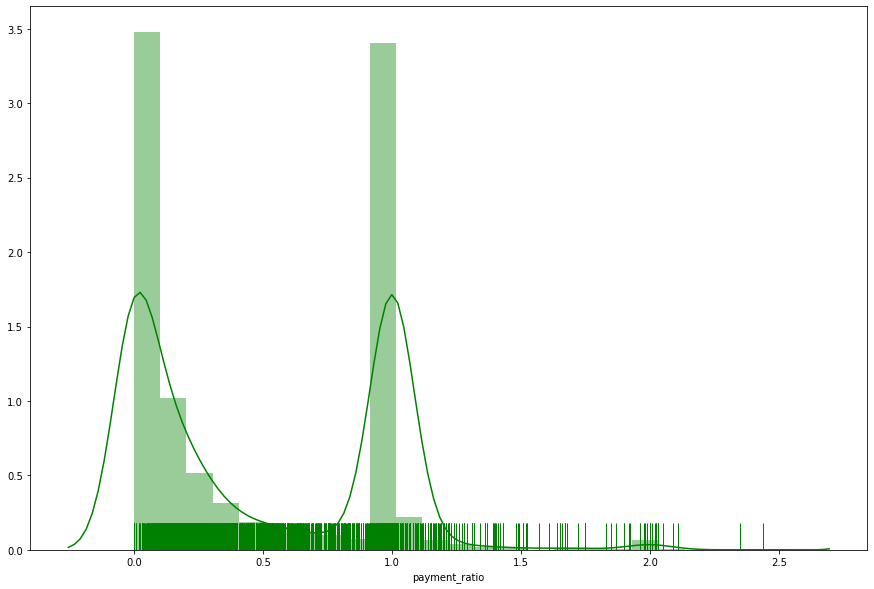

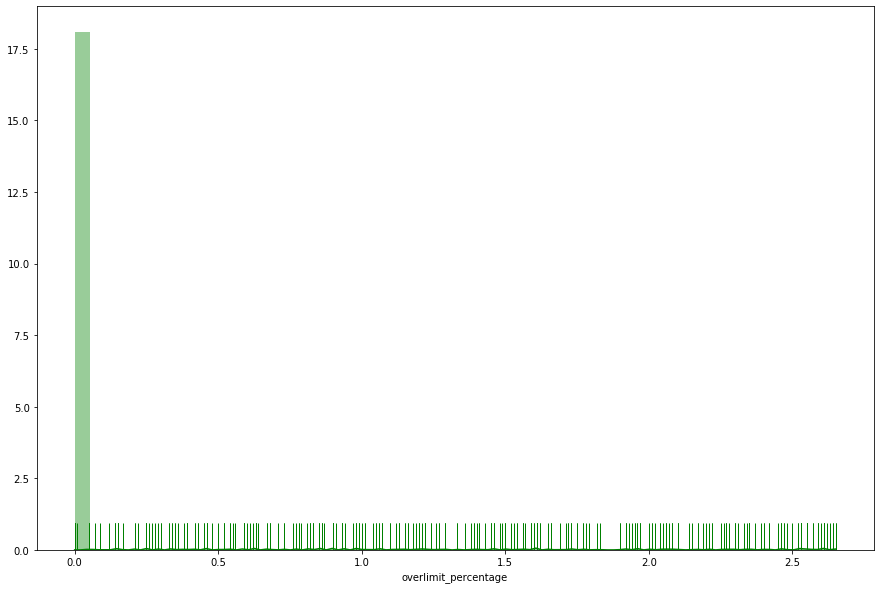

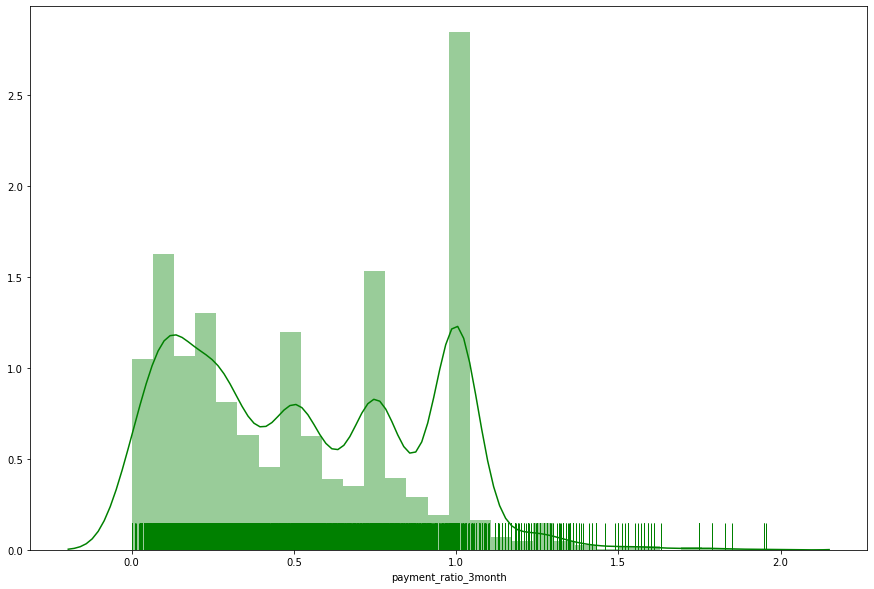

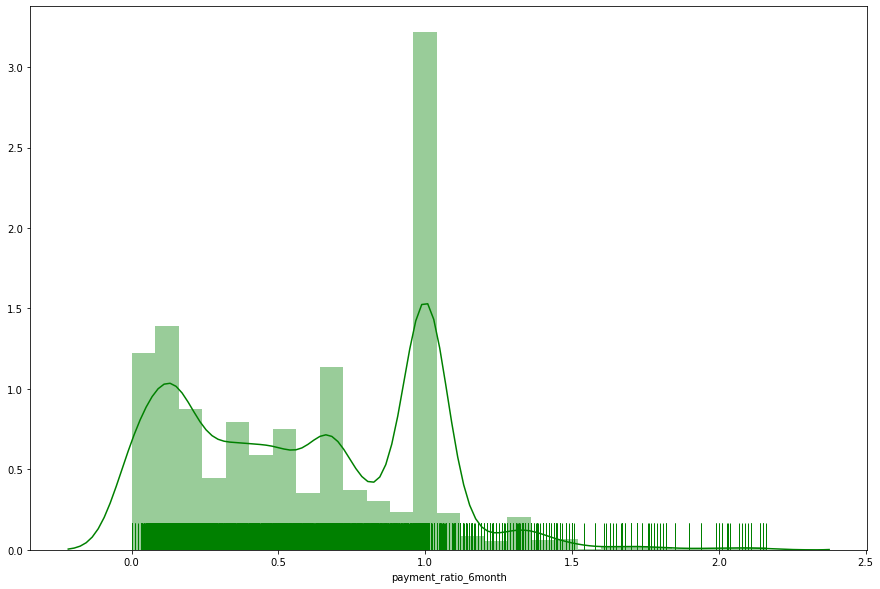

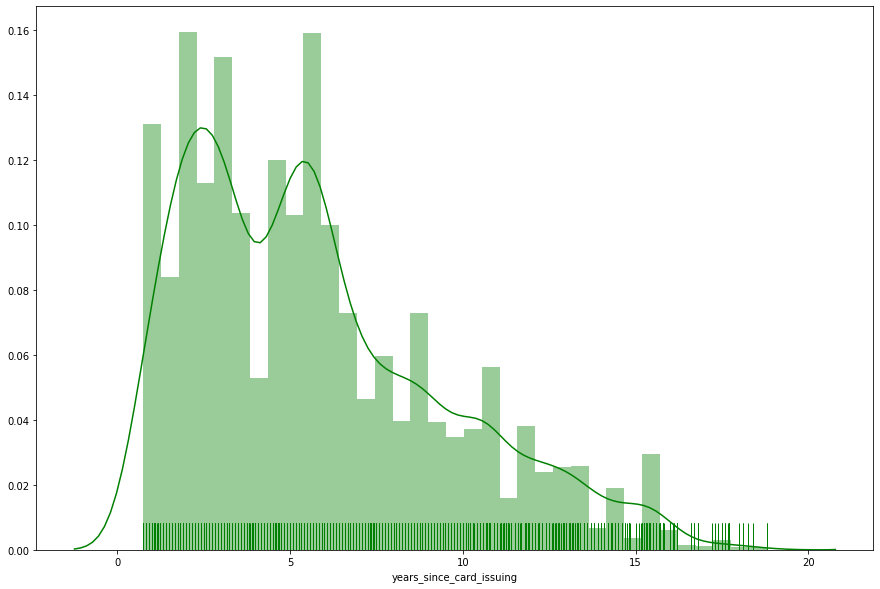

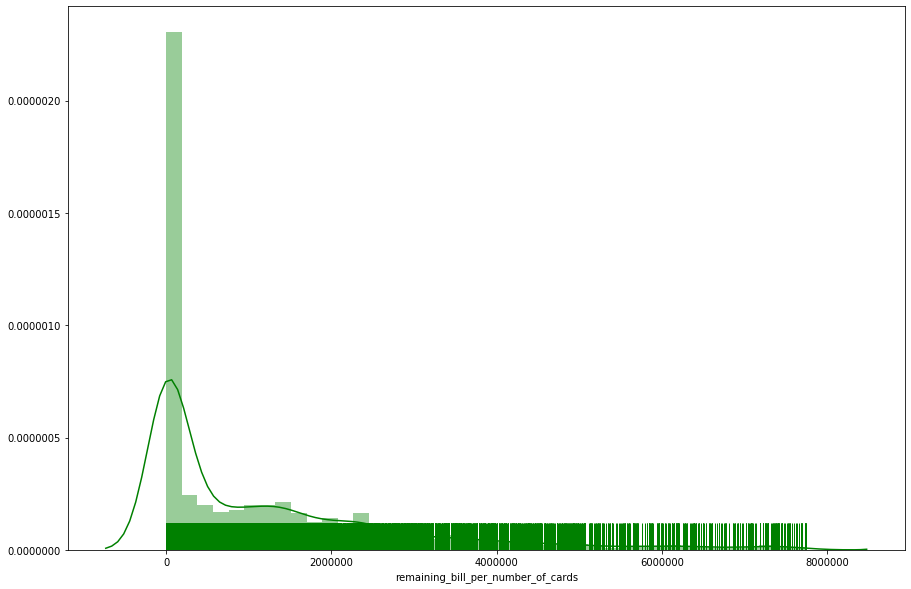

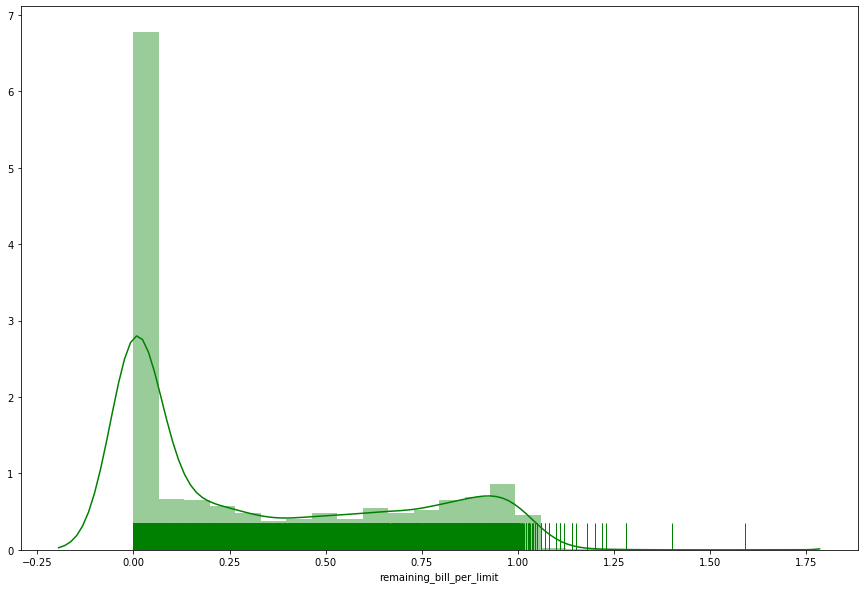

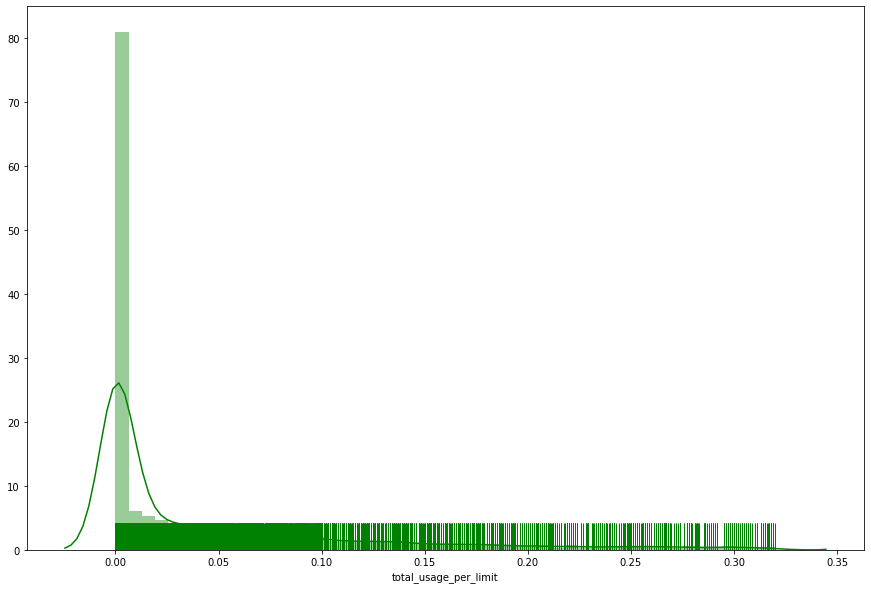

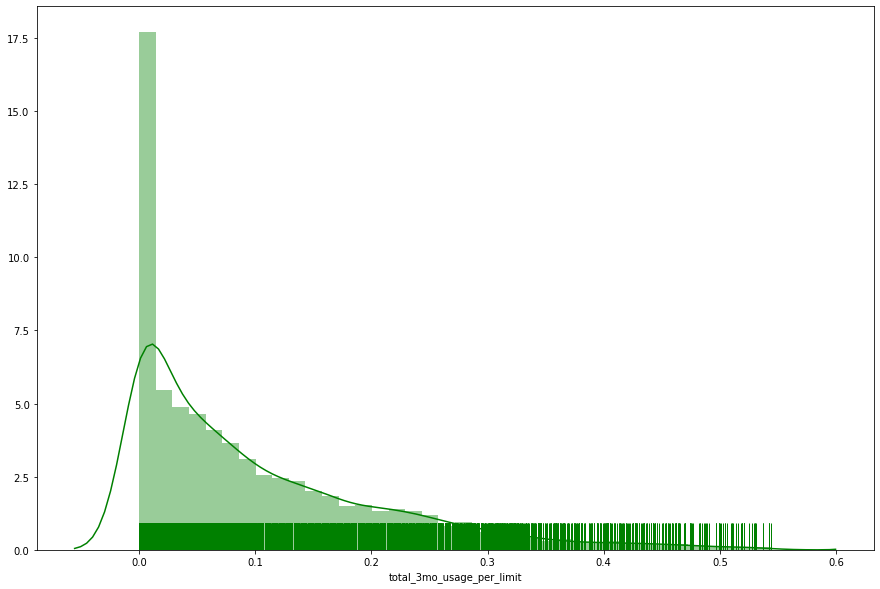

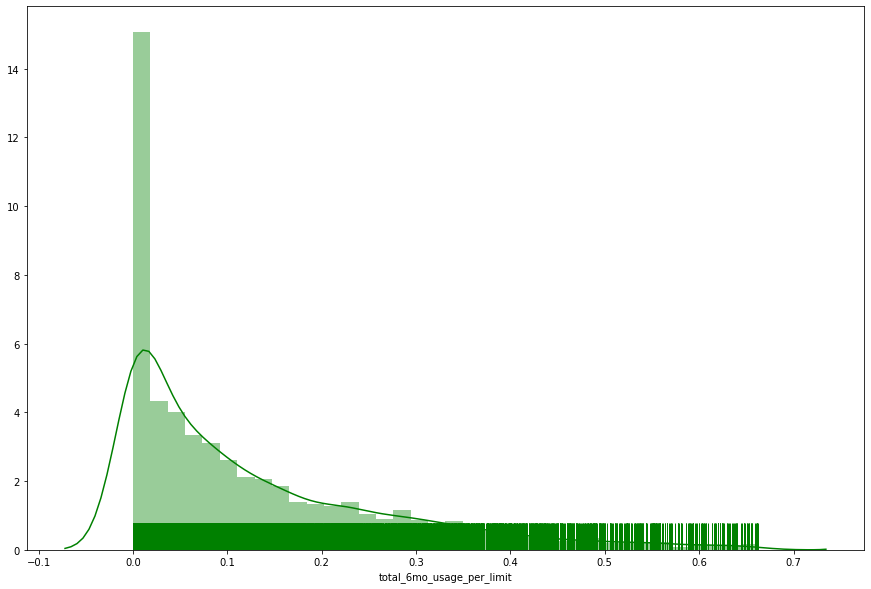

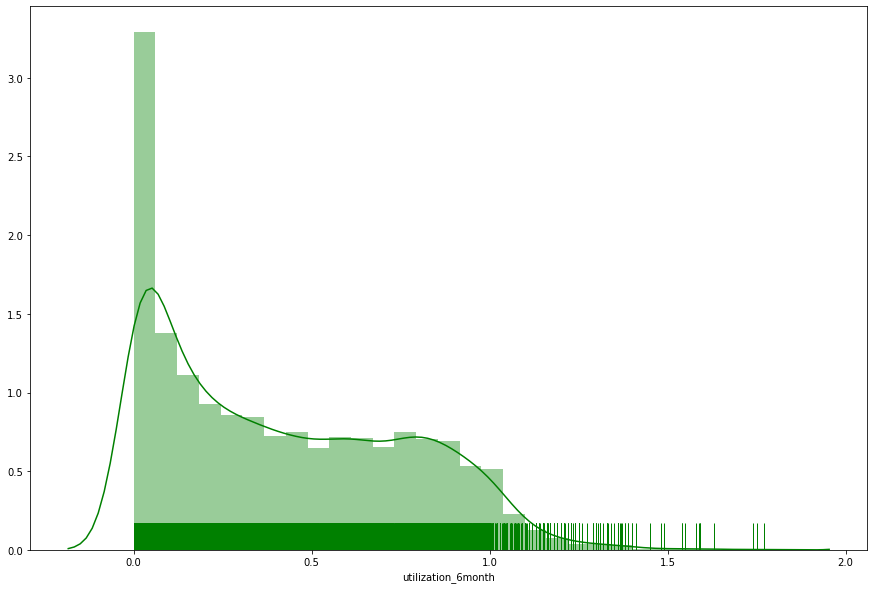

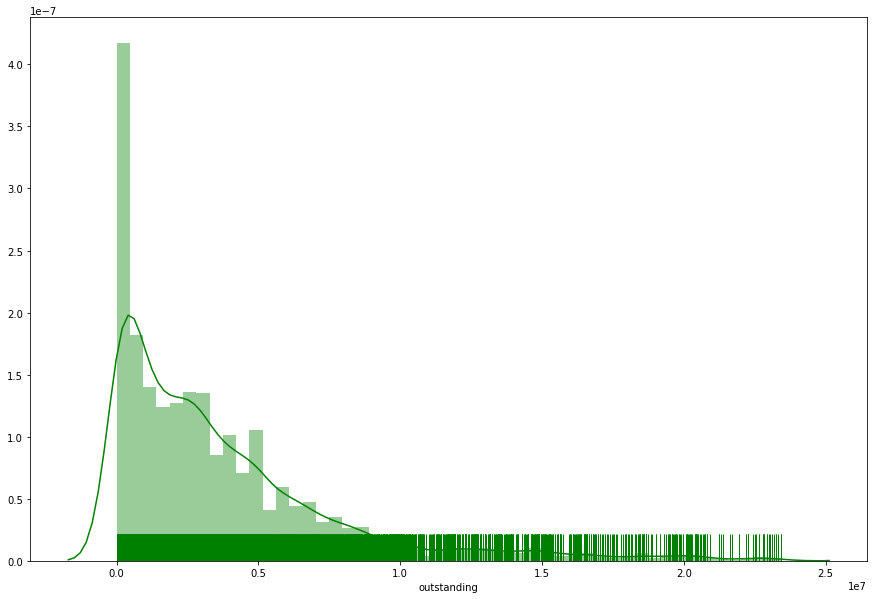

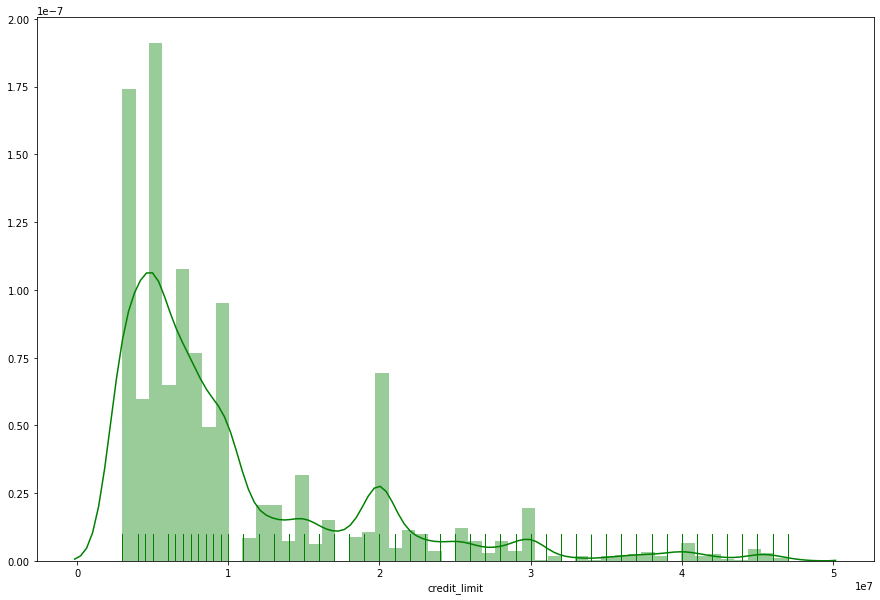

/home/mahdiazhari/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/mahdiazhari/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


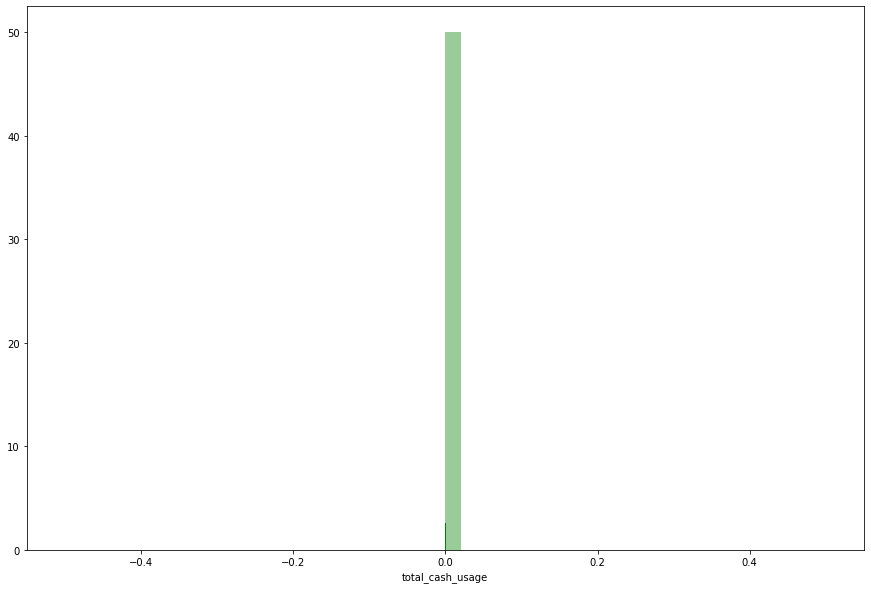

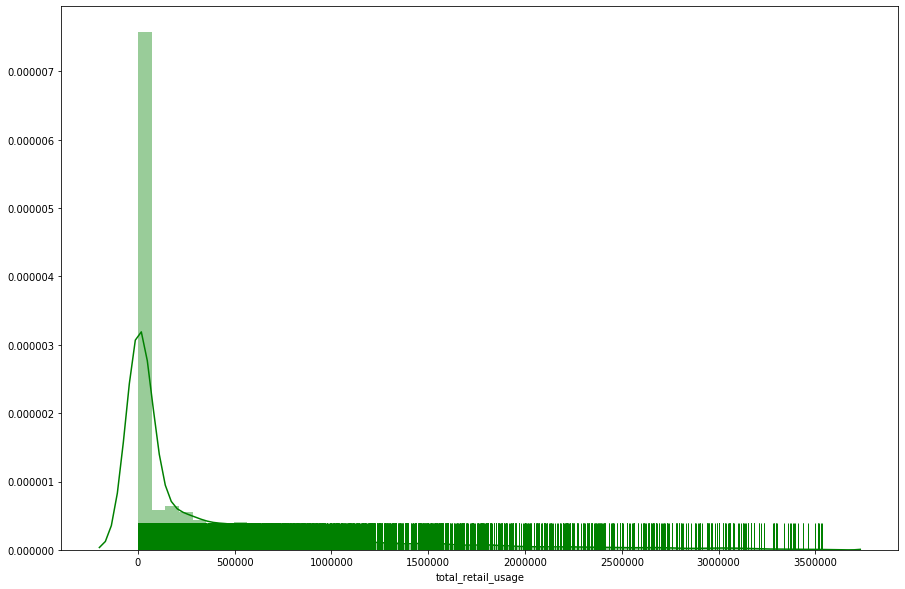

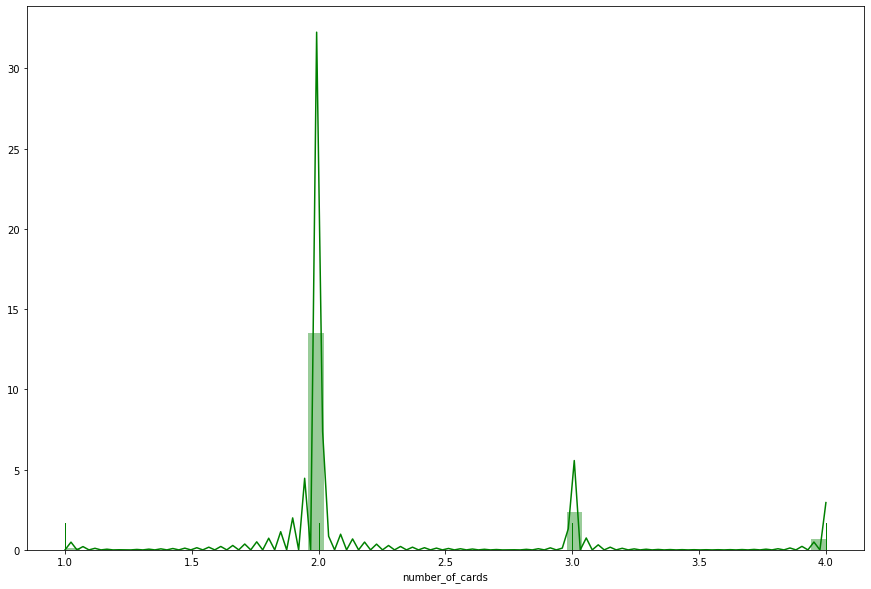

In [97]:
#Function to show the histograms of each numerical values
def show_histogram(df, col):
    plt.figure(figsize=(15,10))
    sns.distplot(df[col], hist=True, rug=True, color='g')
    plt.show()

for col in analysis_columns2:
    show_histogram(fixed_df, col)

In [98]:
fixed_df = fixed_df.drop(['index'],axis=1) #drop the index columns
# Check total number of remaining rows in the data and number of default_users vs non_default_users
print(fixed_df['default_flag'].count()) #Total number of rows after removing outliers
print(fixed_df['default_flag'].value_counts()) #Number of users who default vs who don't default

7461
0    6913
1     548
Name: default_flag, dtype: int64


payment_ratio


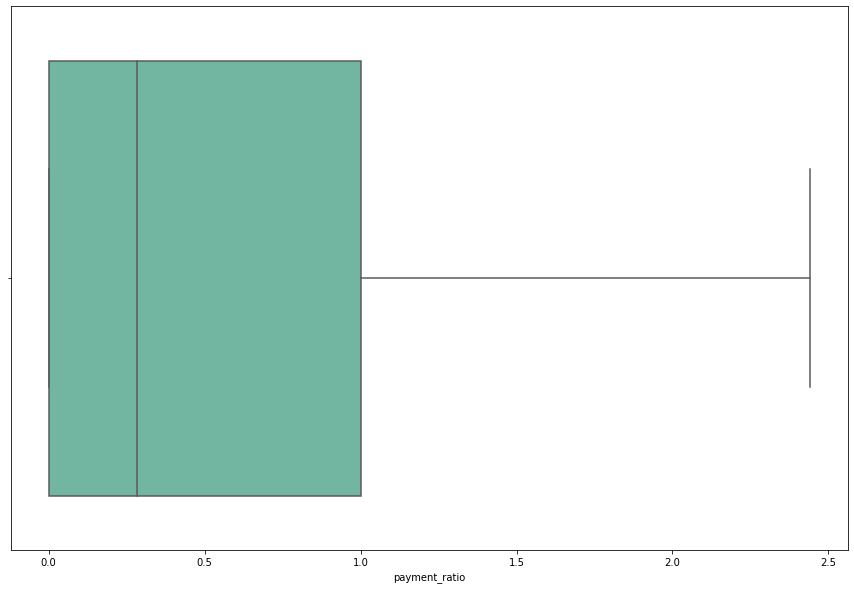

overlimit_percentage


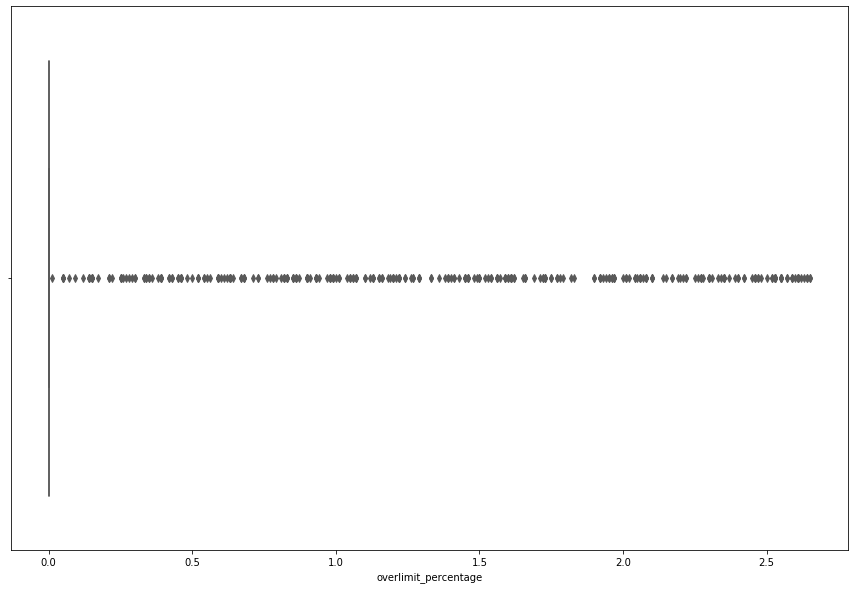

payment_ratio_3month


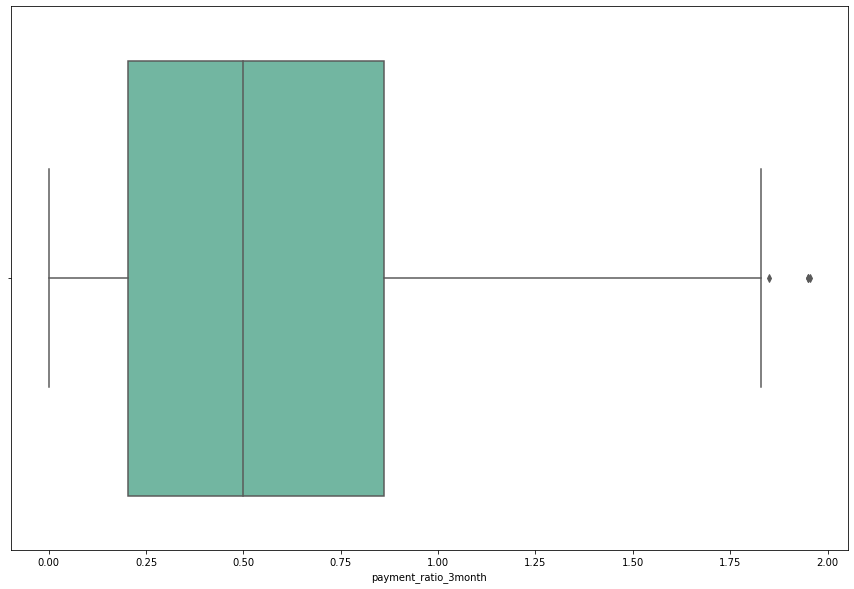

payment_ratio_6month


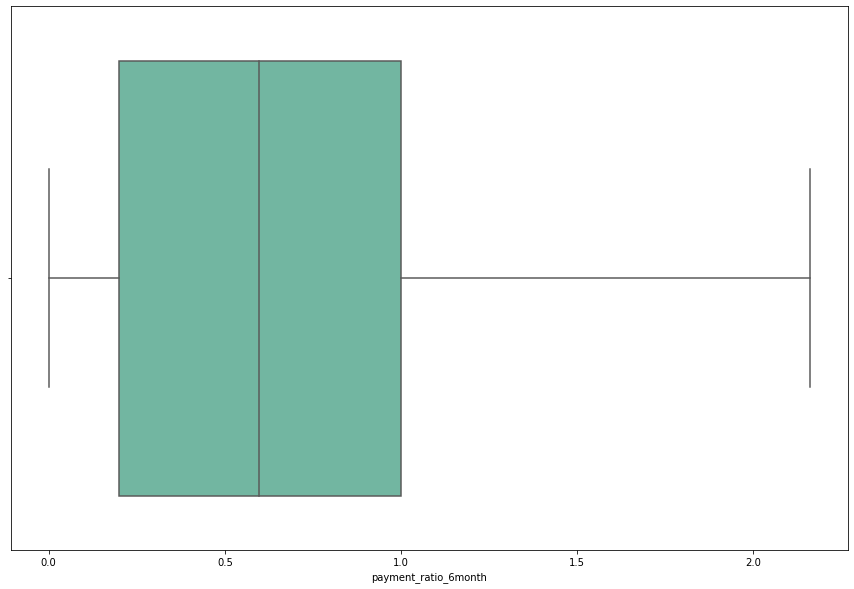

years_since_card_issuing


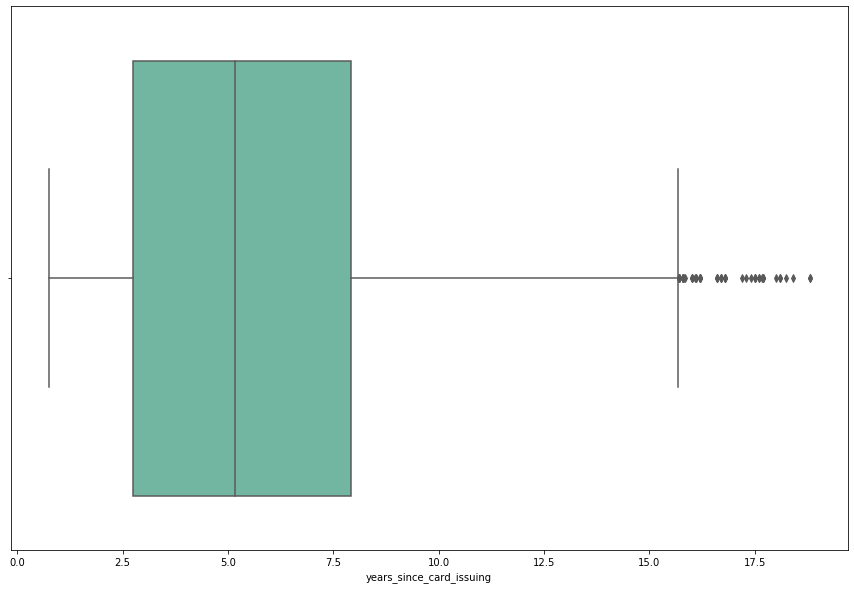

remaining_bill_per_number_of_cards


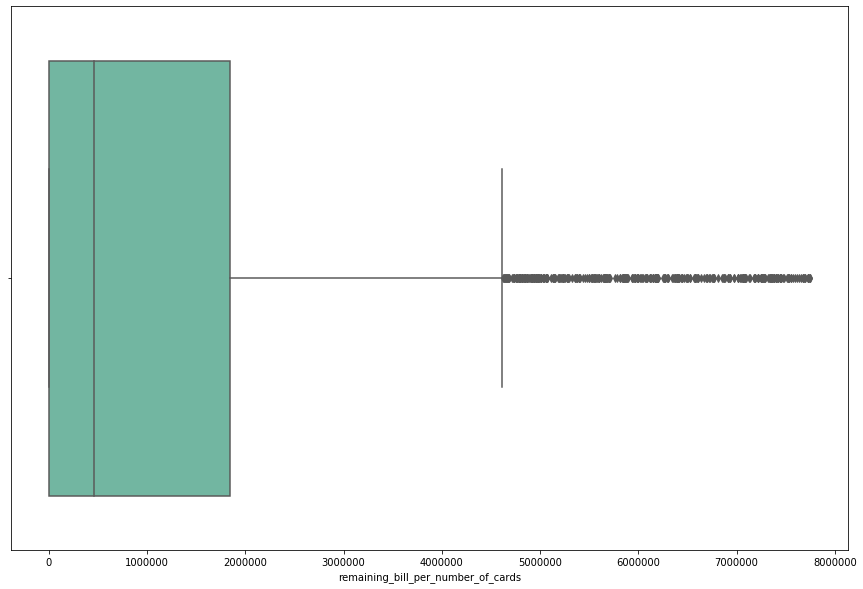

remaining_bill_per_limit


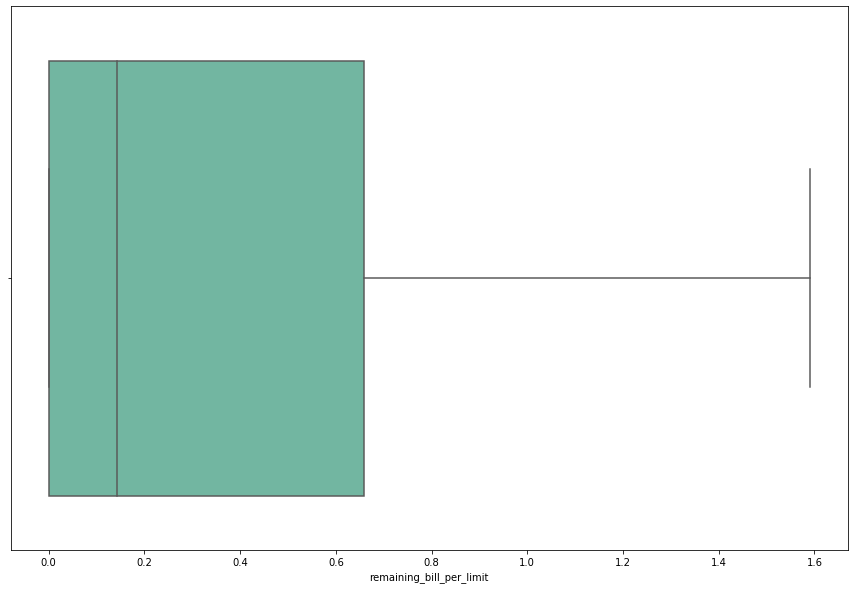

total_usage_per_limit


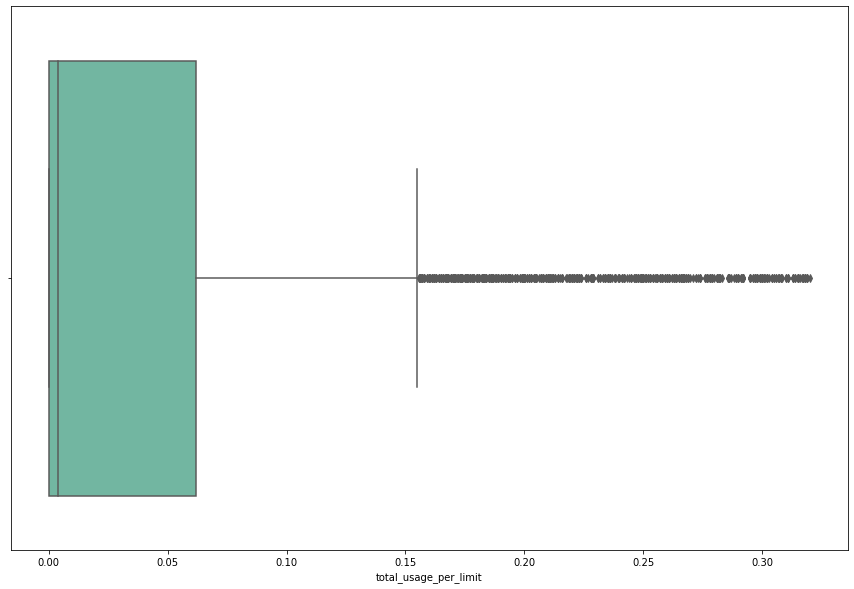

total_3mo_usage_per_limit


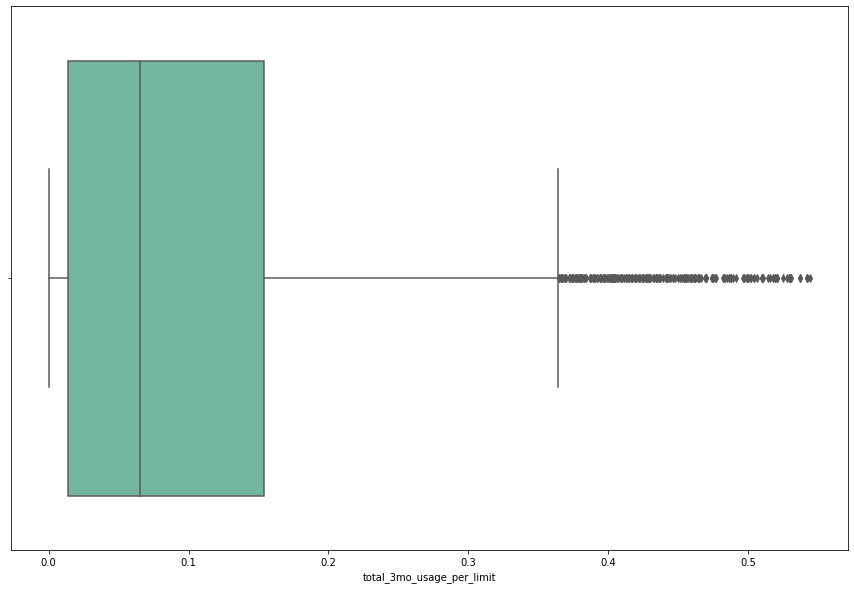

total_6mo_usage_per_limit


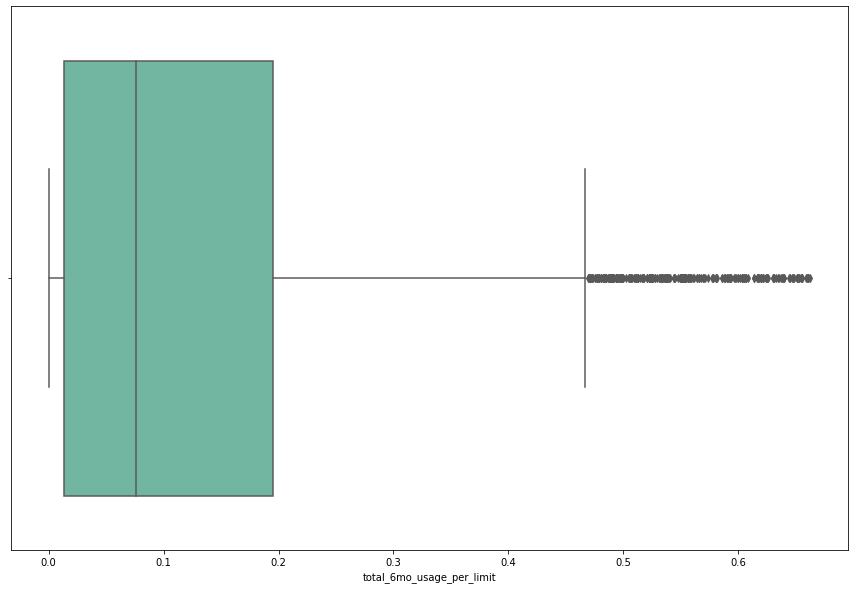

utilization_6month


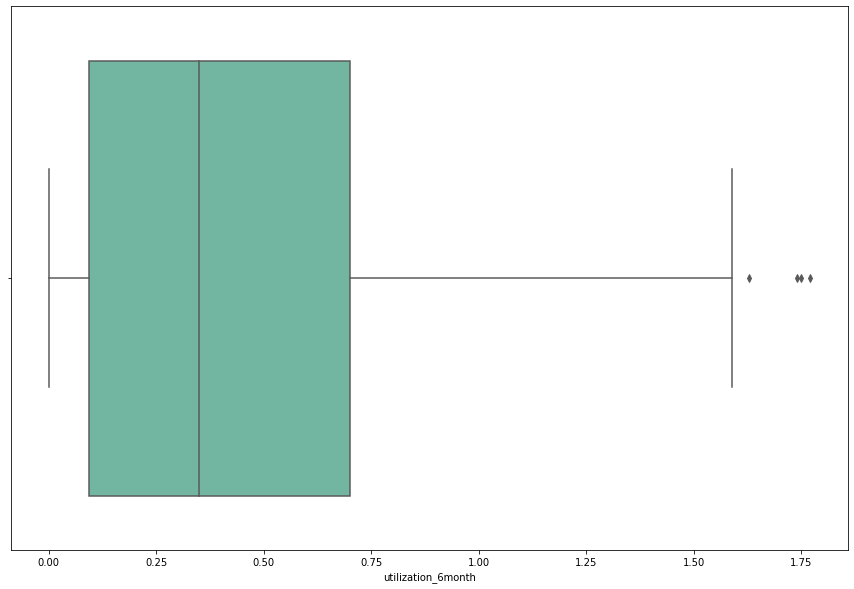

outstanding


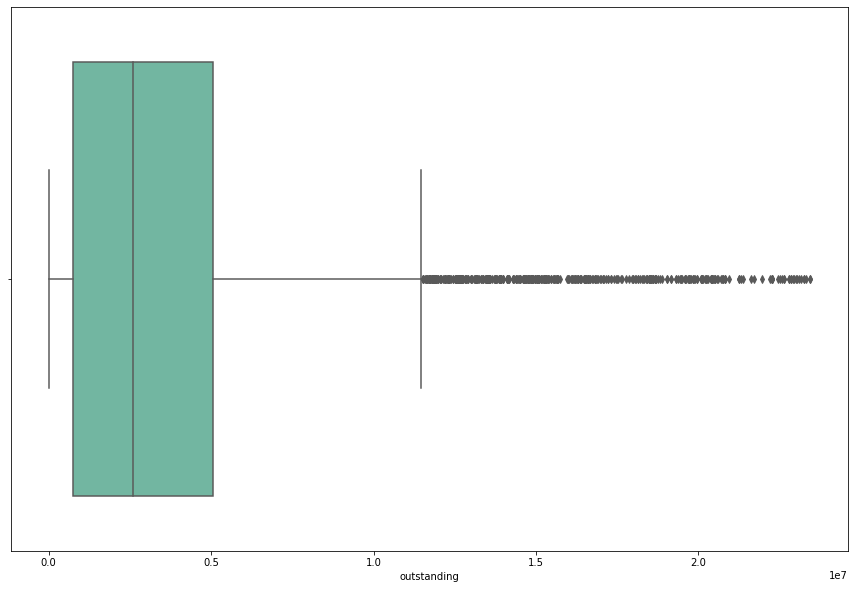

credit_limit


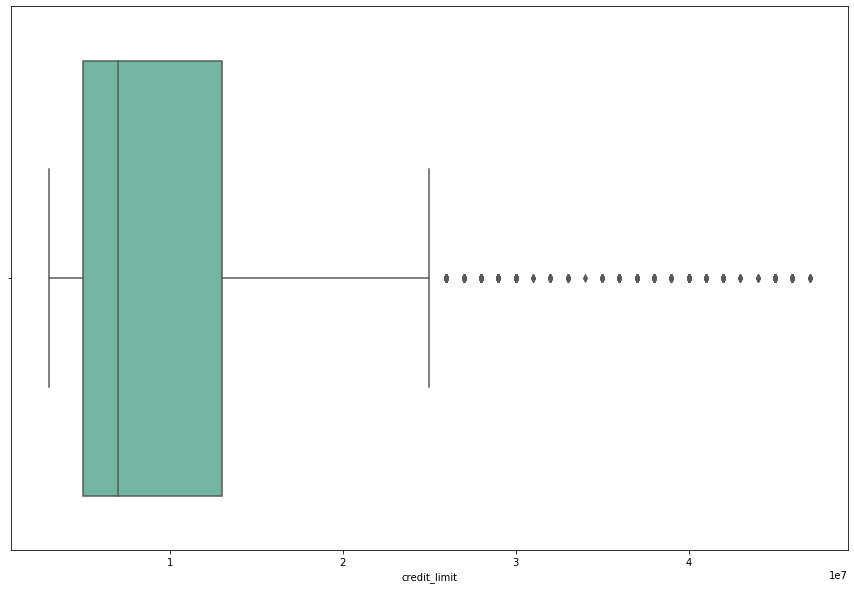

total_cash_usage


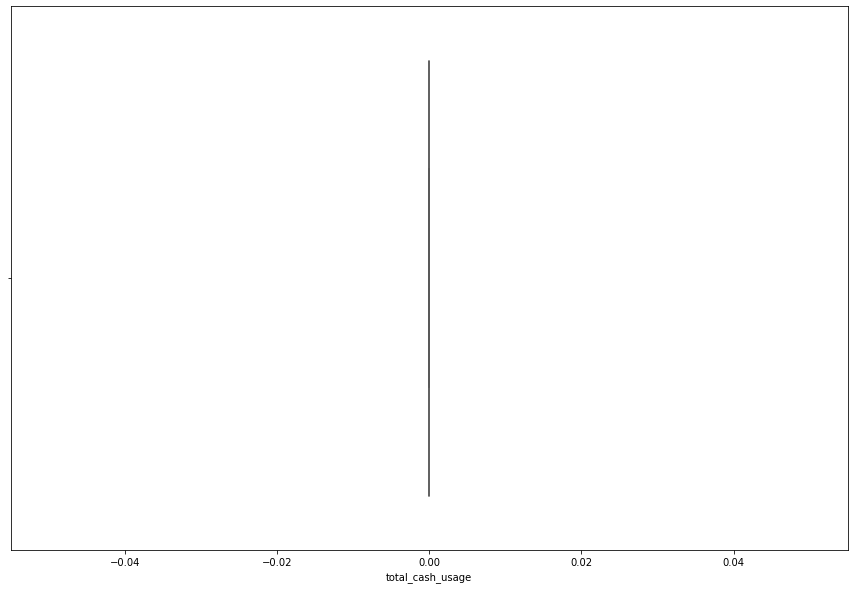

total_retail_usage


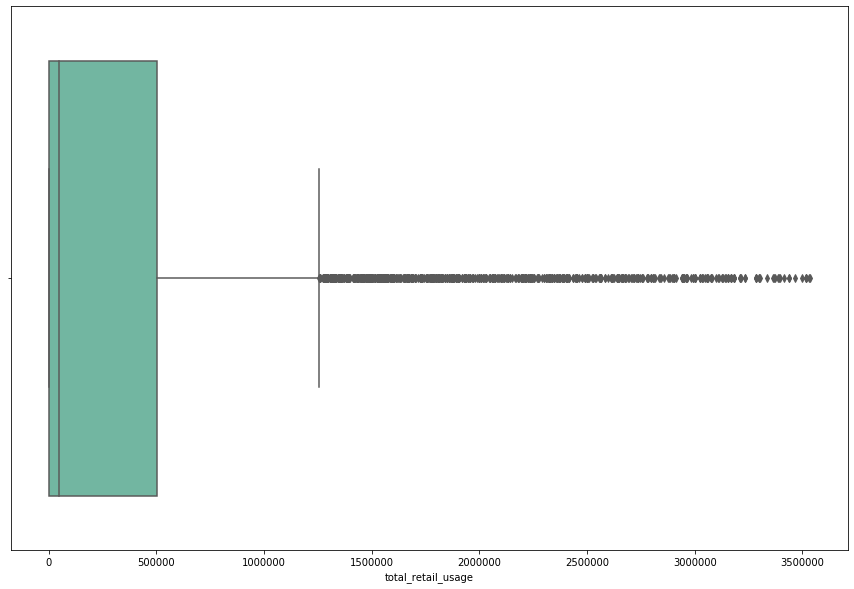

number_of_cards


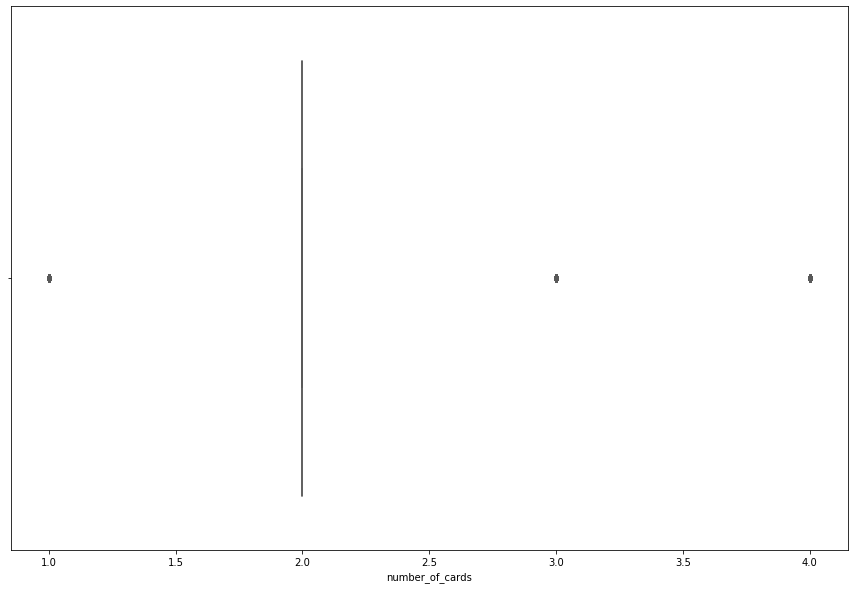

In [99]:
# Plotting Outliers for the columns
for column in analysis_columns2:
    print(column)
    check_outlier(fixed_df,column)
    print("="*90)


Looking at these boxplots and the data describe(), some values such as total_cash_usage are completely filled with zeroes. 

In [101]:
len(fixed_df[fixed_df['total_cash_usage'] > 0]) #Find number of rows in total cash usage that's larger than 0

0

Since there are no rows with total_cash_usage of >0, this column will be dropped.

In [103]:
fixed_df = fixed_df.drop('total_cash_usage',axis=1) #drop column and save to dataframe

In [104]:
analysis_columns2.remove('total_cash_usage')
fixed_df.describe() #verify that the operation succeeded

,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,years_since_card_issuing,remaining_bill_per_number_of_cards,remaining_bill_per_limit,total_usage_per_limit,total_3mo_usage_per_limit,total_6mo_usage_per_limit,utilization_6month,outstanding,credit_limit,total_retail_usage,number_of_cards,X,X,default_flag,delinquency_score
count,7461.00000,7461.000000,7461.000000,7461.000000,7461.000000,7.461000e+03,7461.000000,7461.000000,7461.000000,7461.000000,7461.000000,7.461000e+03,7.461000e+03,7.461000e+03,7461.000000,7461.000000,7461.000000,7461.000000,7461.000000
mean,0.49218,0.058229,0.535816,0.593634,5.746863,1.190503e+06,0.322801,0.043900,0.100540,0.126649,0.416601,3.743941e+06,1.032268e+07,3.874023e+05,2.219810,7761.632489,7761.632489,0.073449,0.031631
std,0.47773,0.318635,0.366513,0.404821,3.714630,1.617503e+06,0.364694,0.070115,0.108093,0.142279,0.344724,4.080477e+06,8.514204e+06,6.542545e+05,0.517458,4555.069070,4555.069070,0.260889,0.343951
min,0.00000,0.000000,0.000000,0.000000,0.750000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3.000000e+06,0.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.00000,0.000000,0.204000,0.200000,2.750000,0.000000e+00,0.000000,0.000000,0.013600,0.012900,0.092900,7.507190e+05,5.000000e+06,0.000000e+00,2.000000,3799.000000,3799.000000,0.000000,0.000000
50%,0.28400,0.000000,0.500000,0.598000,5.170000,4.628710e+05,0.142000,0.004000,0.065300,0.075800,0.349000,2.590903e+06,7.000000e+06,4.550000e+04,2.000000,7724.000000,7724.000000,0.000000,0.000000
75%,1.00000,0.000000,0.862000,1.000000,7.920000,1.846563e+06,0.658297,0.062000,0.154000,0.195000,0.700000,5.050904e+06,1.300000e+07,5.020000e+05,2.000000,11773.000000,11773.000000,0.000000,0.000000
max,2.44000,2.650000,1.954100,2.160000,18.800000,7.743339e+06,1.590000,0.320000,0.544000,0.662247,1.770000,2.342362e+07,4.700000e+07,3.533381e+06,4.000000,15642.000000,15642.000000,1.000000,5.000000


In this case, removal of the outliers based on the criteria I specified above resulted in the removal of almost half the original dataset. On one hand, this might seem to be a bad move as we lose a lot of information. On the other hand, this is a neccessary step because of the rules I specified above which are based on Bank Indonesia credit card usage rules and the information about Indonesian population of credit card users. The outlier rules I defined above gives me enough evidence that the outliers in the data do not explain anything about the population of Indonesian credit card users. The erroneous values also suggest that there might be some measurement/errors. Therefore, they have to be removed.

## Data Cleaning Summary

During this step, the following procedures were done:
1. Filled in/Removed null values
2. Removed negative variables 
3. Fixed some column values by recalculation
4. Removed highly correlated variables
5. Defined outlier criterion for this dataset based on information about the population 
6. Checked for normality and chose the IQR outlier removal method
7. Removed outliers based on IQR and the defined criteria
8. Additional cleaning (removal of column with all values equal to zeroes)

## Exploratory Data Analysis

### Analysis of User Credit Profiles based on their characteristics

Overall, there are 2 types of users:
    1. Good users, the non-defaulters or those with default_flag of 0
    2. Bad users, the defaulters, or users with default_flag of 1
Users are bad because they fail to make the payment by the due date

### Univariate

#### Categorical


In [107]:
def plot_categorical_attribs(df, col):
    plt.figure(figsize=(15,10))
    df[col].value_counts(normalize=False, dropna=False).plot(kind='bar', color='g', alpha=0.35)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

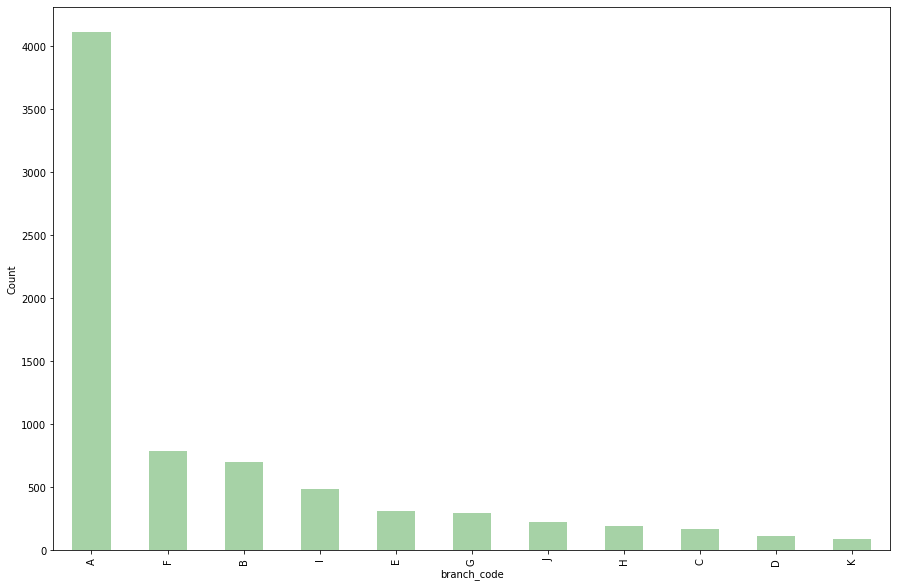

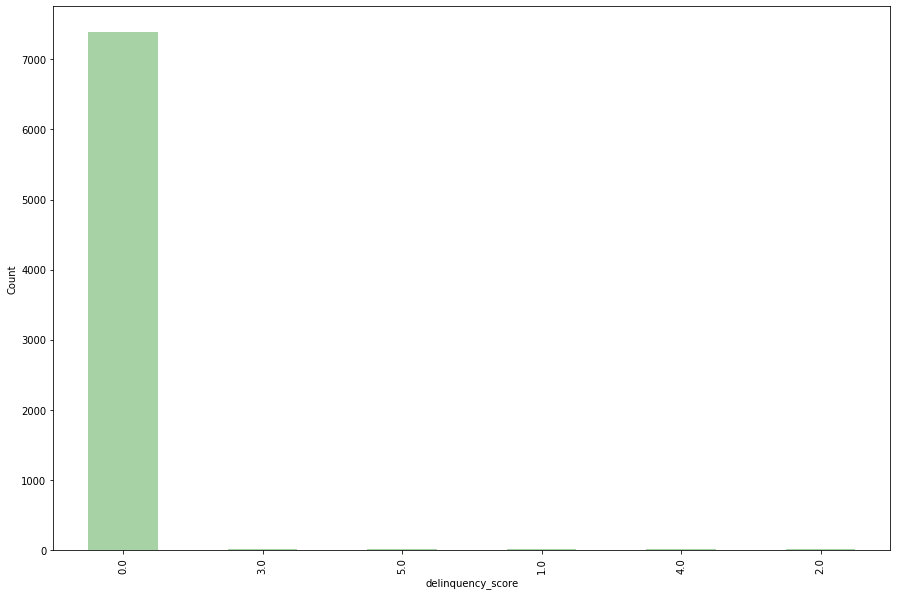

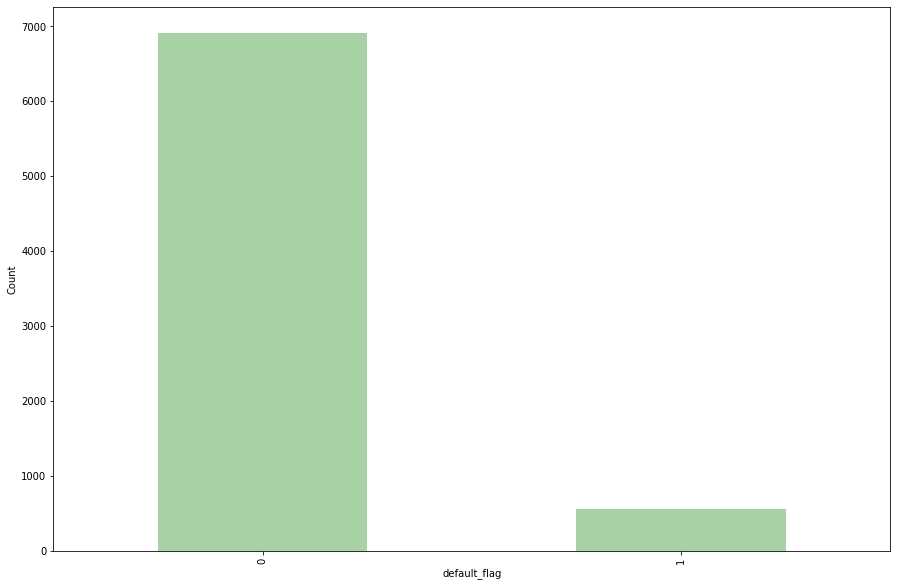

In [108]:
for c in ['branch_code', 'delinquency_score', 'default_flag']:
    plot_categorical_attribs(fixed_df, c)

In [109]:
print(fixed_df['default_flag'].value_counts())
#Count number of users who belong to non-default (0) and default (1) groups

0    6913
1     548
Name: default_flag, dtype: int64


In [111]:
print(548/6913 * 100) # Finding percentage of users who default

7.927093881093591


The percentage of users who default is only 7.93% out of all the users.

#### Describing users based on categorical attributes:

Overall, the data is imbalanced for categorical attributes such as default_flag, delinquency_score, and branch_code.

- Branch codes:
    - Out of all the branches, branch A has the most amount of credit card users with branch K having the least amount. 

- Delinquency score:
    - Overall, most users have a good delinquency score, with a score of 0. Meaning, that they are more likely to pay their bills on time.
Users with bad delinquency scores (above 0) are pretty rare.
- Default flag:
    - Most users do not default on their credit card payment. They seem to be succesful at paying their credit cards by the due date.
Only a handful (8 percent) of users are defaulters.


#### Numerical

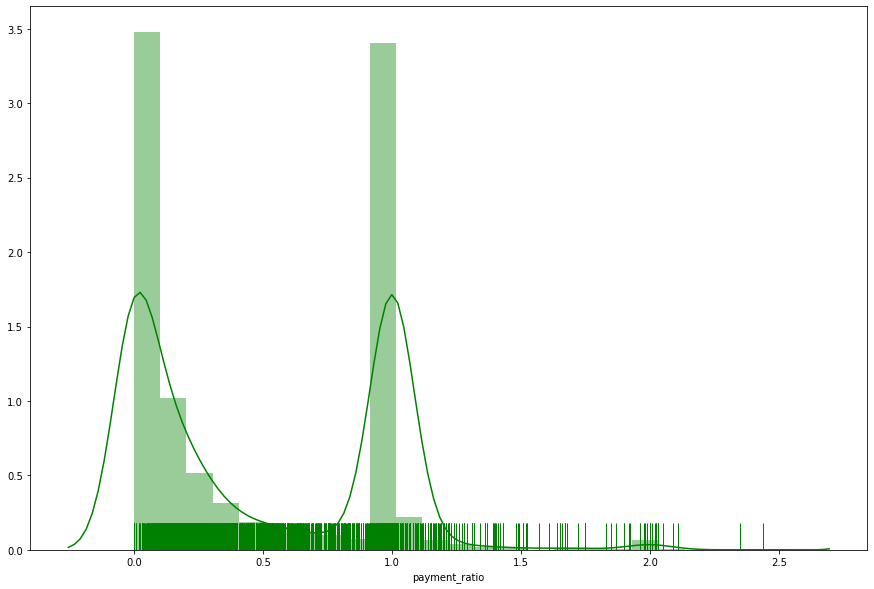

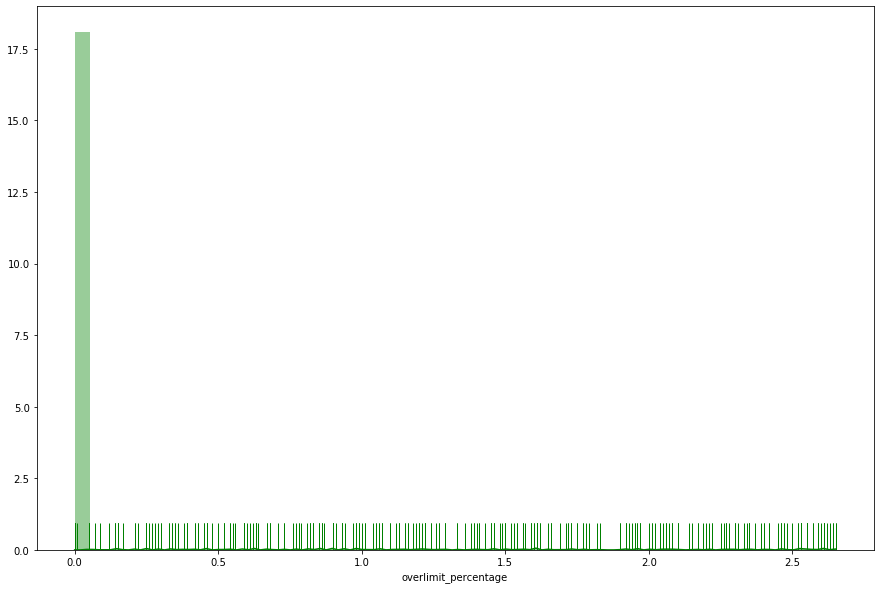

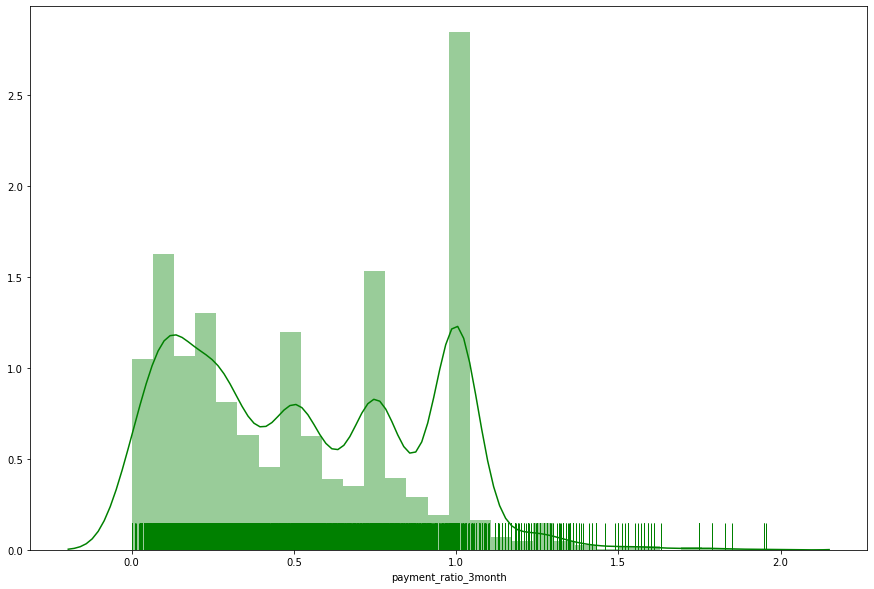

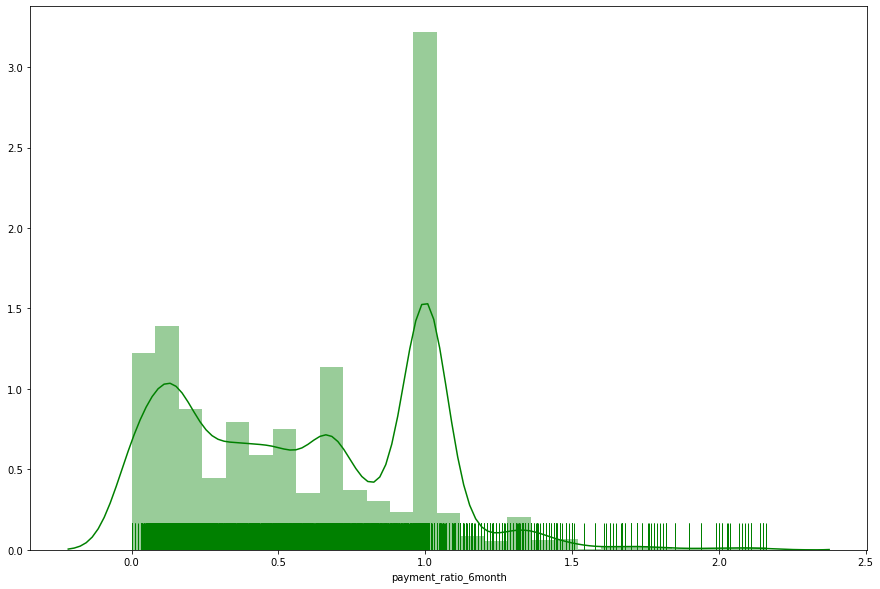

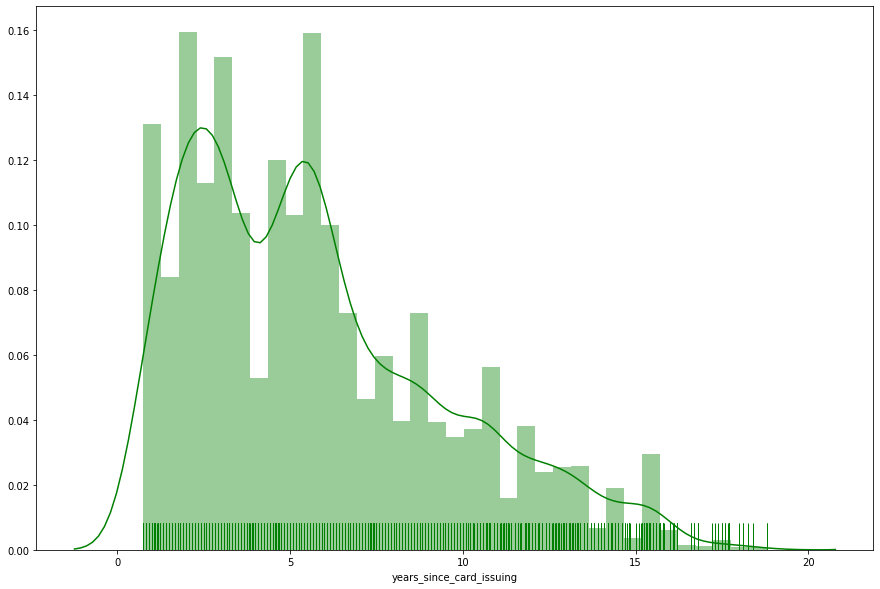

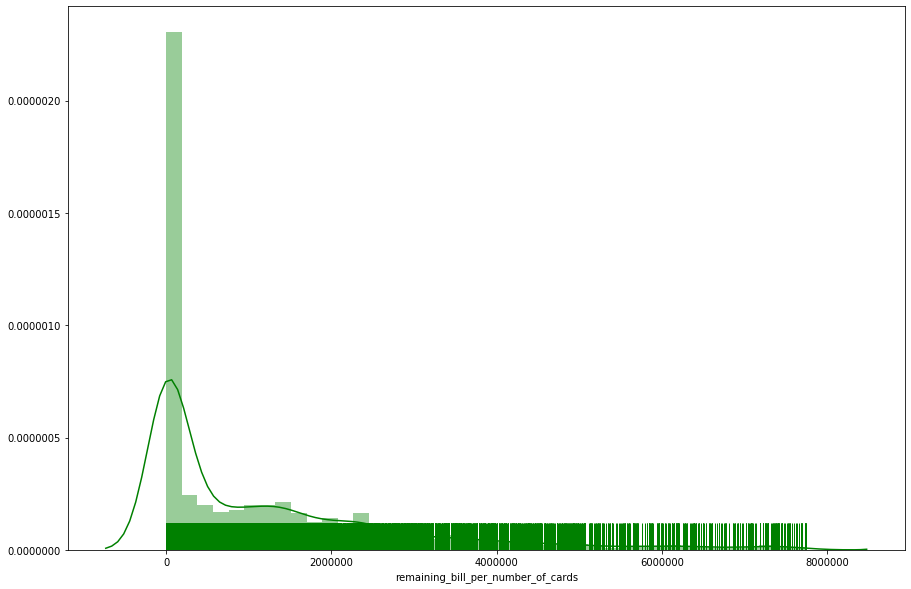

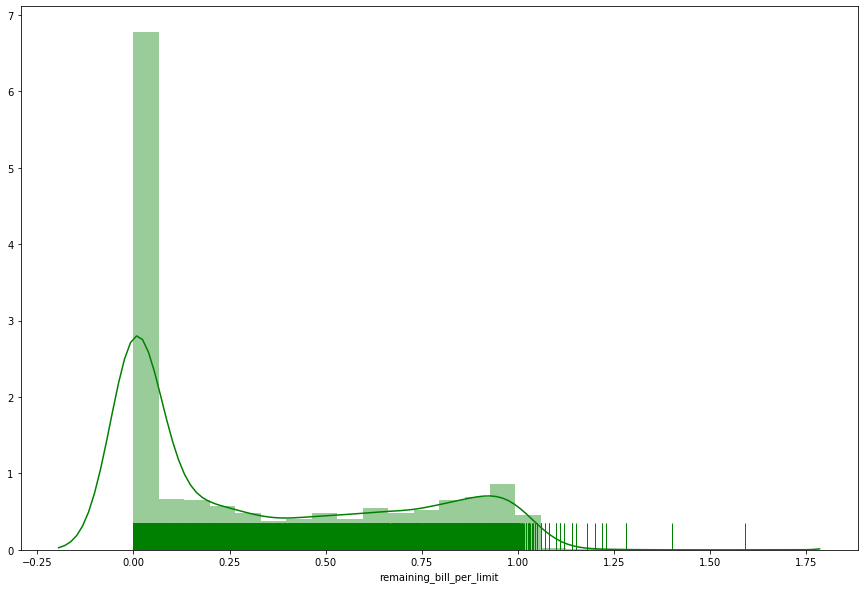

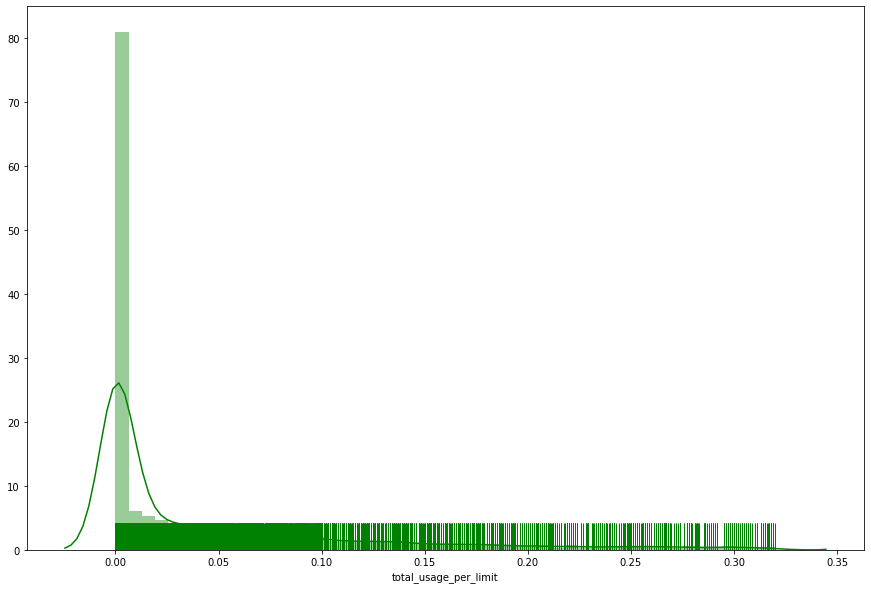

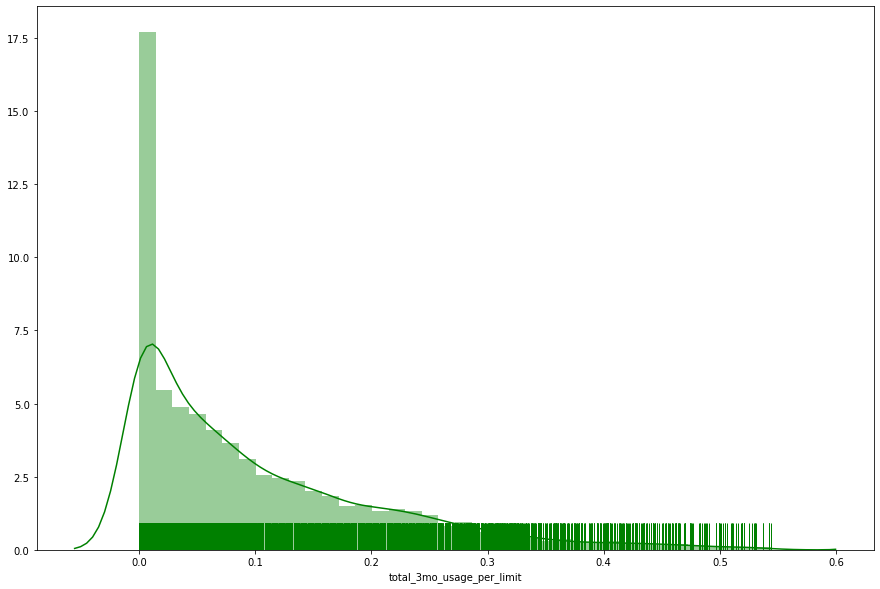

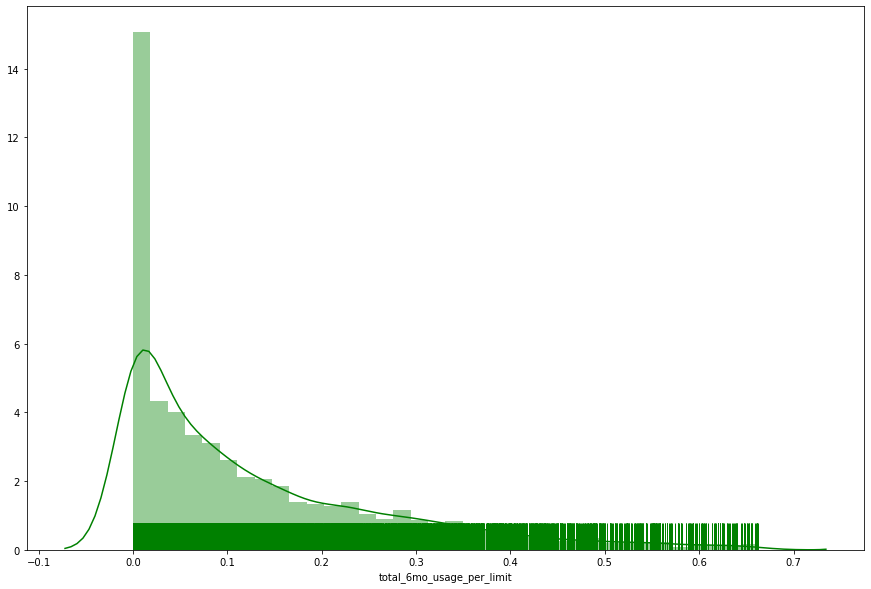

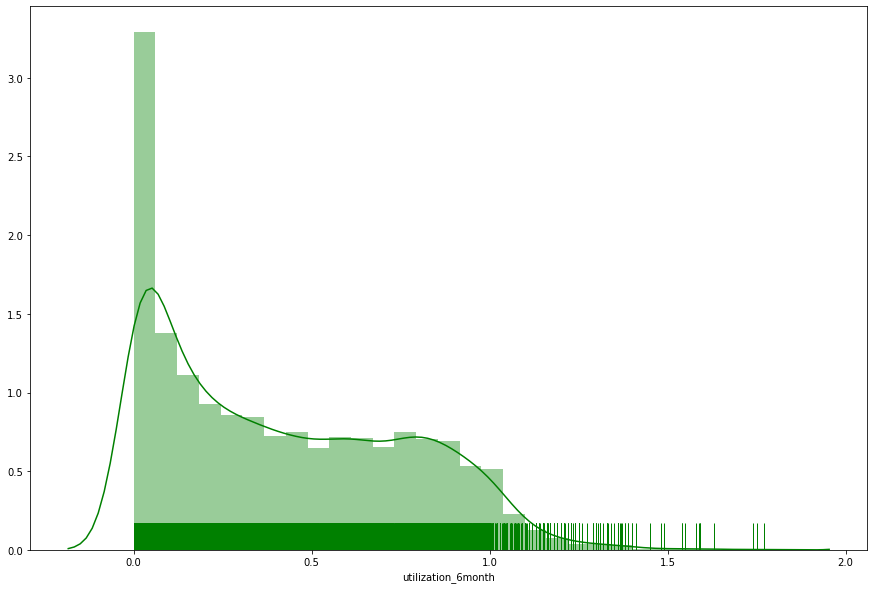

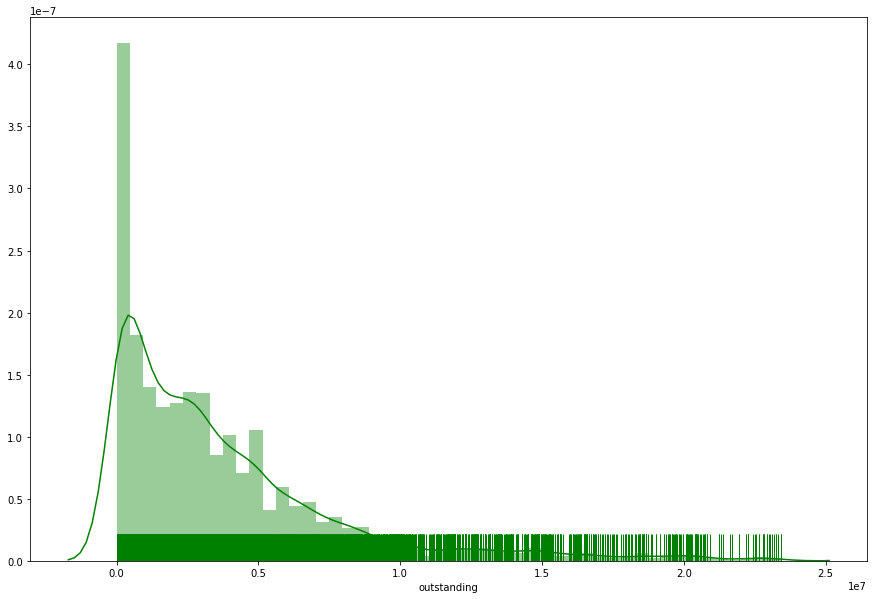

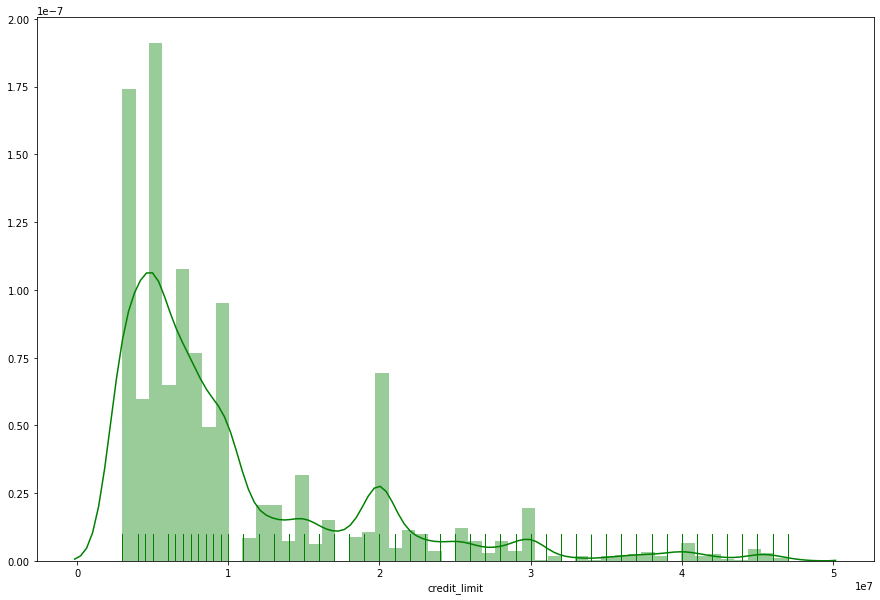

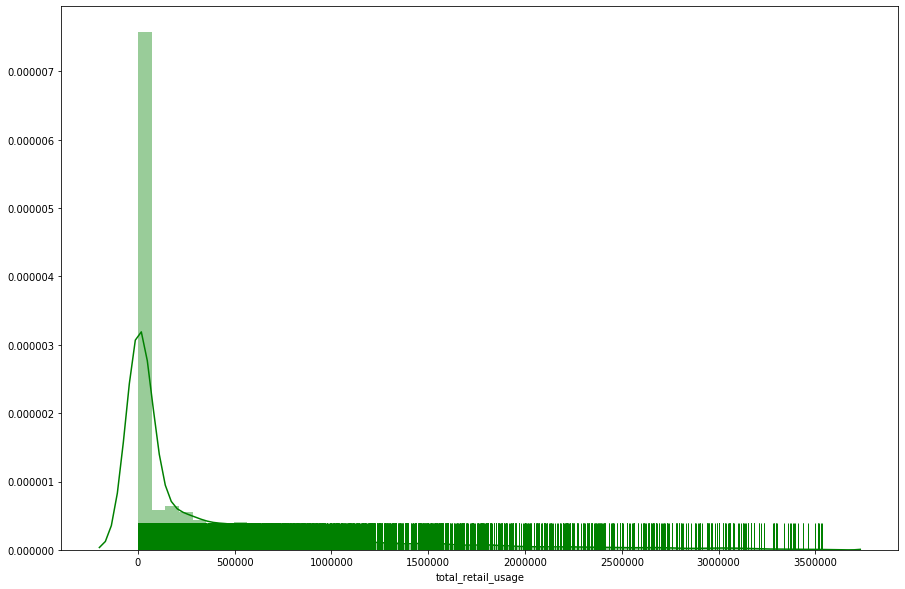

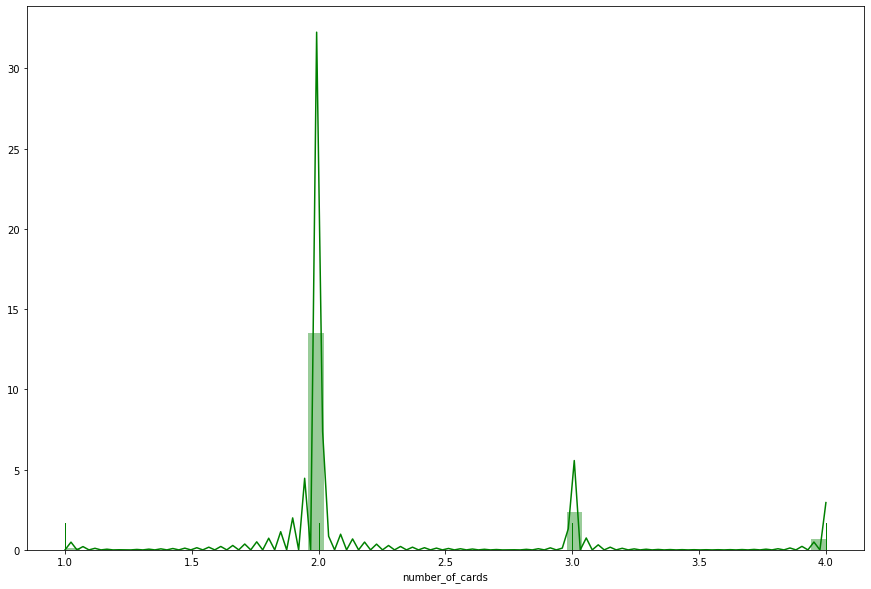

In [114]:
#Function to show the histograms of each numerical values
def show_histogram(df, col):
    plt.figure(figsize=(15,10))
    sns.distplot(df[col], hist=True, rug=True, color='g')
    plt.show()

for col in analysis_columns2:
    show_histogram(fixed_df, col)

Overall, most of the data distribution tells us that the data is **skewed right**.
This conforms with the usually observed patterns in real life e-commerce data, where a large number of users would have a very small amount of transactions on the platform, but a small amount of users would have a very high number of transactions on the platform.

#### Describing users based on their payment ratios:

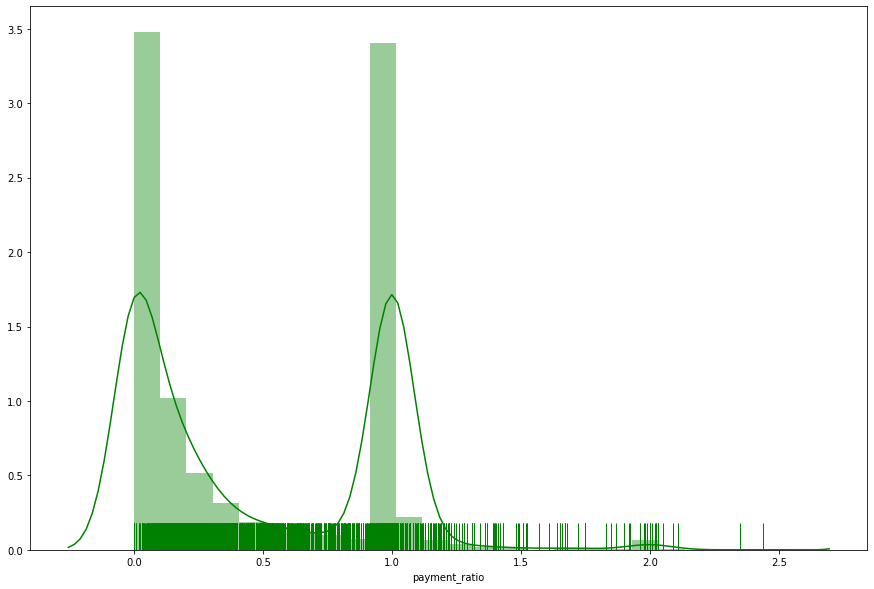

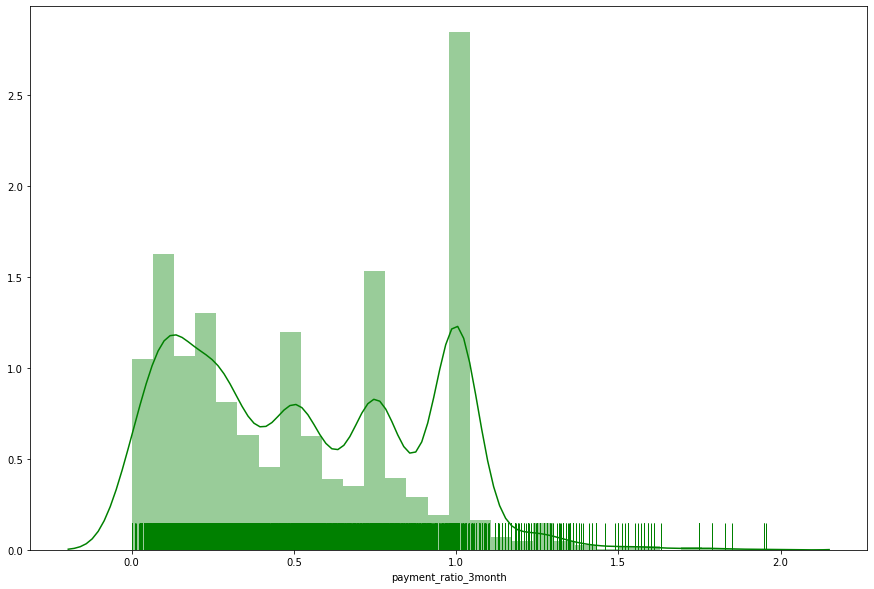

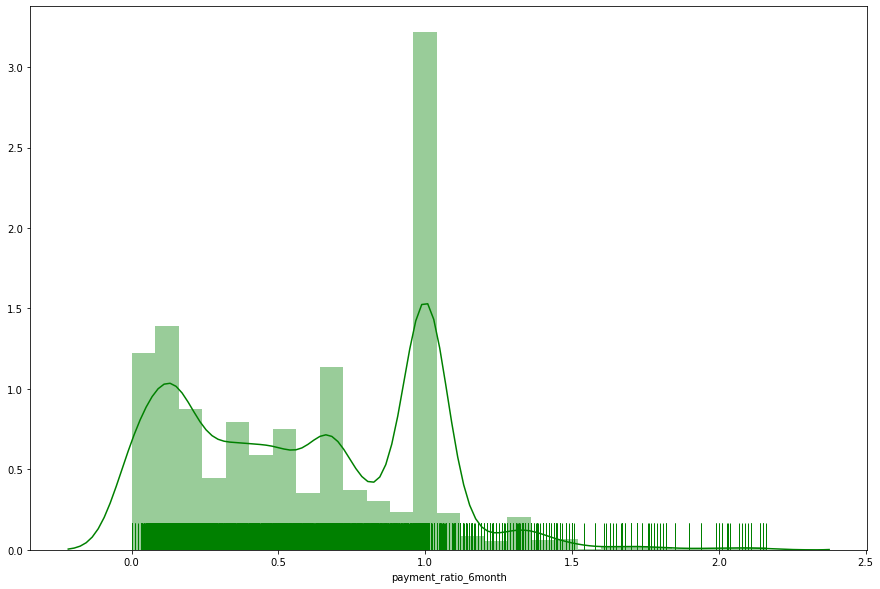

In [115]:
for col in ['payment_ratio', 'payment_ratio_3month', 'payment_ratio_6month']:
    show_histogram(fixed_df, col)

Payment ratio in 1 month:
Some users (50%) are able to pay their bills by the end of the month/early next month. Whilst the rest paid in smaller increments but the rest 50% of users don't pay anything by the end of the month.
It can be observed that several users pay more than their bills (up to almost 2.5 times of their bills)

Payment ratio in 3 months:
Similar trend, but in this case, most users pay all their bills by 3 months.
But the number of observed users having a pay ratio of >1 is increasing (but only up to 2.0)

Payment ratio in 6 months:
Here, the majority of users pay all their bills by 6 months. With the number of users paying more than 1.0 of payment increasing compared to 1 month and 3 month values.
In this variable, I think that the values of payment ratio in 3 months and in 1 month is included here. 

#### Describing users based on overlimit_percentage:

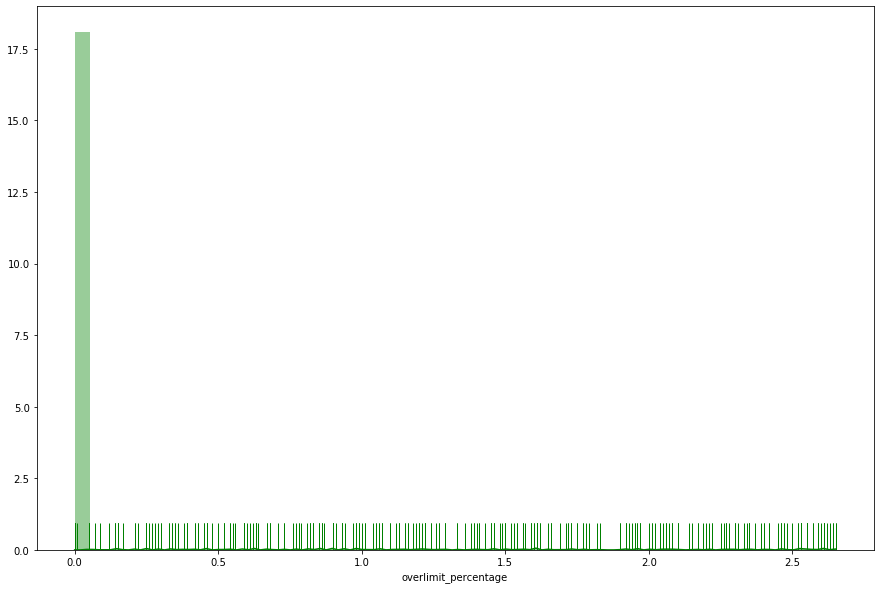

In [117]:
show_histogram(fixed_df, 'overlimit_percentage')

In [116]:
print(len(fixed_df[fixed_df['overlimit_percentage'] > 0]))

317


Most users don't go over the limit of their credit cards. Only around 300 users spend over their credit card limit. Most credit card providers dont allow users to spend over their limit (decline their transaction after the limit is reached). Perhaps this explains why the majority of users have an overlimit percentage of 0.
But some banks allow this sort of over the limit transaction, but it comes with a cost. Even though this is allowed, this actually hurts the credit score of users and it places them at a higher credit risk than those who don't spend over the limit.

Lenders should avoid these users with a high overlimit percentage as they most likely have a **lower good credit score/higher credit risk**. 

#### Describing users based on credit_limit

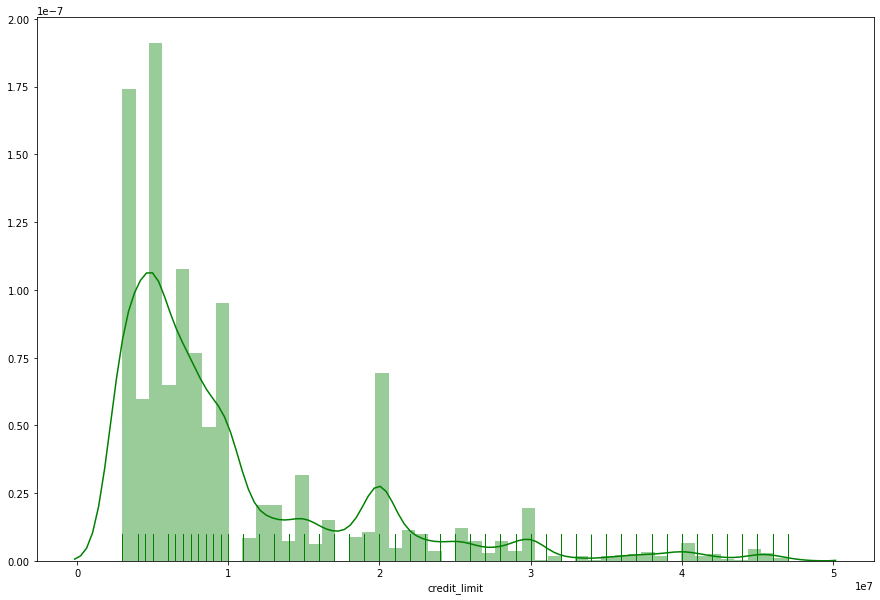

In [118]:
show_histogram(fixed_df, 'credit_limit')

We can observe that most users have a credit limit of < 10 million IDR. This is consistent with the fact that Indonesian average salary is under 10 million IDR, with many users having an income of around 3,000,000-4,000,000. Since credit card limit is defined by BI to be a maximum of 3 times the monthly income, this trend of credit limit fits in with the population of Indonesian credit card users.

#### Describing users based on number of credit cards:

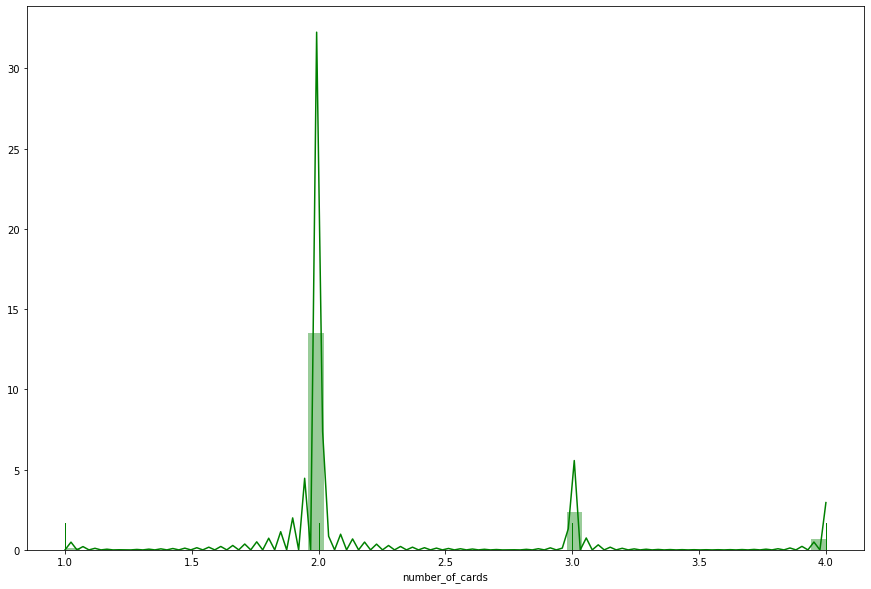

In [119]:
show_histogram(fixed_df, 'number_of_cards')

Most users have 2 credit cards, with those above 2 being very rare.
What is interesting is the fact that the number of users with 1 credit card is very low. 
Perhaps users want as much credit cards as possible, to take advantage of promos and such. But they are limited by the BI regulation which states that:
**users with income of under 10 million IDR should have only 2 credit cards maximum**.


#### Describing users based on credit card usage

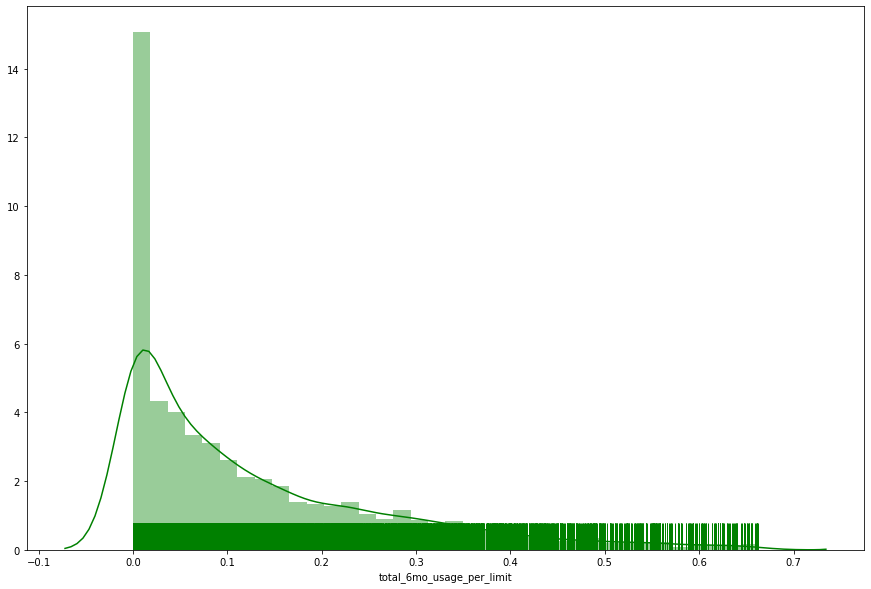

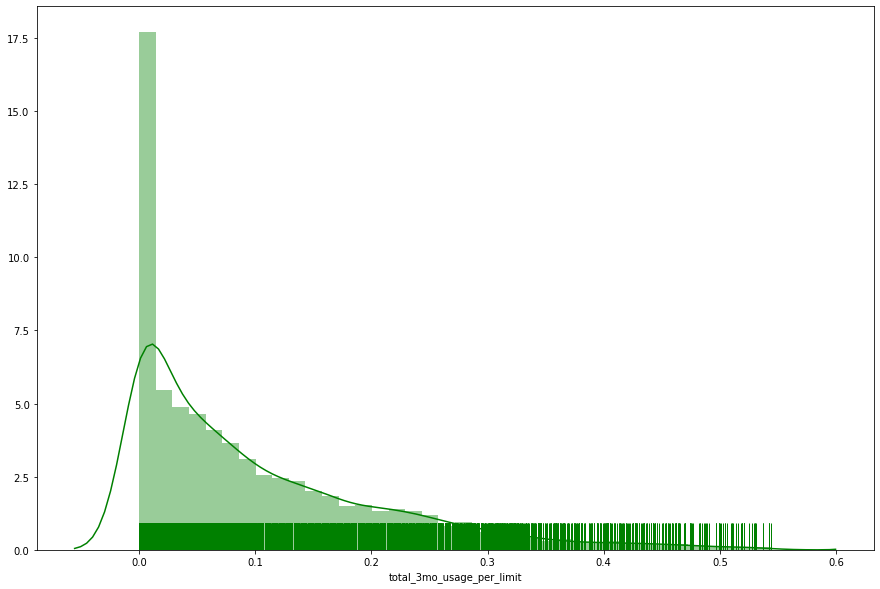

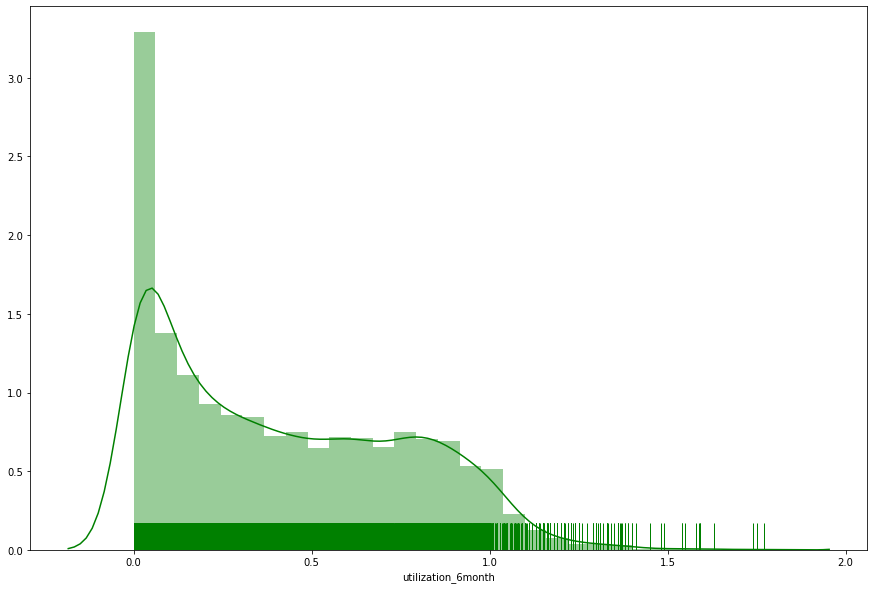

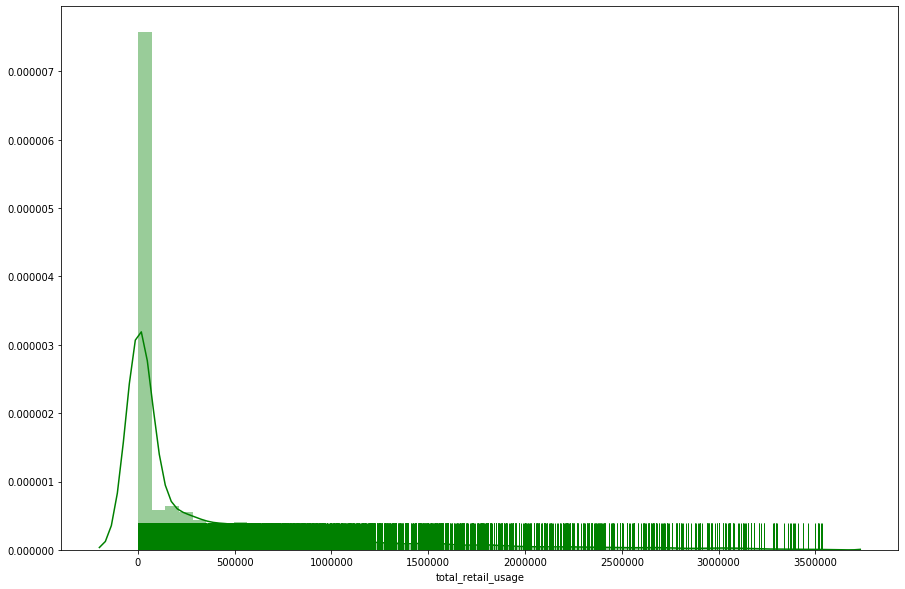

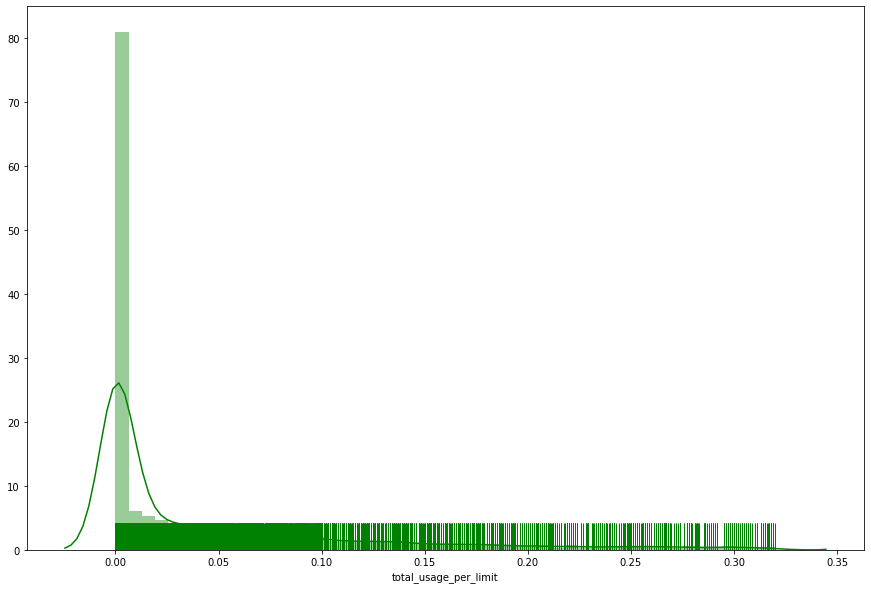

In [120]:
columns = ['total_6mo_usage_per_limit', 'total_3mo_usage_per_limit', 'utilization_6month', 'total_retail_usage', 'total_usage_per_limit']
for col in columns:
    show_histogram(fixed_df, col)


A lot of useres tend to not use the credit card too much, as we can see from the histograms above, most of them have a usage/utilization of near 0. 

##### My knowledge constraint regarding the variable meanings

- `Utilization_6month` is a bit hard to read, but based on the distribution of the data, it can be inferred that this represents the **ratio of used credit/balance available**. Because it is observed that the number of users with a utilization of > 1 is very small. The users with util of near 2 are extremely small in numbers. But if I infer this that way, there is a problem with total3mo, total6mo, and total_usage_per_limit.

- `total_3mo and total_6mo usage per limit`: It is observed that within these months, users have used the card for 0.0 until 0.7. It is hard to understand what this means, because this is **not correlated** strongly with `utilization_6month` but by definition and range of values they should measure similar things. 

- `Total usage per limit`
I assume that this is per month, but this variable also seems similar to utilization 6 month and total3mo and total6mo usage per limit. But they are not correlated strongly.

Considering the factors above, I assume that **credit score (as defined by banks)** is related to **utilizaiton 6 month**. With 1.0 meaning that the user utilized all the credit card limits, and above 1.0 to be users who utilized more than their limits.

Considering the average good credit score is <= 0.3, Lenders should aim to increase more of these users. They should somehow filter out those with higher than > 0.3 utilization_6month and aim to increase the proportion of users with <= 0.3 utilization 6 month.

##### Total Retail Usage

Right skewed, represents that only a small amount of users use the credit card for large retail purchases

#### Describing users based on remaining bills/outstanding

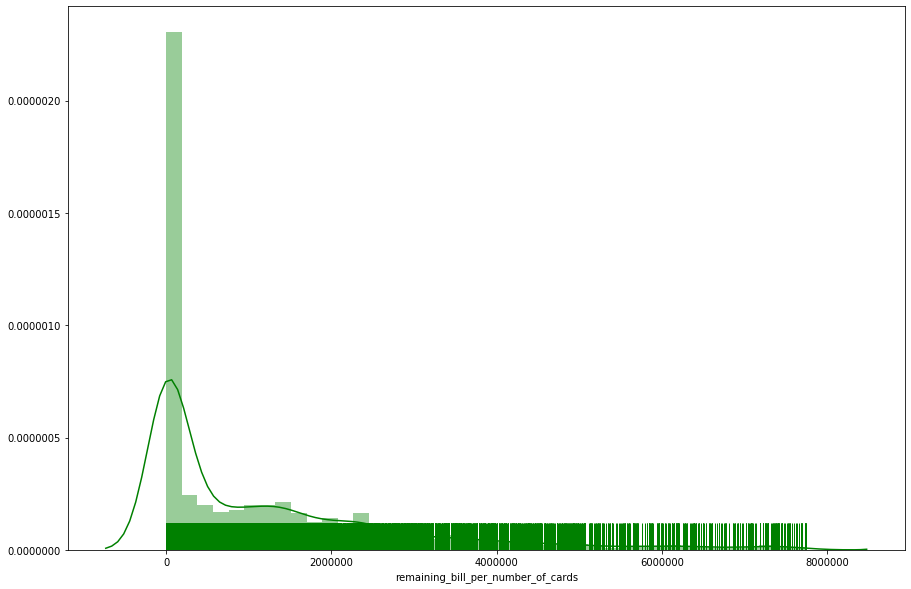

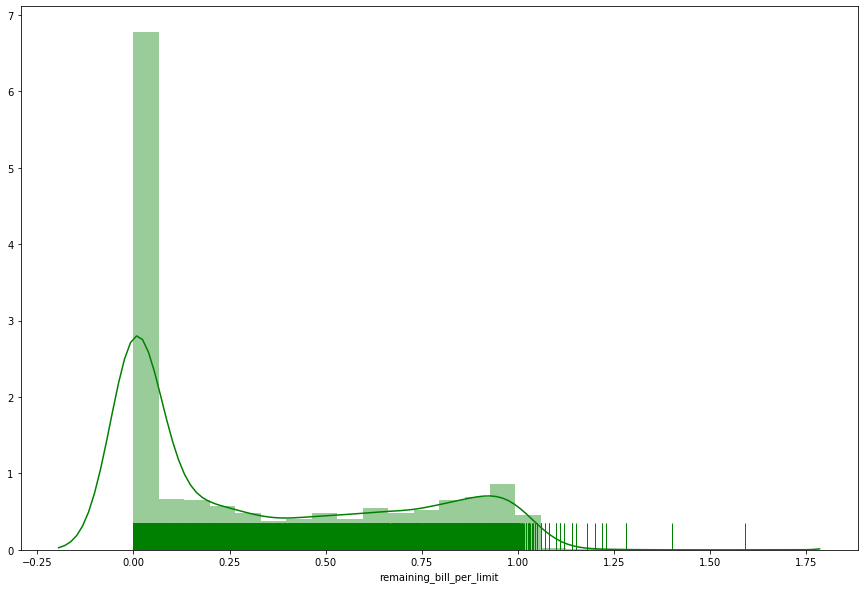

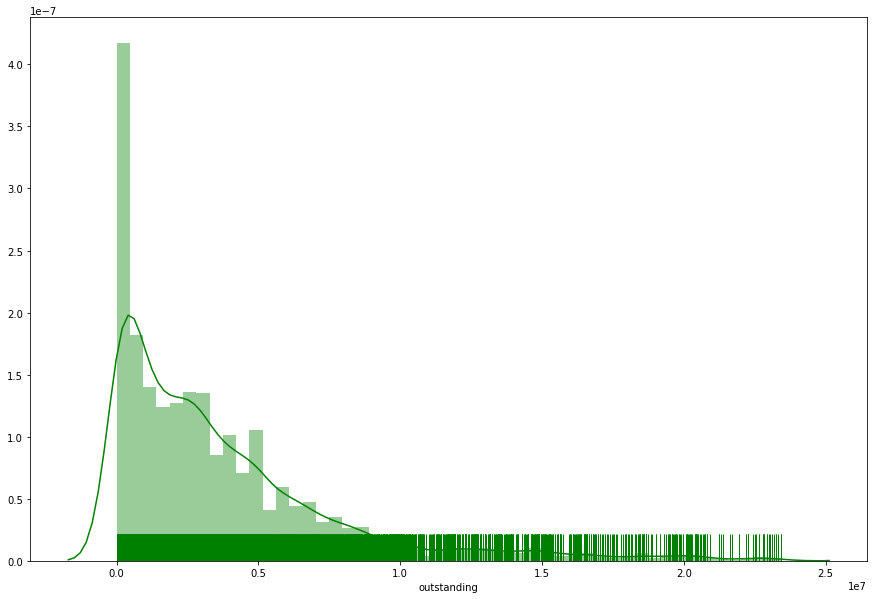

In [121]:
columns = ['remaining_bill_per_number_of_cards', 'remaining_bill_per_limit', 'outstanding']
for col in columns:
    show_histogram(fixed_df, col)

I think that in this part, the `remaining_bill_per_limit` shows that some users have used over 1.75 times their limit of credit card. Lenders should try to filter out these users as they might posess high credit risk and in the long run, be detrimental to the company.

### Bivariate

In [122]:
fixed_df[analysis_columns2 + ['delinquency_score', 'default_flag']].corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt
.get_cmap('coolwarm'), axis=1)

,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,years_since_card_issuing,remaining_bill_per_number_of_cards,remaining_bill_per_limit,total_usage_per_limit,total_3mo_usage_per_limit,total_6mo_usage_per_limit,utilization_6month,outstanding,credit_limit,total_retail_usage,number_of_cards,delinquency_score,default_flag
payment_ratio,1.0,-0.084,0.72,0.43,0.016,-0.36,-0.45,0.23,0.21,0.13,-0.18,-0.15,0.07,0.22,-0.03,-0.062,-0.2
overlimit_percentage,-0.084,1.0,-0.1,-0.077,-0.026,0.19,0.28,0.028,0.15,0.11,0.22,0.15,-0.067,0.0054,0.02,0.0014,0.014
payment_ratio_3month,0.72,-0.1,1.0,0.71,0.037,-0.35,-0.45,0.24,0.29,0.19,-0.22,-0.14,0.1,0.25,-0.021,-0.071,-0.22
payment_ratio_6month,0.43,-0.077,0.71,1.0,0.014,-0.24,-0.31,0.17,0.22,0.24,-0.19,-0.087,0.079,0.19,-0.011,-0.076,-0.17
years_since_card_issuing,0.016,-0.026,0.037,0.014,1.0,-0.0093,-0.092,-0.009,-0.066,-0.08,-0.1,0.068,0.26,0.079,0.34,0.02,-0.024
remaining_bill_per_number_of_cards,-0.36,0.19,-0.35,-0.24,-0.0093,1.0,0.75,0.016,0.12,0.15,0.49,0.8,0.17,0.12,0.041,-0.018,-0.0011
remaining_bill_per_limit,-0.45,0.28,-0.45,-0.31,-0.092,0.75,1.0,0.041,0.21,0.23,0.66,0.5,-0.21,-0.025,0.047,-0.02,-0.011
total_usage_per_limit,0.23,0.028,0.24,0.17,-0.009,0.016,0.041,1.0,0.39,0.21,0.031,0.089,-0.11,0.78,-0.0063,-0.05,-0.15
total_3mo_usage_per_limit,0.21,0.15,0.29,0.22,-0.066,0.12,0.21,0.39,1.0,0.55,0.17,0.25,-0.17,0.27,-0.01,-0.053,-0.17
total_6mo_usage_per_limit,0.13,0.11,0.19,0.24,-0.08,0.15,0.23,0.21,0.55,1.0,0.4,0.22,-0.15,0.13,-1.8e-05,-0.032,-0.094


Many of the variables have some strong correlations with each other, this is due to the fact that they might be derivatives of one another. 
High correlations:
- Payment ratio 3 month and payment ratio 1 month 
- outstanding and remaining_bill_per_number_of_cards
- total_usage_per_limit and total_retail_usage 

Earlier on, I have removed those with extremely high correlations and those confirmed to be derivatives of one another. So, I will not do that again in this step.

### Examining User characteristics (categorical) and the default rate

There are many categorical variables that can be used to characterize these users and their default rates. Amongst these are:
- Branch Code
- Delinquency Score (Ordinal)
- Number of Credit Cards (Ordinal)

#### User Default Percentage by Branch Code

In [125]:
fixed_df.to_csv('fixed-data.csv') #-> save file to csv for analysis using spreadsheet

##### Number of users per branch code

In [126]:
fixed_df.groupby('branch_code')['default_flag'].count()

branch_code
A    4107
B     701
C     170
D     110
E     310
F     789
G     293
H     191
I     485
J     220
K      85
Name: default_flag, dtype: int64

![default percentage by branch code](images/default-prcnt-code.png)

Several insights from User Default Percentage and Branch Code:
- Branch A gives the most number of loans compared to the other branches, with branch F second most and branch B third most number of loans. Branch K gives the least number of loans. 
This data might signify characteristics related to the location of these branches. 
For instance, users in branch A might be located in Jakarta, the most populous city. While users in branch K might be from rural areas or far from the cities. 

- Based on the `percentage` of **defaulting users**, branch G performs the best, while branch E performs the worst. Despite both of these branches giving out loans to a similar number of people. Does this mean that branch G has a good way of filtering out bad users?

Branch E lenders could learn from branch G about **best practices for detecting people who are more likely to default**, and thus  **minimize the number of users who default**.

##### User Default by delinquent Score

![Default Percentage by Delinquent Score](images/delinq-score-default.png)

Insights from user default percentage and default score:
- A higher delinquency score is associated with a higher percentage of defaulting
- Non-default users are more likely to have a delinquency score of <= 1

Lenders should prioritize giving loans to users with 0 `delinquency_score`

##### Examining Delinquent Score per Branch for Default Flag = 1

![Defaulters Branch by Delinquent Score](images/default-only-branch-delinquency_score.png)
![Defaulters per Branch by Delinquency Score above 0](images/5-branch-score-1.png)

Here, the delinquency score of the defaulters will be examined per branch. 
It is found that for branch E, the worst performing branch, they took in more than 30% of users with delinquency score of >0.
But, for all defaulters in branch D, J, and K, they all have a **delinquency score of > 0**. 

#### User Default and Number of Credit Cards

![Default Percentage by Number of Credit Cards](images/default-cc.png)

The chart of number of credit cards vs default percentage does not show any kind of significant difference between the two. One would expect to see a higher default percentage the higher the number of credit cards because of difficulties in managing them.
This might be due demographic differences, where users with less credit cards are more likely to be of a **lower income**.

The default rate is around 7 % for all amount of credit cards.

### Examining  Continuous Variables

In [134]:
# Build function to plot attributes against a target box plot
def plot_attribs_against_target(df,col,target):
    f = plt.figure(figsize=(7,5))
    sns.boxplot(x=target, data=df, y=col, color= 'g', palette="Set3")
    plt.show()

In [135]:
#Plot histogram but with default flag filters
def plot_attribs_against_target_histogram(df, col, target):
    df0 = df[df.default_flag == 0]
    df1 = df[df.default_flag == 1]
    plt.figure(figsize=(7,5))
    sns.distplot(df0[col], hist=True, color='b', label='flag 0')
    sns.distplot(df1[col], hist=True, color='r', label='flag 1')
    plt.legend(['flag 0', 'flag 1'])
    plt.show()

#### Payment Ratio Defaulters vs Non Defaulters

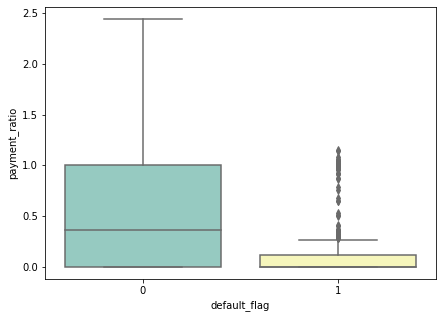

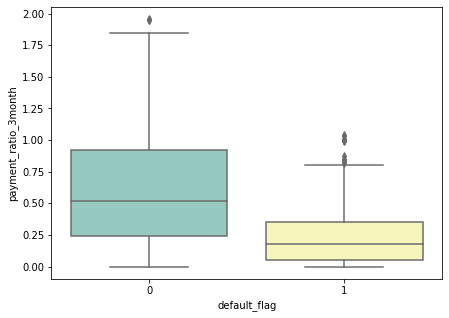

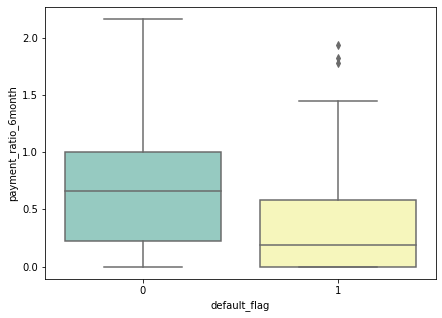

In [138]:
plot_attribs_against_target(fixed_df, 'payment_ratio', 'default_flag')
plot_attribs_against_target(fixed_df, 'payment_ratio_3month', 'default_flag')
plot_attribs_against_target(fixed_df, 'payment_ratio_6month', 'default_flag')

It can be directly observed that the users who are **Non-Defaulters** have a higher **Payment Ratio**. In general, they could pay back credit better compared to non-defaulters. The graph below illustrates this as well. It can be observed that within one month, more non defaulters are able to pay all their bills (evidence in higher non-defaulter payment_ratio at 1.0) compared to defaulters.

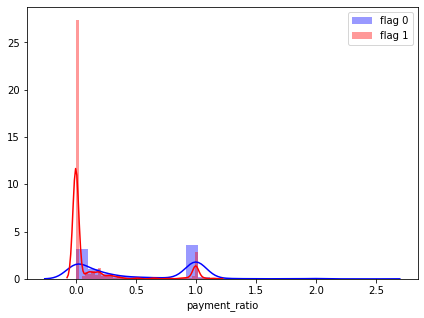

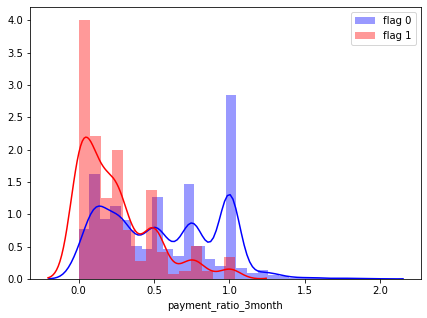

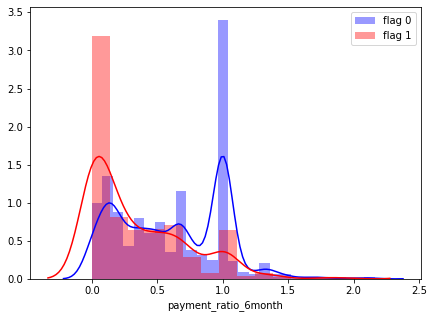

In [139]:
plot_attribs_against_target_histogram(fixed_df, 'payment_ratio', 'default_flag')
plot_attribs_against_target_histogram(fixed_df, 'payment_ratio_3month', 'default_flag')
plot_attribs_against_target_histogram(fixed_df, 'payment_ratio_6month', 'default_flag')

This trend continues even until 6 months.

#### Credit Card Usage Amount

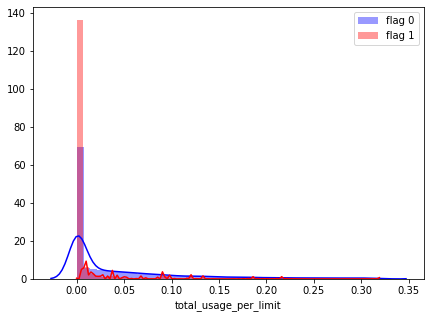

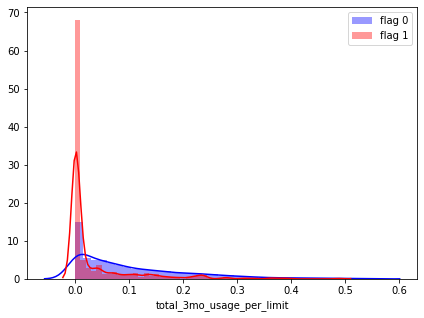

In [140]:
plot_attribs_against_target_histogram(fixed_df, 'total_usage_per_limit', 'default_flag')
plot_attribs_against_target_histogram(fixed_df, 'total_3mo_usage_per_limit', 'default_flag')

Defaulters tend to use their credit card less compared to non-defaulters. This can be seen in the distribution of the defaulters, which are higher at 0.0 to 0.01 but then is lower than the distribution of non-defaulters after that point.

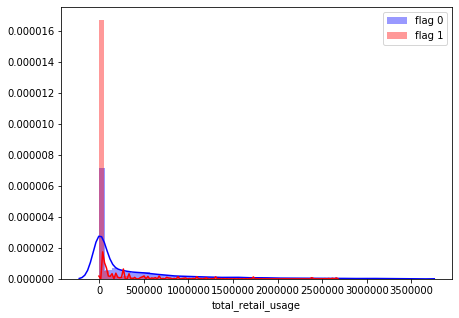

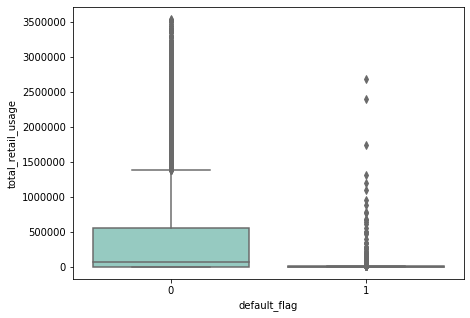

In [141]:
plot_attribs_against_target_histogram(fixed_df, 'total_retail_usage', 'default_flag')
plot_attribs_against_target(fixed_df, 'total_retail_usage', 'default_flag')

Total Retail Usage also shows that for retail purchases, non defaulters tend to spend more. Except for some outliers in defaulter users, who spend higher than average defaulter total_retail_purchases. Which is comparable to non-defaulters total retail usage.

#### Examining Outstanding Amounts of Defaulters vs Non Defaulters

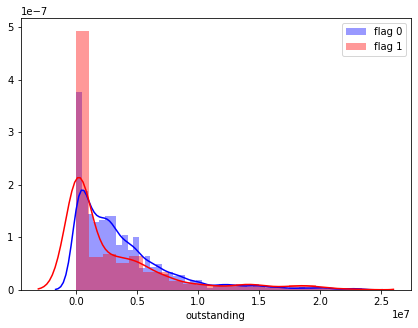

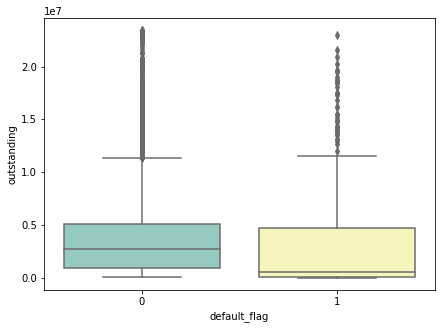

In [143]:
plot_attribs_against_target_histogram(fixed_df, 'outstanding', 'default_flag')
plot_attribs_against_target(fixed_df, 'outstanding', 'default_flag')

At a glance these two groups seem to have comparable outstanding amounts (based on their boxplots). But the histogram reveals something interesting:
- There are some users who still have to default, even though they have comparably less outstanding amount than the non-defaulters.

This group might be some sort of **very low income group**. They might be taking loans to get by their daily lives, and were not able to pay the bills.
Lenders should pay more attention to this group.

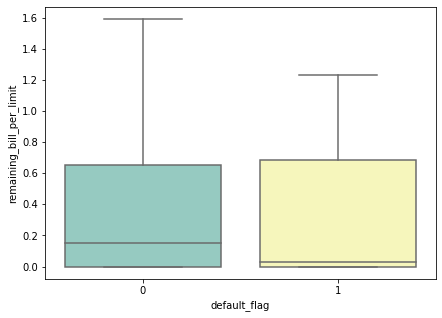

In [144]:
plot_attribs_against_target(fixed_df, 'remaining_bill_per_limit', 'default_flag')

I cross-examined the defaulters again, and it seems that even though they have lower remaining bills per limit, they still have to default. This is also another evidence to support my hypothesis that some users are borrowing to cover costs in their daily lives.

#### Examining number of Credit Cards and Credit Limit 

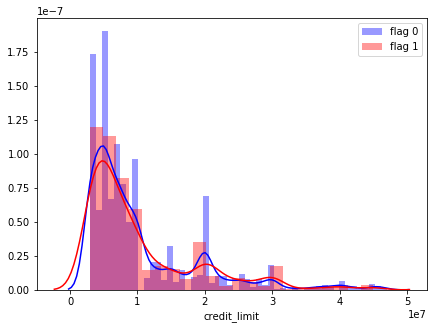

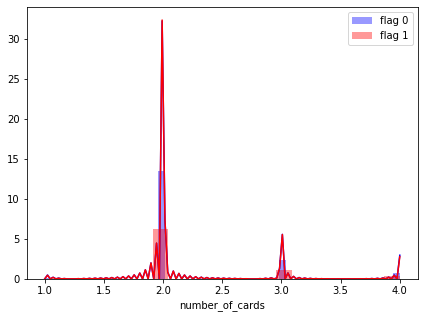

In [145]:

plot_attribs_against_target_histogram(fixed_df, 'credit_limit', 'default_flag')
plot_attribs_against_target_histogram(fixed_df, 'number_of_cards', 'default_flag')

It can be observed that non defaulters have a slightly higher credit limit, but the difference is miniscule. 
The two groups have similar number of card distribution.

## EDA Summary

**Overall statistics**:
- Most users have 2 credit cards, with those above 2 being very rare.
What is interesting is the fact that the number of users with 1 credit card is very low. 
Perhaps users want as much credit cards as possible, to take advantage of promos and such. But they are limited by the BI regulation which states that:
**users with income of under 10 million IDR should have only 2 credit cards maximum**.
- Overall, most of the data distribution tells us that the data is **skewed right**. This conforms with the usually observed patterns in real life e-commerce data, where a large number of users would have a very small amount of transactions on the platform, but a small amount of users would have a very high number of transactions on the platform.



**Categorical Variables**:
- Branch:
    - Out of all the branches, branch A has the most amount of credit card users with branch K having the least amount. 
    - Branch G performs the best, with 2 % default rate
    - Branch E performs the worst, with 17% default rate
- Delinquency score:
    - Overall, most users have a good delinquency score, with a score of 0. Meaning, that they are more likely to pay their bills on time. Users with bad delinquency scores (above 0) are pretty rare.
    - Lenders should avoid giving credit to users with > 0 delinquency score.
    - Lenders should prioritize giving credit to users with 0 delinquency score
- Default flag:
    - Most users do not default on their credit card payment. They seem to be succesful at paying their credit cards by the due date. 
    - Only a handful (8 percent) of users are defaulters.
    - The data is imbalanced, but in this case, it is a good thing. Since, if there are too many defaulters, then profit of the Lender might decrease because more money is lent 
	without any return/payback from the customers.


**Defaulter Characteristics**:
- Defaulters tend to have a lower payment ratio
- Tend to use their credit card less than non-defaulters
- Same number of credit cards as non-defaulters
- Same credit limit as defaulters
- One group of defaulters cannot even pay a small amount of outstanding (I call this the very low income defaulter group)